# Première approche : RNN predicting one stock

Cette méthode est présentée ici : https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html#normalization

In [34]:
!pip install yfinance
!pip install mpld3
!pip install pytorchtools
!pip install torchvision
!pip install chart_studio

In [35]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

cf.go_offline()

## Stock DATASET

In [36]:
import torch
from torch.nn import MSELoss
from torch.optim import RMSprop, Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.nn import LSTM, Module, Dropout, ModuleList

import yfinance as yf
import pandas as pd
import numpy as np
import os

from typing import Union
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins

In [37]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, nb_steps: int=30, normalize=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        # Raw data (pd.Series)
        self.data = dataset

        # Dataset parameters
        self.nb_samples = nb_samples
        self.nb_steps = nb_steps
        self.normalize = normalize
        
        # Converting dataset into arrays for easy manipulations
        dataset = np.array(dataset['Close'].tolist())

        # Sliding window of size nb_samples along the dataset (Loads 2 more values --> first : normalisation value, last : label,
        # those values will be dropped in samples afterward in order to have exactly nb_samples values in samples)
        samples = np.vstack( [dataset[i:i+self.nb_samples+2] for i in range(len(dataset) - self.nb_samples - 2)] )

        # Get normalization values
        normalization_values = samples[:, 0]

        # Normalization
        if self.normalize:
          # Normalize samples (and drop first value in samples that served for normalization)
          samples = np.vstack([normalize_by_last_unknown_price(sample)[1:] for sample in samples])
        else:
          samples = samples[:, 1:]

        # Get labels (last value in samples)
        labels = samples[:, -1]
        # Drop last value in samples that corresponds to the label
        samples = samples[:, :-1]
          
        self.normalization_values = normalization_values
        self.samples = samples
        self.labels = labels
          
    def __len__(self) -> int:
        return len(self.data) - self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        return torch.tensor(self.samples[index]), torch.tensor(self.labels[index])
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.normalization_values[index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

# def relative_difference(sample: torch.Tensor) -> torch.Tensor:
#     return torch.diff(sample)/sample[:-1]

Test d'une autre manière de gérer le dataset, plus proche de l'implémentation proposé dans l'article :

In [38]:
 class StockPriceDataset_multiple_steps(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, nb_steps: int=30, normalize: bool=True,
                 file_dir: str="data/", csv_file: str=None):
      
        self.nb_samples = nb_samples
        self.nb_steps = nb_steps
        self.normalize = normalize

        if csv_file is not None: # If a local data file must be loaded:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                data = pd.read_csv(file, sep=',', header='infer')
        else: # Data must be loaded on an online database:
            data = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)
        
        self.data = data
        seq = data['Close'].tolist()

        # split into items of size nb_samples
        seq = [np.array(seq[i*self.nb_samples:(i+1)*self.nb_samples]) for i in range(len(seq)//self.nb_samples)]

        if self.normalize:
            normalization_values = [seq[0][0]] + [seq[i-1][-1] for i in range(1, len(seq[1:]))]
            seq = [seq[0] / seq[0][0] - 1.0 ] + [curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]
            # seq = [seq[0] / seq[0][0] ] + [curr / seq[i][-1] for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        samples = np.array([seq[i: i + self.nb_steps] for i in range(len(seq) - self.nb_steps)])
        labels = np.array([seq[i + self.nb_steps] for i in range(len(seq) - self.nb_steps)])

        self.samples = samples
        self.labels = labels
        self.normalization_values = normalization_values


    def __len__(self) -> int:
        return len(self.samples)


    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = torch.tensor(self.samples[index])
        label = torch.tensor(self.labels[index])
        return sample, label
      

    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.normalization_values[index]

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :
torch.Size([30, 20])
torch.Size([20])
nombre de valeurs SnP500 :  426000


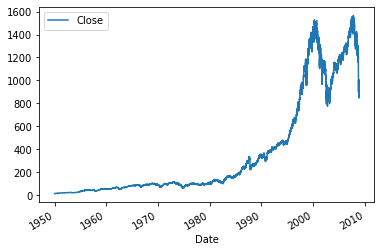

In [39]:
VISUALIZE_DATASET = True
if VISUALIZE_DATASET:
  dataset = StockPriceDataset_multiple_steps(start_date='1950-01-03',
                              end_date='2008-11-16',
                              interval='1d',
                              normalize=True)
  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  dataset.data.plot(None, ['Close'])

  print(dataset.__getitem__(0)[0].shape)
  print(dataset.__getitem__(0)[1].shape)
  print("nombre de valeurs SnP500 : ", len(dataset)*dataset.nb_steps*dataset.nb_samples)

## Modèle

In [40]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, dropout, proj_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.proj_size = proj_size
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers, dropout=dropout, batch_first=True, proj_size=self.proj_size)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]

## Configuration

In [41]:
class StockAIConfig():
    config = {
        "model":{
            "lstm_size": 128,
            "num_layers": 1,
            "dropout": 0.2
        },

        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2010-11-16',
            "interval_date": '1d',
            "nb_samples": 15, 
            "nb_steps": 10,
            "batch_size": 64,
        },

        "dataset_test":{
            "start_date": '2010-11-17',
            "end_date": '2020-11-16',
            "interval_date": '1d',
            "batch_size": 64,
        },

        "learning":{
            "init_lr": 0.001,
            "lr_decay": 0.99,
            "max_epoch": 75
        }   
    }
    config["model"]["proj_size"] = config["dataset_train"]["nb_samples"]
    config["model"]["input_size"] = config["dataset_train"]["nb_samples"]

## Initialisation des datasets et du modèle

### Choix du dataset à utiliser

In [94]:
# Whether to use StockPriceDataset or StockPriceDataset_multiple_steps
STOCK_PRICE_DATASET_MULTIPLE_STEPS = True

### Initialisation

In [95]:
# Model config
config = StockAIConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

if STOCK_PRICE_DATASET_MULTIPLE_STEPS:
  # Init of the dataset
  dataset_train = StockPriceDataset_multiple_steps(config["dataset_train"]["start_date"], 
                              config["dataset_train"]["end_date"],
                              config["dataset_train"]["interval_date"], 
                              config["dataset_train"]["nb_samples"],
                              config["dataset_train"]["nb_steps"],
                              normalize=True)

  # Init of the multi-steps dataset
  dataset_test = StockPriceDataset_multiple_steps(config["dataset_test"]["start_date"], 
                              config["dataset_test"]["end_date"],
                              config["dataset_test"]["interval_date"], 
                              config["dataset_train"]["nb_samples"],
                              config["dataset_train"]["nb_steps"],
                              normalize=True)
  
  # Init of the model (in this case, we predict as many samples as nb_samples)
  model = StockAI(config["model"]["input_size"],
                  config["model"]["lstm_size"],
                  config["model"]["num_layers"],
                  config["model"]["dropout"],
                  config["model"]["proj_size"])
  
else:
  # Init of the first type of dataset
  dataset_train = StockPriceDataset(config["dataset_train"]["start_date"], 
                              config["dataset_train"]["end_date"],
                              config["dataset_train"]["interval_date"], 
                              config["dataset_train"]["nb_samples"],
                              config["dataset_train"]["nb_steps"],
                              normalize=True)

  # Init of the dataset_test
  dataset_test = StockPriceDataset(config["dataset_test"]["start_date"], 
                              config["dataset_test"]["end_date"],
                              config["dataset_test"]["interval_date"], 
                              config["dataset_train"]["nb_samples"],
                              config["dataset_train"]["nb_steps"],
                              normalize=True)

  # Init of the model (in this case, we predict only one sample further)
  model = StockAI(config["model"]["input_size"],
                  config["model"]["lstm_size"],
                  config["model"]["num_layers"],
                  config["model"]["dropout"],
                  proj_size=1)

# Init dataloader of the dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], drop_last=True)

# Init dataloader of dataset_test
dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], drop_last=True)

# Transfer the model to the device (cpu or gpu)
model.to(device)

# Loss
loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=learning_rates[0], eps=1e-08)
optimizer = RMSprop(model.parameters(), lr=config["learning"]["init_lr"], eps=1e-08)
lr_scheduler = ExponentialLR(optimizer, gamma=config["learning"]["lr_decay"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



In [96]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
      
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Training loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [97]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=3, delta=0, verbose=False)

## Apprentissage

In [98]:
# To track the average training loss per epoch as the model trains
train_losses = []
avg_train_losses = []

for epoch in range(config["learning"]["max_epoch"]):
    print(f"Running for epoch {epoch}...")
    running_loss = 0.0

    ######################
    #  train the model   #
    ######################
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
          x = torch.unsqueeze(x, 1).float()
        else:
          x = x.float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        
        # print("y.shape = ", y.shape)
        # print("x.shape = ", x.shape)
        # print("model.forward(x).shape = ", model.forward(x).shape)
        y_pred = torch.squeeze(model.forward(x))
        loss = loss_fn(y_pred, y)
        train_losses.append(loss.item())

        if i_batch%10==0:
            print(f"step: {i_batch}, loss = {loss}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Updates learning rate
    lr_scheduler.step()

    # print training/validation statistics --> calculate average loss over an epoch
    train_loss = np.average(train_losses)
    avg_train_losses.append(train_loss)

    # clear lists to track next epoch
    train_losses = []
    
    # early_stopping needs the validation loss to check if it has decreased, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(train_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Running for epoch 0...
step: 0, loss = 0.0006900847656652331
step: 10, loss = 0.00048566385521553457
Running for epoch 1...
step: 0, loss = 0.0003844754246529192
step: 10, loss = 0.0004819734604097903
Running for epoch 2...
step: 0, loss = 0.00038330600364133716
step: 10, loss = 0.0004808786616194993
Running for epoch 3...
step: 0, loss = 0.0003832406073343009
step: 10, loss = 0.00048021829570643604
Running for epoch 4...
step: 0, loss = 0.00038300437154248357
step: 10, loss = 0.00047972399624995887
Running for epoch 5...
step: 0, loss = 0.0003827058826573193
step: 10, loss = 0.0004793213156517595
Running for epoch 6...
step: 0, loss = 0.000382389931473881
step: 10, loss = 0.00047897722106426954
Running for epoch 7...
step: 0, loss = 0.0003820729616563767
step: 10, loss = 0.0004786736099049449
Running for epoch 8...
step: 0, loss = 0.00038176047382876277
step: 10, loss = 0.00047839918988756835
Running for epoch 9...
step: 0, loss = 0.00038145395228639245
step: 10, loss = 0.000478146655

In [99]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-2.4.2.min.js?noext',
            },
          });
        </script>
        '''))

In [100]:
print(len(np.arange(epoch)))
print(len(np.array(avg_train_losses)))
df = pd.DataFrame({
    "epochs": np.arange(epoch),
    "training_loss": np.array(avg_train_losses)[1:] # Remove the first value because outlier
    })

configure_plotly_browser_state()
df.iplot(kind='line', x='epochs', y=["training_loss"], color=['white'], 
         theme='solar', mode='lines', title='Training_loss across epochs')
plt.show()

74
75


In [101]:
# Calcul de la moyenne des écarts absolus sur les échantillons de test
X, y = dataset_test.samples, dataset_test.labels
X = torch.tensor(X).to(device).float()
if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
  X = torch.unsqueeze(X, 1)
y = torch.tensor(y)
y_pred = model.forward(X)
y_pred = torch.Tensor.cpu(y_pred.squeeze()).detach()
error = torch.mean( torch.abs( (y-y_pred)/y ) )
print(f"Mean absolute error percentage = {error.item()*100}%")

Mean absolute error percentage = 148.24552568779475%


In [102]:
from sklearn.metrics import mean_squared_error

## Prédiction 

### A partir des dernières valeurs réelles

- Pour le dataset 1: on prédit la valeur suivante à partir des nb_samples dernières valeurs réelles

- Pour le dataset 2 (multisteps) : on prédit les nb_samples valeurs suivantes à partir des nb_steps paquets de nb_samples valeurs réelles précédentes.

In [103]:
# Predict nb_samples following samples, taking the last nb_steps bunches of nb_samples of last real S&P500 values
nb_test = len(dataset_test) - config["dataset_train"]["nb_steps"]

# Load test data
X, y = dataset_test.samples, dataset_test.labels
norm_values = np.array(dataset_test.normalization_values).reshape(-1, 1)

# Feed data to device
X = torch.Tensor(X).to(device)

# Proceeds shapes differently whether the first dataset is used or the multisteps one
if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
  X = torch.unsqueeze(X, 1) # if first dataset, need to add one dimension to tensor X
  print(X.shape)
  # Predict test dataset
  y_pred_norm = model.forward(X)
  y_pred_norm = torch.squeeze(y_pred_norm)
  y_pred_norm = torch.Tensor.cpu(y_pred_norm).detach().numpy()
  X = torch.Tensor.cpu(X).detach().numpy()
  if config["dataset_train"]["nb_samples"] != 1:
    y_norm = y.squeeze()
  else:
    y_norm = y
  y_pred = np.array([(y_pred_norm[i]+1)*norm_values[i] for i in range(len(norm_values))]).flatten() # Computes rebuild values (de-normalization)
  y = np.array([(y_norm[i]+1)*norm_values[i] for i in range(len(norm_values))]).flatten() # Computes rebuild values (de-normalization)

else:
  y_pred_norm = model.forward(X)
  y_pred_norm = torch.Tensor.cpu(y_pred_norm[-1]).detach().numpy()
  X = torch.Tensor.cpu(X).detach().numpy()
  if config["dataset_train"]["nb_samples"] != 1:
    y_norm = y.squeeze()
  else:
    y_norm = y
  y_pred = np.array([(y_pred_norm[i]+1)*norm_values[i] for i in range(len(norm_values)-config["dataset_train"]["nb_steps"]+1)]).flatten() # Computes rebuild values (de-normalization)
  y = np.array([(y_norm[i]+1)*norm_values[i] for i in range(len(norm_values)-config["dataset_train"]["nb_steps"]+1)]).flatten() # Computes rebuild values (de-normalization)

# Flattens arrays if needed
y_norm = y_norm.flatten()
y_pred_norm = y_pred_norm.flatten()

# Dataframe for plotting the results
df = pd.DataFrame({
    "sample_id":np.arange(len(y_norm)),
    "real_value_norm": y_norm,
    "real_value": y,
    "predicted_value_norm":y_pred_norm,
    "predicted_value":y_pred
    })

configure_plotly_browser_state()
# Plot with normalized values
df.iplot(kind='line', x='sample_id', y=['real_value_norm','predicted_value_norm'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (normalized values)', size=10)

# Plot with denormalized ("real") values
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (real values)', size=10)

plt.show()

# Compute metrics
metrics1 = {
    "MSE_between_normalized": mean_squared_error(y_norm, y_pred_norm),
    "MSE_between_real": mean_squared_error(y_norm, y_pred)
}

print("\n Metrics for learning with real values of S&P500 : \n ", metrics1)


 Metrics for learning with real values of S&P500 : 
  {'MSE_between_normalized': 0.0007520156864134011, 'MSE_between_real': 4631137.43738803}


In [104]:
if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
  # Test sur les derniers 15 jours
  dataset = StockPriceDataset("2022-01-01", 
                              "2022-03-17",
                              "1d", 
                              15,
                              normalize=True)

  x, y = dataset[-1]

  print("Données du S&P500 des 15 derniers jours : \n", x.numpy())
  print("Label : \n", y.numpy(), "(correspond à S&P500 = $", y.numpy()*dataset.normalization_values[-1],")")
  x = torch.unsqueeze(x, 0).float()
  x = torch.unsqueeze(x, 0)
  x = x.to(device)
  y_pred = torch.Tensor.cpu(model.forward(x).squeeze()).detach()

  print("Prédiction : \n", y_pred, "(correspond à S&P500 = $", y_pred.numpy()*dataset.normalization_values[-1],")")

### A partir des valeurs déjà prédites

- pour le dataset 1 : on prédit la prochaine valeur à partir des nb_samples valeurs précédentes, mais en prenant pour input du réseau les valeurs déjà prédites (on concatène à chaque étape les valeurs de x et de y comme suit : $x ← x[1:] \cup y $)

- pour le dataset 2 (multisteps) : on prédit les nb_samples prochaines valeurs à partir des nb_steps groupes de nb_samples valeurs, en remplaçant au fur et à mesure les valeurs des groupes par les valeurs déjà prédites, comme suit : 
$ x ← x[1:, ~:] \cup y[:]$

In [105]:
# Predict one following sample, taking the nb_samples lastly predicted values of S&P500
nb_test = len(dataset_test)
nb_samples = config["dataset_train"]["nb_samples"]
print("longueur du dataset test = ", nb_test)
y_truth, y_hat, y_truth_norm, y_hat_norm = [], [], [], []
x, y = dataset_test[0]
x, y = x.to(device), y.to(device)

for i in range(nb_test-3):
  # Load test label for next prediction
  _, y = dataset_test[i]

  # Normalization value for the current batch, needed to reproduce real value
  norm_value = dataset_test.get_normalization_value(i)
  if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
    x = torch.unsqueeze(x, 0)
    x = torch.unsqueeze(x, 1).float()
  else:
    x = torch.unsqueeze(x, 0).float()
  
  x = x.to(device)

  # model computations + prediction
  y_pred = model.forward(x)

  # Add y_pred at the end of x and substract its first value
  if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
    x = torch.cat((torch.squeeze(x)[1:nb_samples], y_pred.reshape(1)))
    y_truth_norm.append(torch.Tensor.cpu(y).detach().numpy())
    y_truth.append((torch.Tensor.cpu(y).detach().numpy()+1)*norm_value)
    y_hat_norm.append(float(torch.Tensor.cpu(torch.squeeze(y_pred)).detach().numpy()))
    y_hat.append((float(torch.Tensor.cpu(torch.squeeze(y_pred)).detach().numpy()) + 1)*norm_value)
  else:
    x = torch.cat((x[0, 1:, :], y_pred[0, 0:1, :]))
    y_truth_norm.append( list(y.cpu().detach().numpy()) )
    y_truth.append( list(( y.cpu().detach().numpy()+1 )*norm_value) )
    y_hat_norm.append( list(y_pred.cpu().detach().numpy()) )
    y_hat.append( list(( y_pred.cpu().detach().numpy() + 1)*norm_value) )


y_truth_norm = np.array(y_truth_norm).flatten()
y_truth = np.array(y_truth).flatten()
y_hat_norm = np.array(y_hat_norm).flatten()
y_hat = np.array(y_hat).flatten()


df = pd.DataFrame({
    "sample_id":np.arange(len(y_truth_norm)),
    "real_value_norm": y_truth_norm, 
    "real_value": y_truth,
    "predicted_value_norm":y_hat_norm,
    "predicted_value":y_hat
    })

configure_plotly_browser_state()
# Plot with normalized values
df.iplot(kind='line', x='sample_id', y=['real_value_norm','predicted_value_norm'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (normalized values)', size=10)

# Plot with real values
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data')
plt.show()

metrics2 = {
    "MSE_between_normalized": mean_squared_error(y_truth_norm, y_hat_norm),
    "MSE_between_real": mean_squared_error(y_truth, y_hat)
}

print("\n Metrics for learning with lastly predicted values of S&P500 : \n ", metrics2)

longueur du dataset test =  157



 Metrics for learning with lastly predicted values of S&P500 : 
  {'MSE_between_normalized': 0.0007569736513660814, 'MSE_between_real': 4394.444548346969}


## Fine tuning des hyper-paramètres

In [107]:
import pickle
from itertools import product
from google.colab import drive
drive.mount("/content/drive")
DATA_PATH = "/content/drive/MyDrive/COURS_3A_PARCOURS_IA/IA321_StockPriceAI/"

Mounted at /content/drive


In [ ]:
learning_rates = [1e-05, 1e-04, 1e-03, 1e-2] # [1e-05, 1e-04, 1e-03, 1e-2]
batch_sizes = [2, 8, 16, 64, 128]
nb_samples = [5, 10, 15, 30]
nb_steps = [1, 5, 10, 20]
num_layers = [1] # [1, 3, 5]
lstm_sizes = [64, 128, 256]

for lr_init, batch_size, nb_sample, nb_step, num_layer, lstm_size in product(learning_rates, batch_sizes, nb_samples, nb_steps, num_layers, lstm_sizes):

  print(f"Processing lr_init={lr_init}, batch_size={batch_size}, nb_sample={nb_sample}, nb_step={nb_step}, num_layer={num_layer}, lstm_size={lstm_size}...")

  to_save = {}
  ########################### INIT #################################
  # Model config
  config = StockAIConfig().config
  config["dataset_train"]["nb_samples"] = nb_sample
  config["model"]["input_size"] = nb_sample
  config["model"]["proj_size"] = nb_sample
  config["learning"]["init_lr"] = lr_init
  config["model"]["num_layers"] = num_layer
  config["model"]["lstm_size"] = lstm_size

  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  torch.backends.cudnn.benchmark = True

  if STOCK_PRICE_DATASET_MULTIPLE_STEPS:
    # Init of the dataset
    config["dataset_train"]["nb_steps"] = nb_step
    dataset_train = StockPriceDataset_multiple_steps(config["dataset_train"]["start_date"], 
                                config["dataset_train"]["end_date"],
                                config["dataset_train"]["interval_date"], 
                                config["dataset_train"]["nb_samples"],
                                config["dataset_train"]["nb_steps"],
                                normalize=True)

    # Init of the multi-steps dataset
    dataset_test = StockPriceDataset_multiple_steps(config["dataset_test"]["start_date"], 
                                config["dataset_test"]["end_date"],
                                config["dataset_test"]["interval_date"], 
                                config["dataset_train"]["nb_samples"],
                                config["dataset_train"]["nb_steps"],
                                normalize=True)
    
    # Init of the model (in this case, we predict as many samples as nb_samples)
    model = StockAI(config["model"]["input_size"],
                    config["model"]["lstm_size"],
                    config["model"]["num_layers"],
                    config["model"]["dropout"],
                    config["model"]["proj_size"])
    
  else:
    # Init of the first type of dataset
    dataset_train = StockPriceDataset(config["dataset_train"]["start_date"], 
                                config["dataset_train"]["end_date"],
                                config["dataset_train"]["interval_date"], 
                                config["dataset_train"]["nb_samples"],
                                config["dataset_train"]["nb_steps"],
                                normalize=True)

    # Init of the dataset_test
    dataset_test = StockPriceDataset(config["dataset_test"]["start_date"], 
                                config["dataset_test"]["end_date"],
                                config["dataset_test"]["interval_date"], 
                                config["dataset_train"]["nb_samples"],
                                config["dataset_train"]["nb_steps"],
                                normalize=True)

    # Init of the model (in this case, we predict only one sample further)
    model = StockAI(config["model"]["input_size"],
                    config["model"]["lstm_size"],
                    config["model"]["num_layers"],
                    config["model"]["dropout"],
                    proj_size=1)

  # Init dataloader of the dataset_train
  dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], drop_last=True)

  # Init dataloader of dataset_test
  dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], drop_last=True)

  # Init early_stopping object
  early_stopping = EarlyStopping(patience=3, delta=0, verbose=False)

  # Transfer the model to the device (cpu or gpu)
  model.to(device)

  # Loss
  loss_fn = MSELoss()
  # optimizer = Adam(model.parameters(), lr=learning_rates[0], eps=1e-08)
  optimizer = RMSprop(model.parameters(), lr=config["learning"]["init_lr"], eps=1e-08)
  lr_scheduler = ExponentialLR(optimizer, gamma=config["learning"]["lr_decay"])


  to_save["config"] = config

  ########################## TRAIN ############################

  # To track the average training loss per epoch as the model trains
  train_losses = []
  avg_train_losses = []

  for epoch in range(config["learning"]["max_epoch"]):
      print(f"Running for epoch {epoch}...")
      running_loss = 0.0

      for i_batch, batch in enumerate(dataloader_train):
          x, y = batch
          if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
            x = torch.unsqueeze(x, 1).float()
          else:
            x = x.float()
          y = y.float()
          x, y = x.to(device), y.to(device)

          y_pred = torch.squeeze(model.forward(x))
          loss = loss_fn(y_pred, y)
          train_losses.append(loss.item())

          if i_batch%10==0:
              print(f"step: {i_batch}, loss = {loss}")

          # Zero gradients, perform a backward pass, and update the weights.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Updates learning rate
      lr_scheduler.step()

      # print training/validation statistics --> calculate average loss over an epoch
      train_loss = np.average(train_losses)
      avg_train_losses.append(train_loss)

      # clear lists to track next epoch
      train_losses = []
      
      # early_stopping needs the validation loss to check if it has decreased, 
      # and if it has, it will make a checkpoint of the current model
      early_stopping(train_loss, model)
      
      if early_stopping.early_stop:
          print("Early stopping")
          break

  to_save["loss"] = avg_train_losses

  ############################## PREDICT #######################################
  # Predict nb_samples following samples, taking the last nb_steps bunches of nb_samples of last real S&P500 values
  nb_test = len(dataset_test) - config["dataset_train"]["nb_steps"]

  # Load test data
  X, y = dataset_test.samples, dataset_test.labels
  norm_values = np.array(dataset_test.normalization_values).reshape(-1, 1)

  # Feed data to device
  X = torch.Tensor(X).to(device)

  # Proceeds shapes differently whether the first dataset is used or the multisteps one
  if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
    X = torch.unsqueeze(X, 1) # if first dataset, need to add one dimension to tensor X
    print(X.shape)
    # Predict test dataset
    y_pred_norm = model.forward(X)
    y_pred_norm = torch.squeeze(y_pred_norm)
    y_pred_norm = torch.Tensor.cpu(y_pred_norm).detach().numpy()
    X = torch.Tensor.cpu(X).detach().numpy()
    if config["dataset_train"]["nb_samples"] != 1:
      y_norm = y.squeeze()
    else:
      y_norm = y
    y_pred = np.array([(y_pred_norm[i]+1)*norm_values[i] for i in range(len(norm_values))]).flatten() # Computes rebuild values (de-normalization)
    y = np.array([(y_norm[i]+1)*norm_values[i] for i in range(len(norm_values))]).flatten() # Computes rebuild values (de-normalization)

  else:
    y_pred_norm = model.forward(X)
    y_pred_norm = torch.Tensor.cpu(y_pred_norm[-1]).detach().numpy()
    X = torch.Tensor.cpu(X).detach().numpy()
    if config["dataset_train"]["nb_samples"] != 1:
      y_norm = y.squeeze()
    else:
      y_norm = y
    y_pred = np.array([(y_pred_norm[i]+1)*norm_values[i] for i in range(len(norm_values)-config["dataset_train"]["nb_steps"]+1)]).flatten() # Computes rebuild values (de-normalization)
    y = np.array([(y_norm[i]+1)*norm_values[i] for i in range(len(norm_values)-config["dataset_train"]["nb_steps"]+1)]).flatten() # Computes rebuild values (de-normalization)

  # Flattens arrays if needed
  y_norm = y_norm.flatten()
  y_pred_norm = y_pred_norm.flatten()

  # Dataframe for plotting the results
  df = pd.DataFrame({
      "sample_id":np.arange(len(y_norm)),
      "real_value_norm": y_norm,
      "real_value": y,
      "predicted_value_norm":y_pred_norm,
      "predicted_value":y_pred
      })

  # Compute metrics
  metrics1 = {
      "MSE_between_normalized": mean_squared_error(y_norm, y_pred_norm),
      "MSE_between_real": mean_squared_error(y_norm, y_pred),
      "Mean_absolute_error": np.mean( np.abs( (y_norm-y_pred_norm)/y_norm ) )
  }

  # print("\n Metrics for learning with real values of S&P500 : \n ", metrics1)
  to_save["metrics"] = metrics1
  to_save["predicted_dataframe"] = df

  with open(DATA_PATH + f"results_lr_init={lr_init}_batch_size={batch_size}_nb_sample={nb_sample}_nb_step={nb_step}_num_layer={num_layer}_lstm_size={lstm_size}.pickle", "wb") as pickle_file:
    pickle.dump(to_save, pickle_file)

Processing lr_init=1e-05, batch_size=2, nb_sample=5, nb_step=1, num_layer=1, lstm_size=64...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Running for epoch 0...
step: 0, loss = 0.0003969495592173189
step: 10, loss = 0.00021017214749008417
step: 20, loss = 0.00028781715082004666
step: 30, loss = 0.00026868609711527824
step: 40, loss = 0.0005403846735134721
Running for epoch 1...
step: 0, loss = 0.00035480092628858984
step: 10, loss = 0.0001796121068764478


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00026711999089457095
step: 30, loss = 0.0002493048377800733
step: 40, loss = 0.0005301836063154042
Running for epoch 2...
step: 0, loss = 0.0003387534525245428
step: 10, loss = 0.0001634352665860206
step: 20, loss = 0.00025525299133732915
step: 30, loss = 0.0002371211303398013
step: 40, loss = 0.0005241608596406877
Running for epoch 3...
step: 0, loss = 0.0003278468211647123
step: 10, loss = 0.0001519413635833189
step: 20, loss = 0.00024691937142051756
step: 30, loss = 0.00022824687766842544
step: 40, loss = 0.0005202929023653269
Running for epoch 4...
step: 0, loss = 0.0003197019686922431
step: 10, loss = 0.0001431342971045524
step: 20, loss = 0.0002407249266980216
step: 30, loss = 0.0002214714913861826
step: 40, loss = 0.0005178410792723298
Running for epoch 5...
step: 0, loss = 0.0003134202561341226
step: 10, loss = 0.00013619901437778026
step: 20, loss = 0.00023604922171216458
step: 30, loss = 0.00021622524945996702
step: 40, loss = 0.0005164145259186625
Running 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0005468522431328893
Running for epoch 2...
step: 0, loss = 0.0003484130138531327
step: 10, loss = 0.00017292227130383253
step: 20, loss = 0.0002624225744511932
step: 30, loss = 0.0002382214879617095
step: 40, loss = 0.0005355927860364318
Running for epoch 3...
step: 0, loss = 0.00033164507476612926
step: 10, loss = 0.0001558165968162939
step: 20, loss = 0.00024979544105008245
step: 30, loss = 0.00022582367819268256
step: 40, loss = 0.0005284897633828223
Running for epoch 4...
step: 0, loss = 0.0003198814229108393
step: 10, loss = 0.00014354920131154358
step: 20, loss = 0.00024103633768390864
step: 30, loss = 0.00021711623412556946
step: 40, loss = 0.000524008646607399
Running for epoch 5...
step: 0, loss = 0.0003114115388598293
step: 10, loss = 0.000134571673697792
step: 20, loss = 0.00023493162007071078
step: 30, loss = 0.0002109997149091214
step: 40, loss = 0.000521336100064218
Running for epoch 6...
step: 0, loss = 0.0003053281980101019
step: 10, loss = 0.00012802

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00022847167565487325
step: 30, loss = 0.00020304330973885953
step: 40, loss = 0.000520922418218106
Running for epoch 2...
step: 0, loss = 0.00029385610832832754
step: 10, loss = 0.0001168808521470055
step: 20, loss = 0.00022573958267457783
step: 30, loss = 0.00020097449305467308
step: 40, loss = 0.0005201130406931043
Running for epoch 3...
step: 0, loss = 0.00029311986872926354
step: 10, loss = 0.0001154009805759415
step: 20, loss = 0.0002249502285849303
step: 30, loss = 0.00020038013462908566
step: 40, loss = 0.0005200781743042171
Running for epoch 4...
step: 0, loss = 0.0002930506016127765
step: 10, loss = 0.00011487059236969799
step: 20, loss = 0.00022471901320386678
step: 30, loss = 0.00020020811643917114
step: 40, loss = 0.0005201634485274553
Running for epoch 5...
step: 0, loss = 0.0002930955379270017
step: 10, loss = 0.00011466957948869094
step: 20, loss = 0.00022464785433840007
step: 30, loss = 0.00020015677728224546
step: 40, loss = 0.0005202278262004256
Run

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1




Running for epoch 1...
step: 0, loss = 0.00105666508898139
step: 10, loss = 0.0007513400632888079
step: 20, loss = 0.0008826275588944554
step: 30, loss = 0.0007889694534242153
step: 40, loss = 0.0011679192539304495
Running for epoch 2...
step: 0, loss = 0.0009414908709004521
step: 10, loss = 0.0006489950465038419
step: 20, loss = 0.0007856489391997457
step: 30, loss = 0.0006987216183915734
step: 40, loss = 0.0010784034384414554
Running for epoch 3...
step: 0, loss = 0.0008551569771952927
step: 10, loss = 0.0005703215720131993
step: 20, loss = 0.0007090531289577484
step: 30, loss = 0.0006261164089664817
step: 40, loss = 0.001004623482003808
Running for epoch 4...
step: 0, loss = 0.0007836467702873051
step: 10, loss = 0.000504707102663815
step: 20, loss = 0.0006443641614168882
step: 30, loss = 0.0005643282784149051
step: 40, loss = 0.0009409300982952118
Running for epoch 5...
step: 0, loss = 0.0007218638784252107
step: 10, loss = 0.00044796831207349896
step: 20, loss = 0.000588023336604

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0004991196328774095
Running for epoch 1...
step: 0, loss = 0.00030106856138445437
step: 10, loss = 8.720261394046247e-05
step: 20, loss = 0.00022121235087979585
step: 30, loss = 0.0001594431378180161
step: 40, loss = 0.0004993685870431364
Running for epoch 2...
step: 0, loss = 0.00030080857686698437
step: 10, loss = 8.701561455382034e-05
step: 20, loss = 0.0002210434467997402
step: 30, loss = 0.00015931986854411662
step: 40, loss = 0.0004994010669179261
Running for epoch 3...
step: 0, loss = 0.00030074742971919477
step: 10, loss = 8.696364238858223e-05
step: 20, loss = 0.0002209868689533323
step: 30, loss = 0.0001592810294823721
step: 40, loss = 0.000499376212246716
Running for epoch 4...
step: 0, loss = 0.00030071911169216037
step: 10, loss = 8.694388816365972e-05
step: 20, loss = 0.00022095892927609384
step: 30, loss = 0.00015926294145174325
step: 40, loss = 0.0004993496695533395
Running for epoch 5...
step: 0, loss = 0.0003007010673172772
step: 10, loss = 8.693462

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0004544890543911606
step: 40, loss = 0.0006545273354277015
Running for epoch 1...
step: 0, loss = 0.000504638534039259
step: 10, loss = 0.00030670728301629424
step: 20, loss = 0.0003933293337468058
step: 30, loss = 0.0003280063101556152
step: 40, loss = 0.0005745275411754847
Running for epoch 2...
step: 0, loss = 0.0004159336967859417
step: 10, loss = 0.0002191528183175251
step: 20, loss = 0.00032199540873989463
step: 30, loss = 0.00026065949350595474
step: 40, loss = 0.0005339501658454537
Running for epoch 3...
step: 0, loss = 0.00036631859256885946
step: 10, loss = 0.00016701497952453792
step: 20, loss = 0.00027963772299699485
step: 30, loss = 0.0002193842374254018
step: 40, loss = 0.0005122039583511651
Running for epoch 4...
step: 0, loss = 0.0003365567827131599
step: 10, loss = 0.0001341476454399526
step: 20, loss = 0.000253692822298035
step: 30, loss = 0.0001935526670422405
step: 40, loss = 0.0005014445632696152
Running for epoch 5...
step: 0, loss = 0.000318936

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0006241810624487698
step: 40, loss = 0.0008870497113093734
Running for epoch 1...
step: 0, loss = 0.0007162340916693211
step: 10, loss = 0.00043373461812734604
step: 20, loss = 0.0005643332842737436
step: 30, loss = 0.0005216518184170127
step: 40, loss = 0.0008043322595767677
Running for epoch 2...
step: 0, loss = 0.000634667172562331
step: 10, loss = 0.0003597850154619664
step: 20, loss = 0.000495188229251653
step: 30, loss = 0.0004536712949629873
step: 40, loss = 0.0007466600509360433
Running for epoch 3...
step: 0, loss = 0.0005762599757872522
step: 10, loss = 0.00030515692196786404
step: 20, loss = 0.00044277525739744306
step: 30, loss = 0.0004009879194200039
step: 40, loss = 0.0007012900314293802
Running for epoch 4...
step: 0, loss = 0.0005299282493069768
step: 10, loss = 0.00026134552899748087
step: 20, loss = 0.0004002844507340342
step: 30, loss = 0.0003578166360966861
step: 40, loss = 0.0006639264756813645
Running for epoch 5...
step: 0, loss = 0.00049165275

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0003588092513382435
step: 30, loss = 0.00027461600257083774
step: 40, loss = 0.0006319374078884721
Running for epoch 1...
step: 0, loss = 0.0004270119243301451
step: 10, loss = 0.0001514208415756002
step: 20, loss = 0.0002766214602161199
step: 30, loss = 0.0002115849929396063
step: 40, loss = 0.0005652737454511225
Running for epoch 2...
step: 0, loss = 0.00037431102828122675
step: 10, loss = 0.00010794401168823242
step: 20, loss = 0.0002406489511486143
step: 30, loss = 0.00018218914919998497
step: 40, loss = 0.0005305600352585316
Running for epoch 3...
step: 0, loss = 0.00034680147655308247
step: 10, loss = 8.501611591782421e-05
step: 20, loss = 0.00022169532894622535
step: 30, loss = 0.00016678757674526423
step: 40, loss = 0.0005107591859996319
Running for epoch 4...
step: 0, loss = 0.00033151867683045566
step: 10, loss = 7.258578261826187e-05
step: 20, loss = 0.00021176408336032182
step: 30, loss = 0.00015898773563094437
step: 40, loss = 0.0004995743511244655
Runni

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0003654687025118619
step: 30, loss = 0.0002787241246551275
step: 40, loss = 0.0005986834294162691
Running for epoch 1...
step: 0, loss = 0.00041260215220972896
step: 10, loss = 0.00014244313933886588
step: 20, loss = 0.0002715786686167121
step: 30, loss = 0.00020665950432885438
step: 40, loss = 0.0005377912311814725
Running for epoch 2...
step: 0, loss = 0.00035980914253741503
step: 10, loss = 9.865030006039888e-05
step: 20, loss = 0.00023521026014350355
step: 30, loss = 0.00017705235222820193
step: 40, loss = 0.0005111822974868119
Running for epoch 3...
step: 0, loss = 0.00033608582452870905
step: 10, loss = 7.853993884054944e-05
step: 20, loss = 0.00021844259754288942
step: 30, loss = 0.0001637412642594427
step: 40, loss = 0.0004986405256204307
Running for epoch 4...
step: 0, loss = 0.0003250027948524803
step: 10, loss = 6.920737359905615e-05
step: 20, loss = 0.00021085022308398038
step: 30, loss = 0.00015812550554983318
step: 40, loss = 0.0004928851267322898
Runni

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0007752106175757945
step: 30, loss = 0.0006957876030355692
step: 40, loss = 0.0011502112029120326
Running for epoch 1...
step: 0, loss = 0.0008035461651161313
step: 10, loss = 0.0005223274929448962
step: 20, loss = 0.0006205776007845998
step: 30, loss = 0.0005647832294926047
step: 40, loss = 0.001011730171740055
Running for epoch 2...
step: 0, loss = 0.0006960565806366503
step: 10, loss = 0.0004216922097839415
step: 20, loss = 0.00052595604211092
step: 30, loss = 0.00047904462553560734
step: 40, loss = 0.0009143769857473671
Running for epoch 3...
step: 0, loss = 0.0006200775387696922
step: 10, loss = 0.0003481980529613793
step: 20, loss = 0.0004549332370515913
step: 30, loss = 0.0004137391224503517
step: 40, loss = 0.0008373470045626163
Running for epoch 4...
step: 0, loss = 0.0005607870989479125
step: 10, loss = 0.00029007066041231155
step: 20, loss = 0.00039803056279197335
step: 30, loss = 0.0003612702712416649
step: 40, loss = 0.0007734979735687375
Running for epo

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0001940945367095992
step: 20, loss = 0.0002777101763058454
step: 30, loss = 0.00023578372201882303
step: 40, loss = 0.0006282802787609398
Running for epoch 1...
step: 0, loss = 0.0003857394331134856
step: 10, loss = 0.00011076089140260592
step: 20, loss = 0.00021437268878798932
step: 30, loss = 0.0001894581801025197
step: 40, loss = 0.0005609077634289861
Running for epoch 2...
step: 0, loss = 0.0003534416318871081
step: 10, loss = 8.252976840594783e-05
step: 20, loss = 0.00018905971955973655
step: 30, loss = 0.0001705973845673725
step: 40, loss = 0.0005247950321063399
Running for epoch 3...
step: 0, loss = 0.0003394510131329298
step: 10, loss = 6.978066812735051e-05
step: 20, loss = 0.00017708756786305457
step: 30, loss = 0.00016238380339927971
step: 40, loss = 0.0005033574998378754
Running for epoch 4...
step: 0, loss = 0.0003335203800816089
step: 10, loss = 6.419944111257792e-05
step: 20, loss = 0.00017161041614599526
step: 30, loss = 0.00015927650383673608
step: 4

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 8.770843123784289e-05
step: 20, loss = 0.0001814526622183621
step: 30, loss = 0.0001644152944209054
step: 40, loss = 0.0004758452414534986
Running for epoch 1...
step: 0, loss = 0.00033469340996816754
step: 10, loss = 6.359611143125221e-05
step: 20, loss = 0.00016936450265347958
step: 30, loss = 0.0001595107896719128
step: 40, loss = 0.0004735974071081728
Running for epoch 2...
step: 0, loss = 0.0003326706064399332
step: 10, loss = 6.206666876096278e-05
step: 20, loss = 0.00016855735157150775
step: 30, loss = 0.00015959376469254494
step: 40, loss = 0.00047348160296678543
Running for epoch 3...
step: 0, loss = 0.0003326675505377352
step: 10, loss = 6.197688344400376e-05
step: 20, loss = 0.0001685279858065769
step: 30, loss = 0.00015973606787156314
step: 40, loss = 0.00047343893675133586
Running for epoch 4...
step: 0, loss = 0.00033270614221692085
step: 10, loss = 6.198340270202607e-05
step: 20, loss = 0.00016853548004291952
step: 30, loss = 0.00015978343435563147
step:

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00040107258246280253
step: 20, loss = 0.0010991680901497602
Running for epoch 4...
step: 0, loss = 0.0004281116707716137
step: 10, loss = 0.00039447302697226405
step: 20, loss = 0.0010930885327979922
Running for epoch 5...
step: 0, loss = 0.0004217714013066143
step: 10, loss = 0.00038865869282744825
step: 20, loss = 0.001087708049453795
Running for epoch 6...
step: 0, loss = 0.00041607636376284063
step: 10, loss = 0.0003834195085801184
step: 20, loss = 0.001082854112610221
Running for epoch 7...
step: 0, loss = 0.0004108704742975533
step: 10, loss = 0.00037862808676436543
step: 20, loss = 0.0010784182231873274
Running for epoch 8...
step: 0, loss = 0.00040605460526421666
step: 10, loss = 0.000374200870282948
step: 20, loss = 0.0010743276216089725
Running for epoch 9...
step: 0, loss = 0.0004015617596451193
step: 10, loss = 0.0003700799134094268
step: 20, loss = 0.0010705306194722652
Running for epoch 10...
step: 0, loss = 0.0003973445273004472
step: 10, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0011007029097527266
Running for epoch 3...
step: 0, loss = 0.00041500042425468564
step: 10, loss = 0.0003788692702073604
step: 20, loss = 0.0010911889839917421
Running for epoch 4...
step: 0, loss = 0.0004047900438308716
step: 10, loss = 0.00037050360697321594
step: 20, loss = 0.0010832443367689848
Running for epoch 5...
step: 0, loss = 0.00039621125324629247
step: 10, loss = 0.00036340142833068967
step: 20, loss = 0.0010763995815068483
Running for epoch 6...
step: 0, loss = 0.00038879012572579086
step: 10, loss = 0.0003572277200873941
step: 20, loss = 0.001070386148057878
Running for epoch 7...
step: 0, loss = 0.00038225139724090695
step: 10, loss = 0.0003517790464684367
step: 20, loss = 0.0010650359326973557
Running for epoch 8...
step: 0, loss = 0.0003764195425901562
step: 10, loss = 0.00034692170447669923
step: 20, loss = 0.0010602348484098911
Running for epoch 9...
step: 0, loss = 0.00037117506144568324
step: 10, loss = 0.00034256262006238103
step: 20, loss = 0.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0003223413077648729
step: 20, loss = 0.0010326901683583856
Running for epoch 3...
step: 0, loss = 0.00034183060051873326
step: 10, loss = 0.00031757395481690764
step: 20, loss = 0.0010284720920026302
Running for epoch 4...
step: 0, loss = 0.00033751808223314583
step: 10, loss = 0.0003143990761600435
step: 20, loss = 0.0010256750974804163
Running for epoch 5...
step: 0, loss = 0.00033443450229242444
step: 10, loss = 0.0003122237394563854
step: 20, loss = 0.0010238077957183123
Running for epoch 6...
step: 0, loss = 0.0003321656258776784
step: 10, loss = 0.0003107238735537976
step: 20, loss = 0.001022583688609302
Running for epoch 7...
step: 0, loss = 0.0003304685524199158
step: 10, loss = 0.000309698807541281
step: 20, loss = 0.0010218170937150717
Running for epoch 8...
step: 0, loss = 0.0003291870525572449
step: 10, loss = 0.00030901393620297313
step: 20, loss = 0.0010213782079517841
Running for epoch 9...
step: 0, loss = 0.00032821419881656766
step: 10, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.002073649549856782
Running for epoch 2...
step: 0, loss = 0.0015156578738242388
step: 10, loss = 0.0013992898166179657
step: 20, loss = 0.00199455046094954
Running for epoch 3...
step: 0, loss = 0.001435935264453292
step: 10, loss = 0.0013275552773848176
step: 20, loss = 0.0019292992074042559
Running for epoch 4...
step: 0, loss = 0.0013695374364033341
step: 10, loss = 0.0012663679663091898
step: 20, loss = 0.0018726090202108026
Running for epoch 5...
step: 0, loss = 0.0013115382753312588
step: 10, loss = 0.001212210627272725
step: 20, loss = 0.0018218919867649674
Running for epoch 6...
step: 0, loss = 0.0012594626750797033
step: 10, loss = 0.0011631848756223917
step: 20, loss = 0.0017756677698343992
Running for epoch 7...
step: 0, loss = 0.0012118718586862087
step: 10, loss = 0.001118138083256781
step: 20, loss = 0.0017330038826912642
Running for epoch 8...
step: 0, loss = 0.0011678511509671807
step: 10, loss = 0.001076314365491271
step: 20, loss = 0.001693273661658

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0013349937507882714
Running for epoch 2...
step: 0, loss = 0.0006735147908329964
step: 10, loss = 0.0006051174132153392
step: 20, loss = 0.001282258192077279
Running for epoch 3...
step: 0, loss = 0.000622507301159203
step: 10, loss = 0.0005597277777269483
step: 20, loss = 0.0012415352975949645
Running for epoch 4...
step: 0, loss = 0.0005826834822073579
step: 10, loss = 0.0005233343108557165
step: 20, loss = 0.001208252040669322
Running for epoch 5...
step: 0, loss = 0.0005499498220160604
step: 10, loss = 0.0004929658607579768
step: 20, loss = 0.0011801733635365963
Running for epoch 6...
step: 0, loss = 0.0005222458275966346
step: 10, loss = 0.0004670137132052332
step: 20, loss = 0.001156017417088151
Running for epoch 7...
step: 0, loss = 0.0004983685212209821
step: 10, loss = 0.00044449587585404515
step: 20, loss = 0.0011349718552082777
Running for epoch 8...
step: 0, loss = 0.00047754496335983276
step: 10, loss = 0.00042476263479329646
step: 20, loss = 0.001116484

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010008051758632064
Running for epoch 1...
step: 0, loss = 0.0003482359752524644
step: 10, loss = 0.00029271614039316773
step: 20, loss = 0.0009920895099639893
Running for epoch 2...
step: 0, loss = 0.0003396771789994091
step: 10, loss = 0.0002889765310101211
step: 20, loss = 0.000989453517831862
Running for epoch 3...
step: 0, loss = 0.00033656525192782283
step: 10, loss = 0.0002878225641325116
step: 20, loss = 0.0009886844782158732
Running for epoch 4...
step: 0, loss = 0.00033530298969708383
step: 10, loss = 0.00028753961669281125
step: 20, loss = 0.0009885833133012056
Running for epoch 5...
step: 0, loss = 0.0003347856109030545
step: 10, loss = 0.0002875576901715249
step: 20, loss = 0.0009887022897601128
Running for epoch 6...
step: 0, loss = 0.0003345811855979264
step: 10, loss = 0.00028766097966581583
step: 20, loss = 0.0009888644563034177
Running for epoch 7...
step: 0, loss = 0.00033450539922341704
step: 10, loss = 0.0002877683728002012
step: 20, loss = 0.000

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0009720083326101303
step: 20, loss = 0.0014809633139520884
Running for epoch 2...
step: 0, loss = 0.0009557382436469197
step: 10, loss = 0.0009118012967519462
step: 20, loss = 0.0014275701250880957
Running for epoch 3...
step: 0, loss = 0.0009036270203068852
step: 10, loss = 0.0008643567562103271
step: 20, loss = 0.0013839401071891189
Running for epoch 4...
step: 0, loss = 0.0008606056799180806
step: 10, loss = 0.0008242143085226417
step: 20, loss = 0.001346361474134028
Running for epoch 5...
step: 0, loss = 0.0008233397384174168
step: 10, loss = 0.0007889630505815148
step: 20, loss = 0.0013130179140716791
Running for epoch 6...
step: 0, loss = 0.0007901520584709942
step: 10, loss = 0.0007573004113510251
step: 20, loss = 0.0012828714679926634
Running for epoch 7...
step: 0, loss = 0.0007600686512887478
step: 10, loss = 0.0007284355815500021
step: 20, loss = 0.0012552689295262098
Running for epoch 8...
step: 0, loss = 0.0007324702455662191
step: 10, loss = 0.000701850

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0014314688742160797
Running for epoch 1...
step: 0, loss = 0.0008201692253351212
step: 10, loss = 0.0007913291337899864
step: 20, loss = 0.001344410702586174
Running for epoch 2...
step: 0, loss = 0.0007431471021845937
step: 10, loss = 0.0007252205396071076
step: 20, loss = 0.0012840336421504617
Running for epoch 3...
step: 0, loss = 0.000688673579134047
step: 10, loss = 0.0006753831985406578
step: 20, loss = 0.0012364477152004838
Running for epoch 4...
step: 0, loss = 0.0006455500843003392
step: 10, loss = 0.0006347600137814879
step: 20, loss = 0.0011967301834374666
Running for epoch 5...
step: 0, loss = 0.0006095609860494733
step: 10, loss = 0.0006002711015753448
step: 20, loss = 0.0011624961625784636
Running for epoch 6...
step: 0, loss = 0.0005786068504676223
step: 10, loss = 0.0005702647613361478
step: 20, loss = 0.0011323910439386964
Running for epoch 7...
step: 0, loss = 0.0005514748627319932
step: 10, loss = 0.0005437418585643172
step: 20, loss = 0.0011055631

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0008789038402028382
Running for epoch 1...
step: 0, loss = 0.00034524573129601777
step: 10, loss = 0.00032034411560744047
step: 20, loss = 0.0008680160390213132
Running for epoch 2...
step: 0, loss = 0.00033585712662898004
step: 10, loss = 0.00031648334697820246
step: 20, loss = 0.0008646760252304375
Running for epoch 3...
step: 0, loss = 0.0003326964215375483
step: 10, loss = 0.0003154893056489527
step: 20, loss = 0.000863561115693301
Running for epoch 4...
step: 0, loss = 0.00033150275703519583
step: 10, loss = 0.00031531788408756256
step: 20, loss = 0.0008632063982076943
Running for epoch 5...
step: 0, loss = 0.0003310262691229582
step: 10, loss = 0.0003153627330902964
step: 20, loss = 0.0008631121600046754
Running for epoch 6...
step: 0, loss = 0.0003308241139166057
step: 10, loss = 0.000315439683618024
step: 20, loss = 0.0008631008677184582
Running for epoch 7...
step: 0, loss = 0.0003307308943476528
step: 10, loss = 0.0003155018493998796
step: 20, loss = 0.0008

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0011378104100003839
Running for epoch 1...
step: 0, loss = 0.0005869906162843108
step: 10, loss = 0.0006702725659124553
step: 20, loss = 0.0010856210719794035
Running for epoch 2...
step: 0, loss = 0.0005348878912627697
step: 10, loss = 0.0006251203012652695
step: 20, loss = 0.0010494915768504143
Running for epoch 3...
step: 0, loss = 0.000497648841701448
step: 10, loss = 0.0005909280735068023
step: 20, loss = 0.001021175878122449
Running for epoch 4...
step: 0, loss = 0.00046799014671705663
step: 10, loss = 0.0005630230298265815
step: 20, loss = 0.0009977237787097692
Running for epoch 5...
step: 0, loss = 0.00044314475962892175
step: 10, loss = 0.0005393473547883332
step: 20, loss = 0.0009776947554200888
Running for epoch 6...
step: 0, loss = 0.00042172567918896675
step: 10, loss = 0.0005187906208448112
step: 20, loss = 0.000960264471359551
Running for epoch 7...
step: 0, loss = 0.00040292757330462337
step: 10, loss = 0.0005006770370528102
step: 20, loss = 0.0009449

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0012526878854259849
Running for epoch 1...
step: 0, loss = 0.0006573105347342789
step: 10, loss = 0.0006897238781675696
step: 20, loss = 0.0011790965218096972
Running for epoch 2...
step: 0, loss = 0.0005886005237698555
step: 10, loss = 0.0006355599616654217
step: 20, loss = 0.0011288666864857078
Running for epoch 3...
step: 0, loss = 0.0005404727999120951
step: 10, loss = 0.0005954664084129035
step: 20, loss = 0.0010898817563429475
Running for epoch 4...
step: 0, loss = 0.0005027257138863206
step: 10, loss = 0.0005633634864352643
step: 20, loss = 0.0010578311048448086
Running for epoch 5...
step: 0, loss = 0.0004715139511972666
step: 10, loss = 0.0005365904653444886
step: 20, loss = 0.0010306183248758316
Running for epoch 6...
step: 0, loss = 0.000444918085122481
step: 10, loss = 0.0005137126427143812
step: 20, loss = 0.001007045153528452
Running for epoch 7...
step: 0, loss = 0.0004218243411742151
step: 10, loss = 0.0004938549245707691
step: 20, loss = 0.0009863526

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00039977263077162206
step: 20, loss = 0.0008658518199808896
Running for epoch 1...
step: 0, loss = 0.00028739229310303926
step: 10, loss = 0.0003698799409903586
step: 20, loss = 0.0008447245927527547
Running for epoch 2...
step: 0, loss = 0.00026726588839665055
step: 10, loss = 0.00035965780261904
step: 20, loss = 0.0008356979233212769
Running for epoch 3...
step: 0, loss = 0.0002580892760306597
step: 10, loss = 0.00035543128615245223
step: 20, loss = 0.0008313857833854854
Running for epoch 4...
step: 0, loss = 0.0002534287632443011
step: 10, loss = 0.00035376937012188137
step: 20, loss = 0.0008293092250823975
Running for epoch 5...
step: 0, loss = 0.000250987388426438
step: 10, loss = 0.0003532860428094864
step: 20, loss = 0.0008283549104817212
Running for epoch 6...
step: 0, loss = 0.00024970388039946556
step: 10, loss = 0.00035332253901287913
step: 20, loss = 0.0008279616013169289
Running for epoch 7...
step: 0, loss = 0.000249032920692116
step: 10, loss = 0.00035

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006578725879080594
Running for epoch 5...
step: 0, loss = 0.0006572070997208357
step: 10, loss = 0.0006514146807603538
Running for epoch 6...
step: 0, loss = 0.0006513368571177125
step: 10, loss = 0.000645581865683198
Running for epoch 7...
step: 0, loss = 0.0006460108561441302
step: 10, loss = 0.0006402369472198188
Running for epoch 8...
step: 0, loss = 0.0006411158828996122
step: 10, loss = 0.0006352872005663812
Running for epoch 9...
step: 0, loss = 0.0006365737644955516
step: 10, loss = 0.0006306671421043575
Running for epoch 10...
step: 0, loss = 0.0006323285633698106
step: 10, loss = 0.0006263282266445458
Running for epoch 11...
step: 0, loss = 0.0006283383117988706
step: 10, loss = 0.0006222337251529098
Running for epoch 12...
step: 0, loss = 0.0006245709373615682
step: 10, loss = 0.000618354941252619
Running for epoch 13...
step: 0, loss = 0.0006210011197254062
step: 10, loss = 0.0006146688247099519
Running for epoch 14...
step: 0, loss = 0.00061760854441672

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005820660735480487
Running for epoch 5...
step: 0, loss = 0.0005975562380626798
step: 10, loss = 0.0005770182469859719
Running for epoch 6...
step: 0, loss = 0.0005927590536884964
step: 10, loss = 0.0005725964438170195
Running for epoch 7...
step: 0, loss = 0.0005885310820303857
step: 10, loss = 0.0005686622462235391
Running for epoch 8...
step: 0, loss = 0.0005847523570992053
step: 10, loss = 0.0005651225801557302
Running for epoch 9...
step: 0, loss = 0.0005813404568471014
step: 10, loss = 0.0005619109724648297
Running for epoch 10...
step: 0, loss = 0.0005782357766292989
step: 10, loss = 0.0005589781794697046
Running for epoch 11...
step: 0, loss = 0.000575393671169877
step: 10, loss = 0.000556286599021405
Running for epoch 12...
step: 0, loss = 0.0005727797979488969
step: 10, loss = 0.0005538065452128649
Running for epoch 13...
step: 0, loss = 0.0005703667411580682
step: 10, loss = 0.0005515143275260925
Running for epoch 14...
step: 0, loss = 0.00056813232367858

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005440732347778976
Running for epoch 4...
step: 0, loss = 0.0005601074662990868
step: 10, loss = 0.0005402384558692575
Running for epoch 5...
step: 0, loss = 0.0005567133193835616
step: 10, loss = 0.0005371874431148171
Running for epoch 6...
step: 0, loss = 0.0005539798294194043
step: 10, loss = 0.0005347005790099502
Running for epoch 7...
step: 0, loss = 0.0005517302197404206
step: 10, loss = 0.000532640959136188
Running for epoch 8...
step: 0, loss = 0.0005498513346537948
step: 10, loss = 0.0005309163825586438
Running for epoch 9...
step: 0, loss = 0.000548265699762851
step: 10, loss = 0.0005294617149047554
Running for epoch 10...
step: 0, loss = 0.0005469173192977905
step: 10, loss = 0.0005282284109853208
Running for epoch 11...
step: 0, loss = 0.0005457645165733993
step: 10, loss = 0.000527179567143321
Running for epoch 12...
step: 0, loss = 0.0005447750445455313
step: 10, loss = 0.0005262858467176557
Running for epoch 13...
step: 0, loss = 0.0005439232336357236

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007145582349039614
Running for epoch 3...
step: 0, loss = 0.0007896845345385373
step: 10, loss = 0.0006966600776650012
Running for epoch 4...
step: 0, loss = 0.000771730556152761
step: 10, loss = 0.0006816550740040839
Running for epoch 5...
step: 0, loss = 0.0007564503466710448
step: 10, loss = 0.0006686255801469088
Running for epoch 6...
step: 0, loss = 0.0007430511177517474
step: 10, loss = 0.0006570547702722251
Running for epoch 7...
step: 0, loss = 0.0007310674409382045
step: 10, loss = 0.000646619126200676
Running for epoch 8...
step: 0, loss = 0.000720200187060982
step: 10, loss = 0.0006371007766574621
Running for epoch 9...
step: 0, loss = 0.000710243999492377
step: 10, loss = 0.0006283454713411629
Running for epoch 10...
step: 0, loss = 0.000701051321811974
step: 10, loss = 0.0006202392978593707
Running for epoch 11...
step: 0, loss = 0.0006925122579559684
step: 10, loss = 0.0006126956432126462
Running for epoch 12...
step: 0, loss = 0.0006845423486083746
st

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0007690552156418562
step: 10, loss = 0.0006939731538295746
Running for epoch 3...
step: 0, loss = 0.0007402016199193895
step: 10, loss = 0.0006694765761494637
Running for epoch 4...
step: 0, loss = 0.000717654125764966
step: 10, loss = 0.0006495701964013278
Running for epoch 5...
step: 0, loss = 0.000699073018040508
step: 10, loss = 0.0006327793234959245
Running for epoch 6...
step: 0, loss = 0.0006832726066932082
step: 10, loss = 0.0006182746146805584
Running for epoch 7...
step: 0, loss = 0.0006695577758364379
step: 10, loss = 0.0006055373814888299
Running for epoch 8...
step: 0, loss = 0.0006574806175194681
step: 10, loss = 0.0005942182615399361
Running for epoch 9...
step: 0, loss = 0.0006467338535003364
step: 10, loss = 0.0005840699886903167
Running for epoch 10...
step: 0, loss = 0.0006370960036292672
step: 10, loss = 0.0005749099073000252
Running for epoch 11...
step: 0, loss = 0.0006284013506956398
step: 10, loss = 0.0005665990174748003
Running for epoch 12...

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005365406977944076
Running for epoch 2...
step: 0, loss = 0.0005896341172046959
step: 10, loss = 0.0005206731730140746
Running for epoch 3...
step: 0, loss = 0.0005767580005340278
step: 10, loss = 0.0005103516159579158
Running for epoch 4...
step: 0, loss = 0.0005682831979356706
step: 10, loss = 0.0005031385226175189
Running for epoch 5...
step: 0, loss = 0.0005623931065201759
step: 10, loss = 0.0004979116492904723
Running for epoch 6...
step: 0, loss = 0.0005581885343417525
step: 10, loss = 0.0004940492217428982
Running for epoch 7...
step: 0, loss = 0.0005551508511416614
step: 10, loss = 0.0004911666037514806
Running for epoch 8...
step: 0, loss = 0.0005529504269361496
step: 10, loss = 0.0004890071577392519
Running for epoch 9...
step: 0, loss = 0.0005513636278919876
step: 10, loss = 0.00048739014891907573
Running for epoch 10...
step: 0, loss = 0.0005502310814335942
step: 10, loss = 0.00048618396976962686
Running for epoch 11...
step: 0, loss = 0.0005494356155395

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0008332394063472748
step: 10, loss = 0.0009294377523474395
Running for epoch 3...
step: 0, loss = 0.0007981655071489513
step: 10, loss = 0.0008999083074741066
Running for epoch 4...
step: 0, loss = 0.0007696098764427006
step: 10, loss = 0.0008749270928092301
Running for epoch 5...
step: 0, loss = 0.0007451741839759052
step: 10, loss = 0.0008530500927008688
Running for epoch 6...
step: 0, loss = 0.0007236384553834796
step: 10, loss = 0.0008334617596119642
Running for epoch 7...
step: 0, loss = 0.0007042853976599872
step: 10, loss = 0.0008156506228260696
Running for epoch 8...
step: 0, loss = 0.0006866527255624533
step: 10, loss = 0.0007992718601599336
Running for epoch 9...
step: 0, loss = 0.0006704226252622902
step: 10, loss = 0.000784080708399415
Running for epoch 10...
step: 0, loss = 0.00065536645706743
step: 10, loss = 0.0007698971894569695
Running for epoch 11...
step: 0, loss = 0.000641313788946718
step: 10, loss = 0.0007565842242911458
Ru

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005194523255340755
Running for epoch 2...
step: 0, loss = 0.00040803689626045525
step: 10, loss = 0.0005089669721201062
Running for epoch 3...
step: 0, loss = 0.00039988773642107844
step: 10, loss = 0.0005019695381633937
Running for epoch 4...
step: 0, loss = 0.00039432631456293166
step: 10, loss = 0.0004969604779034853
Running for epoch 5...
step: 0, loss = 0.0003902994794771075
step: 10, loss = 0.0004932385636493564
Running for epoch 6...
step: 0, loss = 0.0003872833913192153
step: 10, loss = 0.000490412232466042
Running for epoch 7...
step: 0, loss = 0.0003849764179904014
step: 10, loss = 0.0004882382054347545
Running for epoch 8...
step: 0, loss = 0.00038318810402415693
step: 10, loss = 0.00048655382124707103
Running for epoch 9...
step: 0, loss = 0.0003817901888396591
step: 10, loss = 0.00048524473095312715
Running for epoch 10...
step: 0, loss = 0.000380692130420357
step: 10, loss = 0.0004842269408982247
Running for epoch 11...
step: 0, loss = 0.00037982751382

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.00048434207565151155
step: 10, loss = 0.0005539459525607526
Running for epoch 2...
step: 0, loss = 0.00045235673314891756
step: 10, loss = 0.0005334989400580525
Running for epoch 3...
step: 0, loss = 0.0004328940121922642
step: 10, loss = 0.0005200007581152022
Running for epoch 4...
step: 0, loss = 0.0004194898356217891
step: 10, loss = 0.000510414713062346
Running for epoch 5...
step: 0, loss = 0.00040971842827275395
step: 10, loss = 0.0005033399793319404
Running for epoch 6...
step: 0, loss = 0.00040237230132333934
step: 10, loss = 0.0004980016965419054
Running for epoch 7...
step: 0, loss = 0.0003967513330280781
step: 10, loss = 0.0004939213977195323
Running for epoch 8...
step: 0, loss = 0.0003924079646822065
step: 10, loss = 0.0004907802795059979
Running for epoch 9...
step: 0, loss = 0.00038903558743186295
step: 10, loss = 0.0004883545334450901
Running for epoch 10...
step: 0, loss = 0.00038641344872303307
step: 10, loss = 0.00048648033407

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0015774776693433523
step: 10, loss = 0.0013805695343762636
Running for epoch 2...
step: 0, loss = 0.0015025101602077484
step: 10, loss = 0.001328422105871141
Running for epoch 3...
step: 0, loss = 0.0014461984392255545
step: 10, loss = 0.0012863065348938107
Running for epoch 4...
step: 0, loss = 0.001399445696733892
step: 10, loss = 0.0012501995079219341
Running for epoch 5...
step: 0, loss = 0.0013587266439571977
step: 10, loss = 0.0012181925121694803
Running for epoch 6...
step: 0, loss = 0.001322246389463544
step: 10, loss = 0.0011892076581716537
Running for epoch 7...
step: 0, loss = 0.0012889489298686385
step: 10, loss = 0.00116256857290864
Running for epoch 8...
step: 0, loss = 0.0012581554474309087
step: 10, loss = 0.0011378206545487046
Running for epoch 9...
step: 0, loss = 0.0012293994659557939
step: 10, loss = 0.0011146410834044218
Running for epoch 10...
step: 0, loss = 0.0012023459421470761
step: 10, loss = 0.0010927928378805518
Runn

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007999459630809724
Running for epoch 1...
step: 0, loss = 0.00063002371462062
step: 10, loss = 0.0007403542404063046
Running for epoch 2...
step: 0, loss = 0.000582406937610358
step: 10, loss = 0.000702076475135982
Running for epoch 3...
step: 0, loss = 0.0005495958030223846
step: 10, loss = 0.0006732649053446949
Running for epoch 4...
step: 0, loss = 0.0005242818151600659
step: 10, loss = 0.0006500689778476954
Running for epoch 5...
step: 0, loss = 0.0005036552902311087
step: 10, loss = 0.000630673544947058
Running for epoch 6...
step: 0, loss = 0.00048629220691509545
step: 10, loss = 0.0006140568875707686
Running for epoch 7...
step: 0, loss = 0.0004713568778242916
step: 10, loss = 0.0005995793617330492
Running for epoch 8...
step: 0, loss = 0.00045831140596419573
step: 10, loss = 0.00058681023074314
Running for epoch 9...
step: 0, loss = 0.0004467865510378033
step: 10, loss = 0.0005754436715506017
Running for epoch 10...
step: 0, loss = 0.0004365164786577225
step

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000610186776611954
Running for epoch 1...
step: 0, loss = 0.0005073383217677474
step: 10, loss = 0.0005670916871167719
Running for epoch 2...
step: 0, loss = 0.0004673257062677294
step: 10, loss = 0.0005421660607680678
Running for epoch 3...
step: 0, loss = 0.00044189731124788523
step: 10, loss = 0.0005249836831353605
Running for epoch 4...
step: 0, loss = 0.00042359234066680074
step: 10, loss = 0.0005122305010445416
Running for epoch 5...
step: 0, loss = 0.00040959796751849353
step: 10, loss = 0.000502374314237386
Running for epoch 6...
step: 0, loss = 0.00039851368637755513
step: 10, loss = 0.0004945673863403499
Running for epoch 7...
step: 0, loss = 0.00038953032344579697
step: 10, loss = 0.0004882865468971431
Running for epoch 8...
step: 0, loss = 0.00038213346851989627
step: 10, loss = 0.000483183452161029
Running for epoch 9...
step: 0, loss = 0.0003759739629458636
step: 10, loss = 0.0004790128441527486
Running for epoch 10...
step: 0, loss = 0.0003708026197273

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 9...
step: 0, loss = 0.001183115760795772
Running for epoch 10...
step: 0, loss = 0.0011808753479272127
Running for epoch 11...
step: 0, loss = 0.0011787741677835584
Running for epoch 12...
step: 0, loss = 0.001176793361082673
Running for epoch 13...
step: 0, loss = 0.0011749181430786848
Running for epoch 14...
step: 0, loss = 0.0011731364065781236
Running for epoch 15...
step: 0, loss = 0.001171438256278634
Running for epoch 16...
step: 0, loss = 0.0011698155431076884
Running for epoch 17...
step: 0, loss = 0.0011682611657306552
Running for epoch 18...
step: 0, loss = 0.0011667691869661212
Running for epoch 19...
step: 0, loss = 0.0011653348337858915
Running for epoch 20...
step: 0, loss = 0.0011639533331617713
Running for epoch 21...
step: 0, loss = 0.0011626207269728184
Running for epoch 22...
step: 0, loss = 0.0011613339884206653
Running for epoch 23...
step: 0, loss = 0.0011600899742916226
Running for epoch 24...
step: 0, loss = 0.0011588857742026448
Running for 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 9...
step: 0, loss = 0.0011345634702593088
Running for epoch 10...
step: 0, loss = 0.0011328227119520307
Running for epoch 11...
step: 0, loss = 0.0011312230490148067
Running for epoch 12...
step: 0, loss = 0.001129744341596961
Running for epoch 13...
step: 0, loss = 0.0011283706407994032
Running for epoch 14...
step: 0, loss = 0.0011270892573520541
Running for epoch 15...
step: 0, loss = 0.001125889364629984
Running for epoch 16...
step: 0, loss = 0.0011247626971453428
Running for epoch 17...
step: 0, loss = 0.001123701804317534
Running for epoch 18...
step: 0, loss = 0.001122700166888535
Running for epoch 19...
step: 0, loss = 0.0011217525461688638
Running for epoch 20...
step: 0, loss = 0.001120854401960969
Running for epoch 21...
step: 0, loss = 0.0011200015433132648
Running for epoch 22...
step: 0, loss = 0.0011191904777660966
Running for epoch 23...
step: 0, loss = 0.0011184178292751312
Running for epoch 24...
step: 0, loss = 0.0011176812695339322
Running for ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 7...
step: 0, loss = 0.0011435417691245675
Running for epoch 8...
step: 0, loss = 0.001140504376962781
Running for epoch 9...
step: 0, loss = 0.0011377733899280429
Running for epoch 10...
step: 0, loss = 0.001135295839048922
Running for epoch 11...
step: 0, loss = 0.0011330326087772846
Running for epoch 12...
step: 0, loss = 0.0011309527326375246
Running for epoch 13...
step: 0, loss = 0.0011290318798273802
Running for epoch 14...
step: 0, loss = 0.0011272509582340717
Running for epoch 15...
step: 0, loss = 0.0011255937861278653
Running for epoch 16...
step: 0, loss = 0.0011240467429161072
Running for epoch 17...
step: 0, loss = 0.0011225990019738674
Running for epoch 18...
step: 0, loss = 0.0011212410172447562
Running for epoch 19...
step: 0, loss = 0.0011199645232409239
Running for epoch 20...
step: 0, loss = 0.001118762418627739
Running for epoch 21...
step: 0, loss = 0.0011176285333931446
Running for epoch 22...
step: 0, loss = 0.0011165576288476586
Running for ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0014691021060571074
Running for epoch 6...
step: 0, loss = 0.0014561001444235444
Running for epoch 7...
step: 0, loss = 0.0014443413820117712
Running for epoch 8...
step: 0, loss = 0.001433563302271068
Running for epoch 9...
step: 0, loss = 0.0014235829003155231
Running for epoch 10...
step: 0, loss = 0.0014142676955088973
Running for epoch 11...
step: 0, loss = 0.0014055179199203849
Running for epoch 12...
step: 0, loss = 0.0013972565066069365
Running for epoch 13...
step: 0, loss = 0.0013894217554479837
Running for epoch 14...
step: 0, loss = 0.0013819648884236813
Running for epoch 15...
step: 0, loss = 0.001374844927340746
Running for epoch 16...
step: 0, loss = 0.0013680283445864916
Running for epoch 17...
step: 0, loss = 0.001361486385576427
Running for epoch 18...
step: 0, loss = 0.0013551951851695776
Running for epoch 19...
step: 0, loss = 0.0013491339050233364
Running for epoch 20...
step: 0, loss = 0.001343284617178142
Running for epoch 21...
step: 0, loss = 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1




Running for epoch 5...
step: 0, loss = 0.0012878522975370288
Running for epoch 6...
step: 0, loss = 0.0012734810588881373
Running for epoch 7...
step: 0, loss = 0.0012606942327693105
Running for epoch 8...
step: 0, loss = 0.001249151537194848
Running for epoch 9...
step: 0, loss = 0.001238616998307407
Running for epoch 10...
step: 0, loss = 0.0012289203004911542
Running for epoch 11...
step: 0, loss = 0.0012199330376461148
Running for epoch 12...
step: 0, loss = 0.001211556140333414
Running for epoch 13...
step: 0, loss = 0.0012037112610414624
Running for epoch 14...
step: 0, loss = 0.0011963353026658297
Running for epoch 15...
step: 0, loss = 0.0011893761111423373
Running for epoch 16...
step: 0, loss = 0.0011827910784631968
Running for epoch 17...
step: 0, loss = 0.0011765436502173543
Running for epoch 18...
step: 0, loss = 0.0011706027435138822
Running for epoch 19...
step: 0, loss = 0.0011649419320747256
Running for epoch 20...
step: 0, loss = 0.0011595386313274503
Running for epo

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0011482755653560162
Running for epoch 4...
step: 0, loss = 0.0011327068787068129
Running for epoch 5...
step: 0, loss = 0.001119969179853797
Running for epoch 6...
step: 0, loss = 0.001109195058234036
Running for epoch 7...
step: 0, loss = 0.0010998743819072843
Running for epoch 8...
step: 0, loss = 0.001091678743250668
Running for epoch 9...
step: 0, loss = 0.0010843831114470959
Running for epoch 10...
step: 0, loss = 0.001077825902029872
Running for epoch 11...
step: 0, loss = 0.0010718866251409054
Running for epoch 12...
step: 0, loss = 0.0010664727305993438
Running for epoch 13...
step: 0, loss = 0.0010615120409056544
Running for epoch 14...
step: 0, loss = 0.001056946231983602
Running for epoch 15...
step: 0, loss = 0.0010527282720431685
Running for epoch 16...
step: 0, loss = 0.00104881904553622
Running for epoch 17...
step: 0, loss = 0.001045185956172645
Running for epoch 18...
step: 0, loss = 0.0010418014135211706
Running for epoch 19...

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0014450239250436425
Running for epoch 4...
step: 0, loss = 0.0014252207474783063
Running for epoch 5...
step: 0, loss = 0.0014082278357818723
Running for epoch 6...
step: 0, loss = 0.0013932216679677367
Running for epoch 7...
step: 0, loss = 0.001379713648930192
Running for epoch 8...
step: 0, loss = 0.001367385732010007
Running for epoch 9...
step: 0, loss = 0.0013560164952650666
Running for epoch 10...
step: 0, loss = 0.0013454461004585028
Running for epoch 11...
step: 0, loss = 0.0013355541741475463
Running for epoch 12...
step: 0, loss = 0.0013262475840747356
Running for epoch 13...
step: 0, loss = 0.0013174519408494234
Running for epoch 14...
step: 0, loss = 0.0013091079890727997
Running for epoch 15...
step: 0, loss = 0.0013011667178943753
Running for epoch 16...
step: 0, loss = 0.0012935871491208673
Running for epoch 17...
step: 0, loss = 0.0012863351730629802
Running for epoch 18...
step: 0, loss = 0.0012793816858902574
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.001351823448203504
Running for epoch 4...
step: 0, loss = 0.0013270319905132055
Running for epoch 5...
step: 0, loss = 0.0013060588389635086
Running for epoch 6...
step: 0, loss = 0.0012877765111625195
Running for epoch 7...
step: 0, loss = 0.0012715156190097332
Running for epoch 8...
step: 0, loss = 0.0012568410020321608
Running for epoch 9...
step: 0, loss = 0.0012434519594535232
Running for epoch 10...
step: 0, loss = 0.0012311304453760386
Running for epoch 11...
step: 0, loss = 0.0012197126634418964
Running for epoch 12...
step: 0, loss = 0.0012090723030269146
Running for epoch 13...
step: 0, loss = 0.0011991090141236782
Running for epoch 14...
step: 0, loss = 0.001189742237329483
Running for epoch 15...
step: 0, loss = 0.0011809058487415314
Running for epoch 16...
step: 0, loss = 0.0011725446674972773
Running for epoch 17...
step: 0, loss = 0.0011646128259599209
Running for epoch 18...
step: 0, loss = 0.001157070742920041
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0010573898907750845
Running for epoch 3...
step: 0, loss = 0.0010399608872830868
Running for epoch 4...
step: 0, loss = 0.001026658806949854
Running for epoch 5...
step: 0, loss = 0.0010159321827813983
Running for epoch 6...
step: 0, loss = 0.0010069890413433313
Running for epoch 7...
step: 0, loss = 0.0009993626736104488
Running for epoch 8...
step: 0, loss = 0.0009927526116371155
Running for epoch 9...
step: 0, loss = 0.0009869526838883758
Running for epoch 10...
step: 0, loss = 0.000981813995167613
Running for epoch 11...
step: 0, loss = 0.0009772259509190917
Running for epoch 12...
step: 0, loss = 0.0009731034515425563
Running for epoch 13...
step: 0, loss = 0.0009693795582279563
Running for epoch 14...
step: 0, loss = 0.0009660006617195904
Running for epoch 15...
step: 0, loss = 0.0009629230480641127
Running for epoch 16...
step: 0, loss = 0.0009601105703040957
Running for epoch 17...
step: 0, loss = 0.0009575329604558647
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0014753572177141905
Running for epoch 3...
step: 0, loss = 0.0014508323511108756
Running for epoch 4...
step: 0, loss = 0.0014306935481727123
Running for epoch 5...
step: 0, loss = 0.0014133552322164178
Running for epoch 6...
step: 0, loss = 0.001397999469190836
Running for epoch 7...
step: 0, loss = 0.0013841395266354084
Running for epoch 8...
step: 0, loss = 0.0013714584056288004
Running for epoch 9...
step: 0, loss = 0.0013597363140434027
Running for epoch 10...
step: 0, loss = 0.0013488135300576687
Running for epoch 11...
step: 0, loss = 0.001338570611551404
Running for epoch 12...
step: 0, loss = 0.0013289143098518252
Running for epoch 13...
step: 0, loss = 0.0013197713997215033
Running for epoch 14...
step: 0, loss = 0.0013110821601003408
Running for epoch 15...
step: 0, loss = 0.0013027979293838143
Running for epoch 16...
step: 0, loss = 0.0012948784278705716
Running for epoch 17...
step: 0, loss = 0.0012872889637947083
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0011214468395337462
Running for epoch 3...
step: 0, loss = 0.0011047425214201212
Running for epoch 4...
step: 0, loss = 0.0010913407895714045
Running for epoch 5...
step: 0, loss = 0.001080034300684929
Running for epoch 6...
step: 0, loss = 0.0010702017461881042
Running for epoch 7...
step: 0, loss = 0.0010614743223413825
Running for epoch 8...
step: 0, loss = 0.001053613144904375
Running for epoch 9...
step: 0, loss = 0.0010464529041200876
Running for epoch 10...
step: 0, loss = 0.0010398734593763947
Running for epoch 11...
step: 0, loss = 0.0010337851708754897
Running for epoch 12...
step: 0, loss = 0.0010281185386702418
Running for epoch 13...
step: 0, loss = 0.0010228187311440706
Running for epoch 14...
step: 0, loss = 0.0010178416268900037
Running for epoch 15...
step: 0, loss = 0.0010131507879123092
Running for epoch 16...
step: 0, loss = 0.0010087164118885994
Running for epoch 17...
step: 0, loss = 0.001004513236694038
Running for epoch 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0010191693436354399
Running for epoch 2...
step: 0, loss = 0.0009951329557225108
Running for epoch 3...
step: 0, loss = 0.0009790559997782111
Running for epoch 4...
step: 0, loss = 0.0009669961291365325
Running for epoch 5...
step: 0, loss = 0.0009574189316481352
Running for epoch 6...
step: 0, loss = 0.0009495444828644395
Running for epoch 7...
step: 0, loss = 0.0009429164929315448
Running for epoch 8...
step: 0, loss = 0.0009372418280690908
Running for epoch 9...
step: 0, loss = 0.0009323199628852308
Running for epoch 10...
step: 0, loss = 0.0009280077065341175
Running for epoch 11...
step: 0, loss = 0.0009241981897503138
Running for epoch 12...
step: 0, loss = 0.0009208100382238626
Running for epoch 13...
step: 0, loss = 0.0009177795145660639
Running for epoch 14...
step: 0, loss = 0.00091505580348894
Running for epoch 15...
step: 0, loss = 0.0009125977521762252
Running for epoch 16...
step: 0, loss = 0.000910371367353946
Running for epoch 17

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0005692059057764709
step: 40, loss = 0.0008157134288921952
Running for epoch 2...
step: 0, loss = 0.0006400012061931193
step: 10, loss = 0.00046269880840554833
step: 20, loss = 0.0005452290060929954
step: 30, loss = 0.0005274302675388753
step: 40, loss = 0.0007807271322235465
Running for epoch 3...
step: 0, loss = 0.0006020436994731426
step: 10, loss = 0.000425300735514611
step: 20, loss = 0.00051057682139799
step: 30, loss = 0.0004929631249979138
step: 40, loss = 0.0007515175966545939
Running for epoch 4...
step: 0, loss = 0.0005699410103261471
step: 10, loss = 0.0003933014231733978
step: 20, loss = 0.0004806707729585469
step: 30, loss = 0.0004629571922123432
step: 40, loss = 0.0007259891135618091
Running for epoch 5...
step: 0, loss = 0.0005416633794084191
step: 10, loss = 0.000364951032679528
step: 20, loss = 0.0004540690570138395
step: 30, loss = 0.00043614450260065496
step: 40, loss = 0.0007031625718809664
Running for epoch 6...
step: 0, loss = 0.000516234780661

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00025617502979002893
step: 30, loss = 0.00023574937949888408
step: 40, loss = 0.000545717659406364
Running for epoch 2...
step: 0, loss = 0.0003202297957614064
step: 10, loss = 0.00013415448484010994
step: 20, loss = 0.0002448309096507728
step: 30, loss = 0.00022399987210519612
step: 40, loss = 0.0005368774873204529
Running for epoch 3...
step: 0, loss = 0.0003107478260062635
step: 10, loss = 0.00012650273856706917
step: 20, loss = 0.00023758344468660653
step: 30, loss = 0.00021614045544993132
step: 40, loss = 0.0005310864071361721
Running for epoch 4...
step: 0, loss = 0.0003043694014195353
step: 10, loss = 0.00012151118426118046
step: 20, loss = 0.00023272699036169797
step: 30, loss = 0.00021066900808364153
step: 40, loss = 0.0005272001726552844
Running for epoch 5...
step: 0, loss = 0.00029999244725331664
step: 10, loss = 0.00011826917761936784
step: 20, loss = 0.00022948277182877064
step: 30, loss = 0.00020686056814156473
step: 40, loss = 0.000524624134413898
Run

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00022674541105516255
step: 30, loss = 0.00020367788965813816
step: 40, loss = 0.0005175985279493034
Running for epoch 2...
step: 0, loss = 0.0002959909616038203
step: 10, loss = 0.00011706975055858493
step: 20, loss = 0.00022524800442624837
step: 30, loss = 0.00020174756355118006
step: 40, loss = 0.0005190395750105381
Running for epoch 3...
step: 0, loss = 0.00029449741123244166
step: 10, loss = 0.00011562254803720862
step: 20, loss = 0.0002248856908408925
step: 30, loss = 0.000201074595679529
step: 40, loss = 0.0005199775332584977
Running for epoch 4...
step: 0, loss = 0.00029392310534603894
step: 10, loss = 0.00011500103573780507
step: 20, loss = 0.00022478189202956855
step: 30, loss = 0.00020080441026948392
step: 40, loss = 0.0005204719491302967
Running for epoch 5...
step: 0, loss = 0.00029368724790401757
step: 10, loss = 0.00011471779725980014
step: 20, loss = 0.00022474233992397785
step: 30, loss = 0.00020068665617145598
step: 40, loss = 0.0005207052454352379
R

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0006956991855986416
Running for epoch 1...
step: 0, loss = 0.0004615224024746567
step: 10, loss = 0.00024920591386035085
step: 20, loss = 0.0003641083021648228
step: 30, loss = 0.00028297113021835685
step: 40, loss = 0.0006376532837748528
Running for epoch 2...
step: 0, loss = 0.0004125921113882214
step: 10, loss = 0.00020328161190263927
step: 20, loss = 0.0003229502181056887
step: 30, loss = 0.0002470447216182947
step: 40, loss = 0.0006000114954076707
Running for epoch 3...
step: 0, loss = 0.00038030900759622455
step: 10, loss = 0.00017170640057884157
step: 20, loss = 0.00029414278105832636
step: 30, loss = 0.00022157048806548119
step: 40, loss = 0.0005726299132220447
Running for epoch 4...
step: 0, loss = 0.0003569008258637041
step: 10, loss = 0.00014829258725512773
step: 20, loss = 0.0002727638348005712
step: 30, loss = 0.0002026746515184641
step: 40, loss = 0.0005519649712368846
Running for epoch 5...
step: 0, loss = 0.0003394415252842009
step: 10, loss = 0.00013

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0005146533367224038
Running for epoch 1...
step: 0, loss = 0.0003279470547568053
step: 10, loss = 0.00011861554958159104
step: 20, loss = 0.00024014813243411481
step: 30, loss = 0.00018044517491944134
step: 40, loss = 0.0005022024270147085
Running for epoch 2...
step: 0, loss = 0.00031045349896885455
step: 10, loss = 0.0001006301972665824
step: 20, loss = 0.0002279394248034805
step: 30, loss = 0.0001681339490460232
step: 40, loss = 0.0004989976878277957
Running for epoch 3...
step: 0, loss = 0.00030382740078493953
step: 10, loss = 9.28515728446655e-05
step: 20, loss = 0.00022310340136755258
step: 30, loss = 0.00016277388203889132
step: 40, loss = 0.000498766778036952
Running for epoch 4...
step: 0, loss = 0.0003013324167113751
step: 10, loss = 8.93817632459104e-05
step: 20, loss = 0.00022127812553662807
step: 30, loss = 0.00016048169345594943
step: 40, loss = 0.0004993854090571404
Running for epoch 5...
step: 0, loss = 0.00030051468638703227
step: 10, loss = 8.788083

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00024117850989568979
step: 30, loss = 0.00017359820776619017
step: 40, loss = 0.0004969348083250225
Running for epoch 1...
step: 0, loss = 0.00030684698140248656
step: 10, loss = 9.289172157878056e-05
step: 20, loss = 0.00022388614888768643
step: 30, loss = 0.0001617028465261683
step: 40, loss = 0.0004976042546331882
Running for epoch 2...
step: 0, loss = 0.000301593157928437
step: 10, loss = 8.816077752271667e-05
step: 20, loss = 0.00022161689412314445
step: 30, loss = 0.00015968822117429227
step: 40, loss = 0.0004990307497791946
Running for epoch 3...
step: 0, loss = 0.0003007259510923177
step: 10, loss = 8.710264228284359e-05
step: 20, loss = 0.00022116955369710922
step: 30, loss = 0.00015922702732495964
step: 40, loss = 0.0004995433846488595
Running for epoch 4...
step: 0, loss = 0.0003005445178132504
step: 10, loss = 8.684360363986343e-05
step: 20, loss = 0.00022106508549768478
step: 30, loss = 0.00015911340597085655
step: 40, loss = 0.000499691697768867
Running

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0005643513286486268
step: 40, loss = 0.0009674209868535399
Running for epoch 1...
step: 0, loss = 0.0007094012689776719
step: 10, loss = 0.0004399993340484798
step: 20, loss = 0.0005624117329716682
step: 30, loss = 0.00045963190495967865
step: 40, loss = 0.0008584430324845016
Running for epoch 2...
step: 0, loss = 0.0006192625151015818
step: 10, loss = 0.00035677579580806196
step: 20, loss = 0.0004855157749261707
step: 30, loss = 0.0003923519398085773
step: 40, loss = 0.000783623952884227
Running for epoch 3...
step: 0, loss = 0.0005562090082094073
step: 10, loss = 0.00029665534384548664
step: 20, loss = 0.00042857840890064836
step: 30, loss = 0.00034188354038633406
step: 40, loss = 0.0007257625693455338
Running for epoch 4...
step: 0, loss = 0.0005074109649285674
step: 10, loss = 0.00024953141110017896
step: 20, loss = 0.00038352113915607333
step: 30, loss = 0.00030191021505743265
step: 40, loss = 0.0006789428880438209
Running for epoch 5...
step: 0, loss = 0.000468

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00037207448622211814
step: 30, loss = 0.00027190844411961734
step: 40, loss = 0.000711646571289748
Running for epoch 1...
step: 0, loss = 0.00044696187251247466
step: 10, loss = 0.00016814364062156528
step: 20, loss = 0.00029312793049030006
step: 30, loss = 0.00021308963187038898
step: 40, loss = 0.0006324731511995196
Running for epoch 2...
step: 0, loss = 0.0003932680410798639
step: 10, loss = 0.00012344669084995985
step: 20, loss = 0.00025516809546388686
step: 30, loss = 0.00018364100833423436
step: 40, loss = 0.0005846995627507567
Running for epoch 3...
step: 0, loss = 0.0003623441734816879
step: 10, loss = 9.732769103720784e-05
step: 20, loss = 0.00023278719163499773
step: 30, loss = 0.0001669039047555998
step: 40, loss = 0.0005524872103706002
Running for epoch 4...
step: 0, loss = 0.00034304274595342577
step: 10, loss = 8.125736349029467e-05
step: 20, loss = 0.00021925456530880183
step: 30, loss = 0.0001575946807861328
step: 40, loss = 0.0005301444325596094
Runn

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0002609898801892996
step: 30, loss = 0.00019549620628822595
step: 40, loss = 0.000524858187418431
Running for epoch 1...
step: 0, loss = 0.0003396368119865656
step: 10, loss = 7.899267075117677e-05
step: 20, loss = 0.00021750200539827347
step: 30, loss = 0.00016455751028843224
step: 40, loss = 0.0004997372161597013
Running for epoch 2...
step: 0, loss = 0.00032135716173797846
step: 10, loss = 6.547254452016205e-05
step: 20, loss = 0.00020743308414239436
step: 30, loss = 0.00015684220124967396
step: 40, loss = 0.0004923586966469884
Running for epoch 3...
step: 0, loss = 0.00031688567833043635
step: 10, loss = 6.242198287509382e-05
step: 20, loss = 0.00020534443319775164
step: 30, loss = 0.00015526455536019057
step: 40, loss = 0.0004903633962385356
Running for epoch 4...
step: 0, loss = 0.0003162430366501212
step: 10, loss = 6.218448106665164e-05
step: 20, loss = 0.00020531509653665125
step: 30, loss = 0.0001552379981148988
step: 40, loss = 0.000489964906591922
Running

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0003938088193535805
step: 30, loss = 0.00036441502743400633
step: 40, loss = 0.0006288138101808727
Running for epoch 1...
step: 0, loss = 0.0005169057403691113
step: 10, loss = 0.0002221637114416808
step: 20, loss = 0.0003205769753549248
step: 30, loss = 0.000301797641441226
step: 40, loss = 0.0005792189040221274
Running for epoch 2...
step: 0, loss = 0.00046500787721015513
step: 10, loss = 0.0001771586248651147
step: 20, loss = 0.0002788856509141624
step: 30, loss = 0.00026333608548156917
step: 40, loss = 0.00054805917898193
Running for epoch 3...
step: 0, loss = 0.00043030394590459764
step: 10, loss = 0.00014633247337769717
step: 20, loss = 0.0002496005909051746
step: 30, loss = 0.00023581432469654828
step: 40, loss = 0.0005260887555778027
Running for epoch 4...
step: 0, loss = 0.00040471815736964345
step: 10, loss = 0.00012354200589470565
step: 20, loss = 0.00022773040109314024
step: 30, loss = 0.00021514746185857803
step: 40, loss = 0.0005100652342662215
Running 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0002446469443384558
step: 20, loss = 0.00031632452737540007
step: 30, loss = 0.0002924537693616003
step: 40, loss = 0.0005213620024733245
Running for epoch 1...
step: 0, loss = 0.0004288214258849621
step: 10, loss = 0.00014166434993967414
step: 20, loss = 0.00023808714468032122
step: 30, loss = 0.00022752679069526494
step: 40, loss = 0.00048625958152115345
Running for epoch 2...
step: 0, loss = 0.0003826828324235976
step: 10, loss = 0.00010348759678890929
step: 20, loss = 0.00020495227363426238
step: 30, loss = 0.00019681356207001954
step: 40, loss = 0.0004729664942715317
Running for epoch 3...
step: 0, loss = 0.0003593013097997755
step: 10, loss = 8.379595965379849e-05
step: 20, loss = 0.00018762113177217543
step: 30, loss = 0.00017991589265875518
step: 40, loss = 0.0004687414621002972
Running for epoch 4...
step: 0, loss = 0.00034645741106942296
step: 10, loss = 7.312001253012568e-05
step: 20, loss = 0.00017831420700531453
step: 30, loss = 0.00017040288366843015
st

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0001957962813321501
step: 20, loss = 0.00026818603510037065
step: 30, loss = 0.0002486520097590983
step: 40, loss = 0.000521179405041039
Running for epoch 1...
step: 0, loss = 0.00039098868728615344
step: 10, loss = 0.00010620732791721821
step: 20, loss = 0.00020423249225132167
step: 30, loss = 0.0001954003528226167
step: 40, loss = 0.00048817862989380956
Running for epoch 2...
step: 0, loss = 0.0003559489268809557
step: 10, loss = 7.913553417893127e-05
step: 20, loss = 0.00018226089014206082
step: 30, loss = 0.00017472237232141197
step: 40, loss = 0.00047726655611768365
Running for epoch 3...
step: 0, loss = 0.0003418053383938968
step: 10, loss = 6.83620892232284e-05
step: 20, loss = 0.00017353036673739552
step: 30, loss = 0.00016583860269747674
step: 40, loss = 0.000474346277769655
Running for epoch 4...
step: 0, loss = 0.00033599353628233075
step: 10, loss = 6.420130375772715e-05
step: 20, loss = 0.00017025656416080892
step: 30, loss = 0.0001621097035240382
step: 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1




step: 10, loss = 0.0003629441780503839
step: 20, loss = 0.0010556201450526714
Running for epoch 4...
step: 0, loss = 0.0003849632921628654
step: 10, loss = 0.00035761643084697425
step: 20, loss = 0.0010515095200389624
Running for epoch 5...
step: 0, loss = 0.000379769568098709
step: 10, loss = 0.00035302300238981843
step: 20, loss = 0.0010479597840458155
Running for epoch 6...
step: 0, loss = 0.00037520716432482004
step: 10, loss = 0.00034896997385658324
step: 20, loss = 0.0010448353132233024
Running for epoch 7...
step: 0, loss = 0.00037112613790668547
step: 10, loss = 0.0003453392710071057
step: 20, loss = 0.0010420501930639148
Running for epoch 8...
step: 0, loss = 0.000367430824553594
step: 10, loss = 0.00034205318661406636
step: 20, loss = 0.0010395465651527047
Running for epoch 9...
step: 0, loss = 0.00036405600258149207
step: 10, loss = 0.0003390572383068502
step: 20, loss = 0.0010372826363891363
Running for epoch 10...
step: 0, loss = 0.0003609548439271748
step: 10, loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010435010772198439
Running for epoch 3...
step: 0, loss = 0.0003452572273090482
step: 10, loss = 0.0003221705846954137
step: 20, loss = 0.0010392036056146026
Running for epoch 4...
step: 0, loss = 0.0003415085084270686
step: 10, loss = 0.0003190834540873766
step: 20, loss = 0.0010359209263697267
Running for epoch 5...
step: 0, loss = 0.0003386189346201718
step: 10, loss = 0.00031669781310483813
step: 20, loss = 0.0010333305690437555
Running for epoch 6...
step: 0, loss = 0.0003363199648447335
step: 10, loss = 0.00031481278710998595
step: 20, loss = 0.0010312478989362717
Running for epoch 7...
step: 0, loss = 0.0003344546421431005
step: 10, loss = 0.0003133052377961576
step: 20, loss = 0.0010295555694028735
Running for epoch 8...
step: 0, loss = 0.00033292174339294434
step: 10, loss = 0.0003120926267001778
step: 20, loss = 0.0010281727882102132
Running for epoch 9...
step: 0, loss = 0.00033165127388201654
step: 10, loss = 0.0003111161640845239
step: 20, loss = 0.0010

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0003160140186082572
step: 20, loss = 0.0010260817361995578
Running for epoch 3...
step: 0, loss = 0.00032712731626816094
step: 10, loss = 0.0003131181001663208
step: 20, loss = 0.0010244910372421145
Running for epoch 4...
step: 0, loss = 0.0003258371725678444
step: 10, loss = 0.00031137114274315536
step: 20, loss = 0.0010236677480861545
Running for epoch 5...
step: 0, loss = 0.00032514886697754264
step: 10, loss = 0.0003102887130808085
step: 20, loss = 0.0010232764761894941
Running for epoch 6...
step: 0, loss = 0.0003248034627176821
step: 10, loss = 0.00030961522134020925
step: 20, loss = 0.0010231327032670379
Running for epoch 7...
step: 0, loss = 0.0003246573614887893
step: 10, loss = 0.00030919996788725257
step: 20, loss = 0.0010231260675936937
Running for epoch 8...
step: 0, loss = 0.0003246246778871864
step: 10, loss = 0.0003089483070652932
step: 20, loss = 0.0010231878841295838
Running for epoch 9...
step: 0, loss = 0.00032465215190313756
step: 10, loss = 0.00

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0017192339291796088
Running for epoch 2...
step: 0, loss = 0.0009394318913109601
step: 10, loss = 0.0009179660119116306
step: 20, loss = 0.0016611095052212477
Running for epoch 3...
step: 0, loss = 0.0008886473369784653
step: 10, loss = 0.0008702125633135438
step: 20, loss = 0.001613822067156434
Running for epoch 4...
step: 0, loss = 0.0008471283945254982
step: 10, loss = 0.0008300693589262664
step: 20, loss = 0.0015732140745967627
Running for epoch 5...
step: 0, loss = 0.0008114316733554006
step: 10, loss = 0.0007949769496917725
step: 20, loss = 0.0015372460475191474
Running for epoch 6...
step: 0, loss = 0.0007798207807354629
step: 10, loss = 0.0007635474321432412
step: 20, loss = 0.0015047459164634347
Running for epoch 7...
step: 0, loss = 0.0007512831944040954
step: 10, loss = 0.0007349353400059044
step: 20, loss = 0.001474972115829587
Running for epoch 8...
step: 0, loss = 0.0007251721690408885
step: 10, loss = 0.0007085861288942397
step: 20, loss = 0.0014474244

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0006228114943951368
step: 10, loss = 0.0005573694943450391
step: 20, loss = 0.0012647827388718724
Running for epoch 2...
step: 0, loss = 0.0005645870114676654
step: 10, loss = 0.0005079963011667132
step: 20, loss = 0.0012204565573483706
Running for epoch 3...
step: 0, loss = 0.0005246851360425353
step: 10, loss = 0.00047193808131851256
step: 20, loss = 0.0011865220731124282
Running for epoch 4...
step: 0, loss = 0.0004941174993291497
step: 10, loss = 0.0004435068112798035
step: 20, loss = 0.001159019535407424
Running for epoch 5...
step: 0, loss = 0.0004694635863415897
step: 10, loss = 0.0004201895499136299
step: 20, loss = 0.001136010861955583
Running for epoch 6...
step: 0, loss = 0.00044899783097207546
step: 10, loss = 0.00040062126936390996
step: 20, loss = 0.0011163832386955619
Running for epoch 7...
step: 0, loss = 0.0004317093116696924
step: 10, loss = 0.00038396433228626847
step: 20, loss = 0.0010994294425472617
Running for epoch 8...
step: 0, loss = 0.0004169

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.00037599235656671226
step: 10, loss = 0.0003324313438497484
step: 20, loss = 0.0010341496672481298
Running for epoch 2...
step: 0, loss = 0.00035502418177202344
step: 10, loss = 0.0003138158062938601
step: 20, loss = 0.0010175363859161735
Running for epoch 3...
step: 0, loss = 0.00034501191112212837
step: 10, loss = 0.0003034967230632901
step: 20, loss = 0.001007628976367414
Running for epoch 4...
step: 0, loss = 0.0003397717955522239
step: 10, loss = 0.00029735214775428176
step: 20, loss = 0.0010013710707426071
Running for epoch 5...
step: 0, loss = 0.00033702654764056206
step: 10, loss = 0.0002935983648058027
step: 20, loss = 0.0009973052656278014
Running for epoch 6...
step: 0, loss = 0.000335665448801592
step: 10, loss = 0.0002912903146352619
step: 20, loss = 0.0009946210775524378
Running for epoch 7...
step: 0, loss = 0.0003350719343870878
step: 10, loss = 0.000289873278234154
step: 20, loss = 0.0009928293293341994
Running for epoch 8...
st

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0008674324490129948
step: 20, loss = 0.00141978170722723
Running for epoch 2...
step: 0, loss = 0.0008578215492889285
step: 10, loss = 0.0008096249075606465
step: 20, loss = 0.0013682118151336908
Running for epoch 3...
step: 0, loss = 0.0008075423538684845
step: 10, loss = 0.0007648441242054105
step: 20, loss = 0.0013266175519675016
Running for epoch 4...
step: 0, loss = 0.0007666503661312163
step: 10, loss = 0.0007275104289874434
step: 20, loss = 0.0012912052916362882
Running for epoch 5...
step: 0, loss = 0.0007316996343433857
step: 10, loss = 0.0006951597169972956
step: 20, loss = 0.0012601123889908195
Running for epoch 6...
step: 0, loss = 0.0007009546388871968
step: 10, loss = 0.0006664575194008648
step: 20, loss = 0.0012322695693001151
Running for epoch 7...
step: 0, loss = 0.000673404079861939
step: 10, loss = 0.0006405911408364773
step: 20, loss = 0.0012069998774677515
Running for epoch 8...
step: 0, loss = 0.0006484012119472027
step: 10, loss = 0.00061702472

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.001174394623376429
Running for epoch 1...
step: 0, loss = 0.0005807493580505252
step: 10, loss = 0.0005523004801943898
step: 20, loss = 0.001105185248889029
Running for epoch 2...
step: 0, loss = 0.00052142224740237
step: 10, loss = 0.0005029909661971033
step: 20, loss = 0.0010597769869491458
Running for epoch 3...
step: 0, loss = 0.0004819005262106657
step: 10, loss = 0.0004678683471865952
step: 20, loss = 0.001025860896334052
Running for epoch 4...
step: 0, loss = 0.00045243854401633143
step: 10, loss = 0.0004408290551509708
step: 20, loss = 0.0009990374092012644
Running for epoch 5...
step: 0, loss = 0.0004293232341296971
step: 10, loss = 0.000419173069531098
step: 20, loss = 0.0009771474869921803
Running for epoch 6...
step: 0, loss = 0.00041067771962843835
step: 10, loss = 0.00040142983198165894
step: 20, loss = 0.0009589444962330163
Running for epoch 7...
step: 0, loss = 0.0003953980631195009
step: 10, loss = 0.0003866934566758573
step: 20, loss = 0.00094363075

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0008853928884491324
Running for epoch 1...
step: 0, loss = 0.000352108123479411
step: 10, loss = 0.00033141981111839414
step: 20, loss = 0.0008729725377634168
Running for epoch 2...
step: 0, loss = 0.00034004240296781063
step: 10, loss = 0.00032292777905240655
step: 20, loss = 0.0008679013699293137
Running for epoch 3...
step: 0, loss = 0.0003349633770994842
step: 10, loss = 0.00031903208582662046
step: 20, loss = 0.0008654978009872139
Running for epoch 4...
step: 0, loss = 0.0003325619618408382
step: 10, loss = 0.0003171192074660212
step: 20, loss = 0.0008642958709970117
Running for epoch 5...
step: 0, loss = 0.0003313859342597425
step: 10, loss = 0.00031616375781595707
step: 20, loss = 0.0008636795682832599
Running for epoch 6...
step: 0, loss = 0.00033080566208809614
step: 10, loss = 0.00031568805570714176
step: 20, loss = 0.0008633568650111556
Running for epoch 7...
step: 0, loss = 0.00033051896025426686
step: 10, loss = 0.0003154539444949478
step: 20, loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0011453975457698107
Running for epoch 1...
step: 0, loss = 0.0005714914295822382
step: 10, loss = 0.000682561774738133
step: 20, loss = 0.0010943796951323748
Running for epoch 2...
step: 0, loss = 0.0005227459478192031
step: 10, loss = 0.0006394697120413184
step: 20, loss = 0.0010592394974082708
Running for epoch 3...
step: 0, loss = 0.000488295394461602
step: 10, loss = 0.0006069880910217762
step: 20, loss = 0.0010317768901586533
Running for epoch 4...
step: 0, loss = 0.00046109213144518435
step: 10, loss = 0.0005805508117191494
step: 20, loss = 0.0010090513387694955
Running for epoch 5...
step: 0, loss = 0.00043845223262906075
step: 10, loss = 0.000558141153305769
step: 20, loss = 0.0009896234842017293
Running for epoch 6...
step: 0, loss = 0.0004190258332528174
step: 10, loss = 0.0005386666161939502
step: 20, loss = 0.0009726684656925499
Running for epoch 7...
step: 0, loss = 0.0004020260530523956
step: 10, loss = 0.0005214601405896246
step: 20, loss = 0.000957665

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005477949162013829
step: 20, loss = 0.0009933633264154196
Running for epoch 1...
step: 0, loss = 0.0004132839967496693
step: 10, loss = 0.0004907564143650234
step: 20, loss = 0.0009502752800472081
Running for epoch 2...
step: 0, loss = 0.000372710928786546
step: 10, loss = 0.0004590063472278416
step: 20, loss = 0.0009228692506439984
Running for epoch 3...
step: 0, loss = 0.0003461255400907248
step: 10, loss = 0.0004369333037175238
step: 20, loss = 0.0009029924985952675
Running for epoch 4...
step: 0, loss = 0.0003265821433160454
step: 10, loss = 0.00042033387580886483
step: 20, loss = 0.0008877314394339919
Running for epoch 5...
step: 0, loss = 0.00031144582317210734
step: 10, loss = 0.00040735467337071896
step: 20, loss = 0.0008756575407460332
Running for epoch 6...
step: 0, loss = 0.00029938784427940845
step: 10, loss = 0.00039698570617474616
step: 20, loss = 0.000865945010446012
Running for epoch 7...
step: 0, loss = 0.00028962703072465956
step: 10, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000415248388890177
step: 20, loss = 0.0008775267633609474
Running for epoch 1...
step: 0, loss = 0.00027983527979813516
step: 10, loss = 0.0003806027234531939
step: 20, loss = 0.0008538670954294503
Running for epoch 2...
step: 0, loss = 0.0002626121568027884
step: 10, loss = 0.0003675954358186573
step: 20, loss = 0.0008429979206994176
Running for epoch 3...
step: 0, loss = 0.00025506611564196646
step: 10, loss = 0.00036131145316176116
step: 20, loss = 0.0008372350712306798
Running for epoch 4...
step: 0, loss = 0.0002514032821636647
step: 10, loss = 0.00035806529922410846
step: 20, loss = 0.0008340255590155721
Running for epoch 5...
step: 0, loss = 0.0002495971566531807
step: 10, loss = 0.0003563592617865652
step: 20, loss = 0.0008322056382894516
Running for epoch 6...
step: 0, loss = 0.00024872401263564825
step: 10, loss = 0.00035546335857361555
step: 20, loss = 0.0008311682613566518
Running for epoch 7...
step: 0, loss = 0.00024831792688928545
step: 10, loss = 0.00

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007635069196112454
Running for epoch 5...
step: 0, loss = 0.0007659992552362382
step: 10, loss = 0.0007547906134277582
Running for epoch 6...
step: 0, loss = 0.0007576615316793323
step: 10, loss = 0.000746861333027482
Running for epoch 7...
step: 0, loss = 0.0007500357460230589
step: 10, loss = 0.0007395446882583201
Running for epoch 8...
step: 0, loss = 0.0007429718971252441
step: 10, loss = 0.0007327229832299054
Running for epoch 9...
step: 0, loss = 0.0007363669574260712
step: 10, loss = 0.0007263132720254362
Running for epoch 10...
step: 0, loss = 0.0007301470614038408
step: 10, loss = 0.0007202540873549879
Running for epoch 11...
step: 0, loss = 0.000724257028196007
step: 10, loss = 0.0007144986884668469
Running for epoch 12...
step: 0, loss = 0.0007186544826254249
step: 10, loss = 0.0007090109866112471
Running for epoch 13...
step: 0, loss = 0.0007133063045330346
step: 10, loss = 0.0007037619361653924
Running for epoch 14...
step: 0, loss = 0.00070818595122545

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006624080124311149
Running for epoch 4...
step: 0, loss = 0.0006767206359654665
step: 10, loss = 0.0006532601546496153
Running for epoch 5...
step: 0, loss = 0.0006679449579678476
step: 10, loss = 0.0006453075329773128
Running for epoch 6...
step: 0, loss = 0.0006602447247132659
step: 10, loss = 0.000638237630482763
Running for epoch 7...
step: 0, loss = 0.0006533543928526342
step: 10, loss = 0.0006318542291410267
Running for epoch 8...
step: 0, loss = 0.0006471024244092405
step: 10, loss = 0.0006260249065235257
Running for epoch 9...
step: 0, loss = 0.0006413708324544132
step: 10, loss = 0.0006206553662195802
Running for epoch 10...
step: 0, loss = 0.0006360745755955577
step: 10, loss = 0.0006156758754514158
Running for epoch 11...
step: 0, loss = 0.0006311499746516347
step: 10, loss = 0.0006110332324169576
Running for epoch 12...
step: 0, loss = 0.0006265479023568332
step: 10, loss = 0.0006066856440156698
Running for epoch 13...
step: 0, loss = 0.00062222953420132

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005476645310409367
Running for epoch 4...
step: 0, loss = 0.0005615778500214219
step: 10, loss = 0.0005436117062345147
Running for epoch 5...
step: 0, loss = 0.0005578763666562736
step: 10, loss = 0.0005403648247011006
Running for epoch 6...
step: 0, loss = 0.0005548737244680524
step: 10, loss = 0.0005376965855248272
Running for epoch 7...
step: 0, loss = 0.0005523817962966859
step: 10, loss = 0.0005354649038054049
Running for epoch 8...
step: 0, loss = 0.0005502802086994052
step: 10, loss = 0.0005335744353942573
Running for epoch 9...
step: 0, loss = 0.0005484861903823912
step: 10, loss = 0.0005319577176123857
Running for epoch 10...
step: 0, loss = 0.0005469404859468341
step: 10, loss = 0.0005305650411173701
Running for epoch 11...
step: 0, loss = 0.0005455990904010832
step: 10, loss = 0.000529358396306634
Running for epoch 12...
step: 0, loss = 0.0005444279522635043
step: 10, loss = 0.0005283083883114159
Running for epoch 13...
step: 0, loss = 0.00054340047063305

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0009548629750497639
Running for epoch 3...
step: 0, loss = 0.0010159930679947138
step: 10, loss = 0.0009232069714926183
Running for epoch 4...
step: 0, loss = 0.000986100872978568
step: 10, loss = 0.0008965052547864616
Running for epoch 5...
step: 0, loss = 0.0009605347295291722
step: 10, loss = 0.0008731830166652799
Running for epoch 6...
step: 0, loss = 0.0009380091796629131
step: 10, loss = 0.0008523504948243499
Running for epoch 7...
step: 0, loss = 0.0009177681640721858
step: 10, loss = 0.0008334488375112414
Running for epoch 8...
step: 0, loss = 0.0008993243682198226
step: 10, loss = 0.0008161009754985571
Running for epoch 9...
step: 0, loss = 0.0008823435637168586
step: 10, loss = 0.0008000401430763304
Running for epoch 10...
step: 0, loss = 0.0008665846544317901
step: 10, loss = 0.0007850694237276912
Running for epoch 11...
step: 0, loss = 0.0008518688264302909
step: 10, loss = 0.0007710398058407009
Running for epoch 12...
step: 0, loss = 0.000838058767840266

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006724262493662536
Running for epoch 3...
step: 0, loss = 0.0007073330343700945
step: 10, loss = 0.0006499854498542845
Running for epoch 4...
step: 0, loss = 0.000687400228343904
step: 10, loss = 0.0006317312363535166
Running for epoch 5...
step: 0, loss = 0.0006709872977808118
step: 10, loss = 0.0006163341458886862
Running for epoch 6...
step: 0, loss = 0.0006570510449819267
step: 10, loss = 0.0006030456279404461
Running for epoch 7...
step: 0, loss = 0.0006449799984693527
step: 10, loss = 0.0005913968780077994
Running for epoch 8...
step: 0, loss = 0.0006343803834170103
step: 10, loss = 0.0005810715956613421
Running for epoch 9...
step: 0, loss = 0.0006249815342016518
step: 10, loss = 0.0005718452157452703
Running for epoch 10...
step: 0, loss = 0.0006165882223285735
step: 10, loss = 0.000563551380764693
Running for epoch 11...
step: 0, loss = 0.000609053997322917
step: 10, loss = 0.0005560623249039054
Running for epoch 12...
step: 0, loss = 0.0006022655288688838


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006818982656113803
Running for epoch 2...
step: 0, loss = 0.0007511330186389387
step: 10, loss = 0.000640704354736954
Running for epoch 3...
step: 0, loss = 0.0007118675275705755
step: 10, loss = 0.0006114822463132441
Running for epoch 4...
step: 0, loss = 0.0006829650374129415
step: 10, loss = 0.0005892196204513311
Running for epoch 5...
step: 0, loss = 0.000660443096421659
step: 10, loss = 0.0005715775769203901
Running for epoch 6...
step: 0, loss = 0.0006423037266358733
step: 10, loss = 0.0005572506343014538
Running for epoch 7...
step: 0, loss = 0.000627384171821177
step: 10, loss = 0.0005454261554405093
Running for epoch 8...
step: 0, loss = 0.0006149401306174695
step: 10, loss = 0.0005355594912543893
Running for epoch 9...
step: 0, loss = 0.0006044626352377236
step: 10, loss = 0.0005272649577818811
Running for epoch 10...
step: 0, loss = 0.0005955849192105234
step: 10, loss = 0.0005202579195611179
Running for epoch 11...
step: 0, loss = 0.0005880327080376446
s

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0009304269915446639
step: 10, loss = 0.0010138662764802575
Running for epoch 3...
step: 0, loss = 0.0008946752641350031
step: 10, loss = 0.0009823114378377795
Running for epoch 4...
step: 0, loss = 0.0008654812700115144
step: 10, loss = 0.0009555598953738809
Running for epoch 5...
step: 0, loss = 0.000840426713693887
step: 10, loss = 0.0009320902172476053
Running for epoch 6...
step: 0, loss = 0.0008182814344763756
step: 10, loss = 0.0009110427927225828
Running for epoch 7...
step: 0, loss = 0.000798321736510843
step: 10, loss = 0.0008918778621591628
Running for epoch 8...
step: 0, loss = 0.0007800817838869989
step: 10, loss = 0.0008742313948459923
Running for epoch 9...
step: 0, loss = 0.0007632420165464282
step: 10, loss = 0.0008578457636758685
Running for epoch 10...
step: 0, loss = 0.0007475732127204537
step: 10, loss = 0.0008425310952588916
Running for epoch 11...
step: 0, loss = 0.0007329045329242945
step: 10, loss = 0.0008281430928036571


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0006193706067278981
step: 10, loss = 0.0007057294133119285
Running for epoch 2...
step: 0, loss = 0.0005842234240844846
step: 10, loss = 0.0006777251255698502
Running for epoch 3...
step: 0, loss = 0.0005595085676759481
step: 10, loss = 0.0006562898634001613
Running for epoch 4...
step: 0, loss = 0.0005400827503763139
step: 10, loss = 0.0006387691828422248
Running for epoch 5...
step: 0, loss = 0.0005239730817265809
step: 10, loss = 0.0006239103386178613
Running for epoch 6...
step: 0, loss = 0.0005101822898723185
step: 10, loss = 0.0006110088434070349
Running for epoch 7...
step: 0, loss = 0.0004981275997124612
step: 10, loss = 0.000599623890593648
Running for epoch 8...
step: 0, loss = 0.0004874351725447923
step: 10, loss = 0.0005894590867683291
Running for epoch 9...
step: 0, loss = 0.0004778492439072579
step: 10, loss = 0.0005803043604828417
Running for epoch 10...
step: 0, loss = 0.00046918645966798067
step: 10, loss = 0.0005720044719055295

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0005192620446905494
step: 10, loss = 0.0005794857279397547
Running for epoch 2...
step: 0, loss = 0.00048598655848763883
step: 10, loss = 0.0005583694437518716
Running for epoch 3...
step: 0, loss = 0.00046478063450194895
step: 10, loss = 0.0005435833591036499
Running for epoch 4...
step: 0, loss = 0.0004494243476074189
step: 10, loss = 0.0005324106314219534
Running for epoch 5...
step: 0, loss = 0.0004375973658170551
step: 10, loss = 0.0005236091674305499
Running for epoch 6...
step: 0, loss = 0.0004281530564185232
step: 10, loss = 0.0005164961912669241
Running for epoch 7...
step: 0, loss = 0.00042043300345540047
step: 10, loss = 0.0005106505705043674
Running for epoch 8...
step: 0, loss = 0.0004140205273870379
step: 10, loss = 0.0005057922680862248
Running for epoch 9...
step: 0, loss = 0.0004086336703039706
step: 10, loss = 0.0005017242510803044
Running for epoch 10...
step: 0, loss = 0.000404071673983708
step: 10, loss = 0.00049830175703391

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.001317894784733653
step: 10, loss = 0.00123816286213696
Running for epoch 2...
step: 0, loss = 0.0012469921493902802
step: 10, loss = 0.0011874822666868567
Running for epoch 3...
step: 0, loss = 0.0011942912824451923
step: 10, loss = 0.0011469048913568258
Running for epoch 4...
step: 0, loss = 0.001150918542407453
step: 10, loss = 0.0011123802978545427
Running for epoch 5...
step: 0, loss = 0.0011134372325614095
step: 10, loss = 0.0010819874005392194
Running for epoch 6...
step: 0, loss = 0.0010800978634506464
step: 10, loss = 0.0010546419071033597
Running for epoch 7...
step: 0, loss = 0.0010498709743842483
step: 10, loss = 0.0010296637192368507
Running for epoch 8...
step: 0, loss = 0.0010220943950116634
step: 10, loss = 0.0010065949754789472
Running for epoch 9...
step: 0, loss = 0.0009963130578398705
step: 10, loss = 0.0009851109934970737
Running for epoch 10...
step: 0, loss = 0.0009722001850605011
step: 10, loss = 0.0009649730054661632
Run

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0008070772746577859
step: 10, loss = 0.000848181894980371
Running for epoch 2...
step: 0, loss = 0.0007471230928786099
step: 10, loss = 0.0008043290581554174
Running for epoch 3...
step: 0, loss = 0.0007044647936709225
step: 10, loss = 0.0007705240859650075
Running for epoch 4...
step: 0, loss = 0.0006706140120513737
step: 10, loss = 0.0007427079253830016
Running for epoch 5...
step: 0, loss = 0.0006422993028536439
step: 10, loss = 0.0007189634488895535
Running for epoch 6...
step: 0, loss = 0.0006178620969876647
step: 10, loss = 0.0006982126506045461
Running for epoch 7...
step: 0, loss = 0.0005963311996310949
step: 10, loss = 0.0006797815440222621
Running for epoch 8...
step: 0, loss = 0.0005770823336206377
step: 10, loss = 0.0006632168660871685
Running for epoch 9...
step: 0, loss = 0.0005596881383098662
step: 10, loss = 0.0006481975433416665
Running for epoch 10...
step: 0, loss = 0.0005438414518721402
step: 10, loss = 0.0006344866706058383


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006168670952320099
Running for epoch 1...
step: 0, loss = 0.0005149663775227964
step: 10, loss = 0.0005770360585302114
Running for epoch 2...
step: 0, loss = 0.0004781122552230954
step: 10, loss = 0.0005533065996132791
Running for epoch 3...
step: 0, loss = 0.0004536827327683568
step: 10, loss = 0.0005365011165849864
Running for epoch 4...
step: 0, loss = 0.00043543733772821724
step: 10, loss = 0.000523691123817116
Running for epoch 5...
step: 0, loss = 0.0004210105980746448
step: 10, loss = 0.0005135186365805566
Running for epoch 6...
step: 0, loss = 0.0004092192102689296
step: 10, loss = 0.0005052307387813926
Running for epoch 7...
step: 0, loss = 0.0003993764112237841
step: 10, loss = 0.0004983622347936034
Running for epoch 8...
step: 0, loss = 0.0003910442173946649
step: 10, loss = 0.0004926035762764513
Running for epoch 9...
step: 0, loss = 0.000383923266781494
step: 10, loss = 0.00048773674643598497
Running for epoch 10...
step: 0, loss = 0.0003777984820771962

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 9...
step: 0, loss = 0.0012888949131593108
Running for epoch 10...
step: 0, loss = 0.0012853355146944523
Running for epoch 11...
step: 0, loss = 0.0012819808907806873
Running for epoch 12...
step: 0, loss = 0.001278803450986743
Running for epoch 13...
step: 0, loss = 0.0012757813092321157
Running for epoch 14...
step: 0, loss = 0.001272896770387888
Running for epoch 15...
step: 0, loss = 0.001270135398954153
Running for epoch 16...
step: 0, loss = 0.0012674853205680847
Running for epoch 17...
step: 0, loss = 0.001264935708604753
Running for epoch 18...
step: 0, loss = 0.001262478530406952
Running for epoch 19...
step: 0, loss = 0.001260105986148119
Running for epoch 20...
step: 0, loss = 0.0012578117894008756
Running for epoch 21...
step: 0, loss = 0.0012555900029838085
Running for epoch 22...
step: 0, loss = 0.001253435737453401
Running for epoch 23...
step: 0, loss = 0.0012513446854427457
Running for epoch 24...
step: 0, loss = 0.001249313005246222
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 8...
step: 0, loss = 0.001192993251606822
Running for epoch 9...
step: 0, loss = 0.0011898933444172144
Running for epoch 10...
step: 0, loss = 0.0011870223097503185
Running for epoch 11...
step: 0, loss = 0.0011843451065942645
Running for epoch 12...
step: 0, loss = 0.0011818353086709976
Running for epoch 13...
step: 0, loss = 0.0011794716119766235
Running for epoch 14...
step: 0, loss = 0.0011772370198741555
Running for epoch 15...
step: 0, loss = 0.0011751172132790089
Running for epoch 16...
step: 0, loss = 0.0011731007834896445
Running for epoch 17...
step: 0, loss = 0.0011711776023730636
Running for epoch 18...
step: 0, loss = 0.001169339520856738
Running for epoch 19...
step: 0, loss = 0.0011675793211907148
Running for epoch 20...
step: 0, loss = 0.001165890833362937
Running for epoch 21...
step: 0, loss = 0.001164268353022635
Running for epoch 22...
step: 0, loss = 0.0011627073399722576
Running for epoch 23...
step: 0, loss = 0.0011612032540142536
Running for ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 7...
step: 0, loss = 0.0011581855360418558
Running for epoch 8...
step: 0, loss = 0.0011545759625732899
Running for epoch 9...
step: 0, loss = 0.001151318778283894
Running for epoch 10...
step: 0, loss = 0.0011483539128676057
Running for epoch 11...
step: 0, loss = 0.0011456363135948777
Running for epoch 12...
step: 0, loss = 0.001143131055869162
Running for epoch 13...
step: 0, loss = 0.0011408102000132203
Running for epoch 14...
step: 0, loss = 0.0011386516271159053
Running for epoch 15...
step: 0, loss = 0.0011366370599716902
Running for epoch 16...
step: 0, loss = 0.0011347511317580938
Running for epoch 17...
step: 0, loss = 0.0011329810367897153
Running for epoch 18...
step: 0, loss = 0.0011313155991956592
Running for epoch 19...
step: 0, loss = 0.0011297459714114666
Running for epoch 20...
step: 0, loss = 0.0011282634222880006
Running for epoch 21...
step: 0, loss = 0.0011268610833212733
Running for epoch 22...
step: 0, loss = 0.0011255326680839062
Running for e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 5...
step: 0, loss = 0.002117682248353958
Running for epoch 6...
step: 0, loss = 0.002094003139063716
Running for epoch 7...
step: 0, loss = 0.0020725552458316088
Running for epoch 8...
step: 0, loss = 0.002052862662822008
Running for epoch 9...
step: 0, loss = 0.002034595934674144
Running for epoch 10...
step: 0, loss = 0.0020175157114863396
Running for epoch 11...
step: 0, loss = 0.0020014429464936256
Running for epoch 12...
step: 0, loss = 0.001986238406971097
Running for epoch 13...
step: 0, loss = 0.00197179289534688
Running for epoch 14...
step: 0, loss = 0.0019580170046538115
Running for epoch 15...
step: 0, loss = 0.0019448387902230024
Running for epoch 16...
step: 0, loss = 0.0019321978325024247
Running for epoch 17...
step: 0, loss = 0.0019200429087504745
Running for epoch 18...
step: 0, loss = 0.0019083315273746848
Running for epoch 19...
step: 0, loss = 0.0018970260862261057
Running for epoch 20...
step: 0, loss = 0.0018860948039218783
Running for epoch 21

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 5...
step: 0, loss = 0.0013010073453187943
Running for epoch 6...
step: 0, loss = 0.0012869907077401876
Running for epoch 7...
step: 0, loss = 0.0012745287967845798
Running for epoch 8...
step: 0, loss = 0.0012632854050025344
Running for epoch 9...
step: 0, loss = 0.001253027468919754
Running for epoch 10...
step: 0, loss = 0.001243585953488946
Running for epoch 11...
step: 0, loss = 0.001234834548085928
Running for epoch 12...
step: 0, loss = 0.0012266755802556872
Running for epoch 13...
step: 0, loss = 0.0012190317502245307
Running for epoch 14...
step: 0, loss = 0.001211840775795281
Running for epoch 15...
step: 0, loss = 0.0012050516670569777
Running for epoch 16...
step: 0, loss = 0.001198622165247798
Running for epoch 17...
step: 0, loss = 0.0011925168801099062
Running for epoch 18...
step: 0, loss = 0.0011867054272443056
Running for epoch 19...
step: 0, loss = 0.0011811618460342288
Running for epoch 20...
step: 0, loss = 0.001175863784737885
Running for epoch 2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0012021715519949794
Running for epoch 4...
step: 0, loss = 0.0011823790846392512
Running for epoch 5...
step: 0, loss = 0.0011660835007205606
Running for epoch 6...
step: 0, loss = 0.0011522261193022132
Running for epoch 7...
step: 0, loss = 0.0011401831870898604
Running for epoch 8...
step: 0, loss = 0.0011295522563159466
Running for epoch 9...
step: 0, loss = 0.0011200561420992017
Running for epoch 10...
step: 0, loss = 0.0011114954249933362
Running for epoch 11...
step: 0, loss = 0.001103720162063837
Running for epoch 12...
step: 0, loss = 0.0010966158006340265
Running for epoch 13...
step: 0, loss = 0.0010900914203375578
Running for epoch 14...
step: 0, loss = 0.0010840741451829672
Running for epoch 15...
step: 0, loss = 0.0010785044869408011
Running for epoch 16...
step: 0, loss = 0.0010733329690992832
Running for epoch 17...
step: 0, loss = 0.0010685182642191648
Running for epoch 18...
step: 0, loss = 0.0010640250984579325
Running for epoc

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0018384293653070927
Running for epoch 4...
step: 0, loss = 0.0018093162216246128
Running for epoch 5...
step: 0, loss = 0.0017842474626377225
Running for epoch 6...
step: 0, loss = 0.0017620343714952469
Running for epoch 7...
step: 0, loss = 0.001741969957947731
Running for epoch 8...
step: 0, loss = 0.0017235949635505676
Running for epoch 9...
step: 0, loss = 0.001706592389382422
Running for epoch 10...
step: 0, loss = 0.0016907320823520422
Running for epoch 11...
step: 0, loss = 0.0016758418641984463
Running for epoch 12...
step: 0, loss = 0.0016617880901321769
Running for epoch 13...
step: 0, loss = 0.0016484657535329461
Running for epoch 14...
step: 0, loss = 0.0016357899876311421
Running for epoch 15...
step: 0, loss = 0.0016236911760643125
Running for epoch 16...
step: 0, loss = 0.0016121112275868654
Running for epoch 17...
step: 0, loss = 0.001601001131348312
Running for epoch 18...
step: 0, loss = 0.0015903196763247252
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0011946012964472175
Running for epoch 4...
step: 0, loss = 0.0011773310834541917
Running for epoch 5...
step: 0, loss = 0.0011628057109192014
Running for epoch 6...
step: 0, loss = 0.001150210970081389
Running for epoch 7...
step: 0, loss = 0.0011390639701858163
Running for epoch 8...
step: 0, loss = 0.0011290513211861253
Running for epoch 9...
step: 0, loss = 0.0011199561413377523
Running for epoch 10...
step: 0, loss = 0.0011116215027868748
Running for epoch 11...
step: 0, loss = 0.0011039297096431255
Running for epoch 12...
step: 0, loss = 0.0010967898415401578
Running for epoch 13...
step: 0, loss = 0.001090129604563117
Running for epoch 14...
step: 0, loss = 0.0010838914895430207
Running for epoch 15...
step: 0, loss = 0.0010780277661979198
Running for epoch 16...
step: 0, loss = 0.0010724988533183932
Running for epoch 17...
step: 0, loss = 0.0010672718053683639
Running for epoch 18...
step: 0, loss = 0.0010623184498399496
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0010469286935403943
Running for epoch 3...
step: 0, loss = 0.0010307037737220526
Running for epoch 4...
step: 0, loss = 0.0010183957638218999
Running for epoch 5...
step: 0, loss = 0.0010085055837407708
Running for epoch 6...
step: 0, loss = 0.0010002761846408248
Running for epoch 7...
step: 0, loss = 0.0009932663524523377
Running for epoch 8...
step: 0, loss = 0.0009871938964352012
Running for epoch 9...
step: 0, loss = 0.0009818666148930788
Running for epoch 10...
step: 0, loss = 0.0009771466720849276
Running for epoch 11...
step: 0, loss = 0.000972932146396488
Running for epoch 12...
step: 0, loss = 0.0009691445156931877
Running for epoch 13...
step: 0, loss = 0.0009657227783463895
Running for epoch 14...
step: 0, loss = 0.0009626178652979434
Running for epoch 15...
step: 0, loss = 0.0009597897878848016
Running for epoch 16...
step: 0, loss = 0.0009572059498168528
Running for epoch 17...
step: 0, loss = 0.0009548385860398412
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0019484631484374404
Running for epoch 3...
step: 0, loss = 0.0019130114233121276
Running for epoch 4...
step: 0, loss = 0.0018838465912267566
Running for epoch 5...
step: 0, loss = 0.0018586948281154037
Running for epoch 6...
step: 0, loss = 0.0018363811541348696
Running for epoch 7...
step: 0, loss = 0.0018162053311243653
Running for epoch 8...
step: 0, loss = 0.0017977128736674786
Running for epoch 9...
step: 0, loss = 0.0017805875977501273
Running for epoch 10...
step: 0, loss = 0.0017646007472649217
Running for epoch 11...
step: 0, loss = 0.0017495807260274887
Running for epoch 12...
step: 0, loss = 0.001735394005663693
Running for epoch 13...
step: 0, loss = 0.0017219349974766374
Running for epoch 14...
step: 0, loss = 0.0017091190675273538
Running for epoch 15...
step: 0, loss = 0.0016968764830380678
Running for epoch 16...
step: 0, loss = 0.0016851489199325442
Running for epoch 17...
step: 0, loss = 0.001673887949436903
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0011792710283771157
Running for epoch 3...
step: 0, loss = 0.001159206498414278
Running for epoch 4...
step: 0, loss = 0.0011430777376517653
Running for epoch 5...
step: 0, loss = 0.0011294486466795206
Running for epoch 6...
step: 0, loss = 0.0011175788240507245
Running for epoch 7...
step: 0, loss = 0.0011070295004174113
Running for epoch 8...
step: 0, loss = 0.001097515458241105
Running for epoch 9...
step: 0, loss = 0.0010888403048738837
Running for epoch 10...
step: 0, loss = 0.0010808606166392565
Running for epoch 11...
step: 0, loss = 0.0010734697571024299
Running for epoch 12...
step: 0, loss = 0.0010665846057236195
Running for epoch 13...
step: 0, loss = 0.0010601398535072803
Running for epoch 14...
step: 0, loss = 0.001054082764312625
Running for epoch 15...
step: 0, loss = 0.001048370497301221
Running for epoch 16...
step: 0, loss = 0.001042966265231371
Running for epoch 17...
step: 0, loss = 0.0010378408478572965
Running for epoch 18.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0010512691223993897
Running for epoch 2...
step: 0, loss = 0.0010251000057905912
Running for epoch 3...
step: 0, loss = 0.0010071485303342342
Running for epoch 4...
step: 0, loss = 0.0009933807887136936
Running for epoch 5...
step: 0, loss = 0.0009822238935157657
Running for epoch 6...
step: 0, loss = 0.0009728756849654019
Running for epoch 7...
step: 0, loss = 0.0009648643899708986
Running for epoch 8...
step: 0, loss = 0.0009578857570886612
Running for epoch 9...
step: 0, loss = 0.0009517314028926194
Running for epoch 10...
step: 0, loss = 0.000946251442655921
Running for epoch 11...
step: 0, loss = 0.0009413341176696122
Running for epoch 12...
step: 0, loss = 0.0009368938626721501
Running for epoch 13...
step: 0, loss = 0.000932863331399858
Running for epoch 14...
step: 0, loss = 0.0009291887399740517
Running for epoch 15...
step: 0, loss = 0.0009258264326490462
Running for epoch 16...
step: 0, loss = 0.0009227396221831441
Running for epoch 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0003003952151630074
step: 40, loss = 0.000614879303611815
Running for epoch 2...
step: 0, loss = 0.0003957053704652935
step: 10, loss = 0.00022143365640658885
step: 20, loss = 0.0003174536977894604
step: 30, loss = 0.00028116998146288097
step: 40, loss = 0.0005967845791019499
Running for epoch 3...
step: 0, loss = 0.00037737126694992185
step: 10, loss = 0.00020313488494139165
step: 20, loss = 0.0003008683561347425
step: 30, loss = 0.0002661194303072989
step: 40, loss = 0.0005823911051265895
Running for epoch 4...
step: 0, loss = 0.0003625834942795336
step: 10, loss = 0.0001881491334643215
step: 20, loss = 0.0002872315817512572
step: 30, loss = 0.0002537218388170004
step: 40, loss = 0.0005704458453692496
Running for epoch 5...
step: 0, loss = 0.0003502013278193772
step: 10, loss = 0.0001754820696078241
step: 20, loss = 0.00027572212275117636
step: 30, loss = 0.00024329379084520042
step: 40, loss = 0.0005603583995252848
Running for epoch 6...
step: 0, loss = 0.00033967

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0002444716519676149
step: 40, loss = 0.0005668244557455182
Running for epoch 2...
step: 0, loss = 0.0003302341210655868
step: 10, loss = 0.00014257262228056788
step: 20, loss = 0.0002578630519565195
step: 30, loss = 0.0002309545234311372
step: 40, loss = 0.000553431105799973
Running for epoch 3...
step: 0, loss = 0.00031868377118371427
step: 10, loss = 0.00013286725152283907
step: 20, loss = 0.00024772368487901986
step: 30, loss = 0.00022152641031425446
step: 40, loss = 0.0005438927328214049
Running for epoch 4...
step: 0, loss = 0.0003105287323705852
step: 10, loss = 0.00012607904500328004
step: 20, loss = 0.0002404029219178483
step: 30, loss = 0.00021466815087478608
step: 40, loss = 0.0005368779529817402
Running for epoch 5...
step: 0, loss = 0.0003046359051950276
step: 10, loss = 0.00012128254456911236
step: 20, loss = 0.00023506450816057622
step: 30, loss = 0.00020965634030289948
step: 40, loss = 0.0005317139439284801
Running for epoch 6...
step: 0, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00022528821136802435
step: 30, loss = 0.00020033071632497013
step: 40, loss = 0.0005212391843087971
Running for epoch 2...
step: 0, loss = 0.00029351847479119897
step: 10, loss = 0.0001142734763561748
step: 20, loss = 0.00022456073202192783
step: 30, loss = 0.00020023171964567155
step: 40, loss = 0.0005206959322094917
Running for epoch 3...
step: 0, loss = 0.00029345916118472815
step: 10, loss = 0.00011430880840634927
step: 20, loss = 0.0002245268115075305
step: 30, loss = 0.00020038736693095416
step: 40, loss = 0.0005206543137319386
Running for epoch 4...
step: 0, loss = 0.00029355072183534503
step: 10, loss = 0.00011439139780122787
step: 20, loss = 0.0002245680952910334
step: 30, loss = 0.0002004901907639578
step: 40, loss = 0.0005206752684898674
Running for epoch 5...
step: 0, loss = 0.00029360823100432754
step: 10, loss = 0.00011442947288742289
step: 20, loss = 0.0002245907235192135
step: 30, loss = 0.000200535127078183
step: 40, loss = 0.0005206862697377801
Runn

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0011957824463024735
step: 10, loss = 0.0010356290731579065
step: 20, loss = 0.0010653437348082662
step: 30, loss = 0.0010234889341518283
step: 40, loss = 0.0011350266868248582
Running for epoch 2...
step: 0, loss = 0.0010460286866873503
step: 10, loss = 0.0008889538003131747
step: 20, loss = 0.0009340835968032479
step: 30, loss = 0.0008957887184806168
step: 40, loss = 0.0010312977246940136
Running for epoch 3...
step: 0, loss = 0.0009346160222776234
step: 10, loss = 0.0007759390864521265
step: 20, loss = 0.0008308901451528072
step: 30, loss = 0.0007931519066914916
step: 40, loss = 0.0009475534898228943
Running for epoch 4...
step: 0, loss = 0.0008431748719885945
step: 10, loss = 0.0006816565291956067
step: 20, loss = 0.0007442717324011028
step: 30, loss = 0.0007060450734570622
step: 40, loss = 0.0008768178522586823
Running for epoch 5...
step: 0, loss = 0.0007649987819604576
step: 10, loss = 0.0006002087611705065
step: 20, loss = 0.0006693782052

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0007224075961858034
Running for epoch 1...
step: 0, loss = 0.0005011081811971962
step: 10, loss = 0.0002436468785163015
step: 20, loss = 0.0003748510789591819
step: 30, loss = 0.0002927954774349928
step: 40, loss = 0.0006390301859937608
Running for epoch 2...
step: 0, loss = 0.00042536883847787976
step: 10, loss = 0.0001811475958675146
step: 20, loss = 0.00031648456933908165
step: 30, loss = 0.0002411084424238652
step: 40, loss = 0.000589405361097306
Running for epoch 3...
step: 0, loss = 0.0003791837370954454
step: 10, loss = 0.00014273443957790732
step: 20, loss = 0.00027943315217271447
step: 30, loss = 0.00020800410129595548
step: 40, loss = 0.0005566186155192554
Running for epoch 4...
step: 0, loss = 0.0003486505593173206
step: 10, loss = 0.0001179171958938241
step: 20, loss = 0.00025502199423499405
step: 30, loss = 0.0001863835786934942
step: 40, loss = 0.0005345664685592055
Running for epoch 5...
step: 0, loss = 0.00032833419390954077
step: 10, loss = 0.0001021

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.00017351287533529103
step: 40, loss = 0.0004965458065271378
Running for epoch 1...
step: 0, loss = 0.000304204790154472
step: 10, loss = 9.12431423785165e-05
step: 20, loss = 0.00022340271971188486
step: 30, loss = 0.0001618099631741643
step: 40, loss = 0.0004986128769814968
Running for epoch 2...
step: 0, loss = 0.00030063994927331805
step: 10, loss = 8.762979996390641e-05
step: 20, loss = 0.00022159682703204453
step: 30, loss = 0.00015976479335222393
step: 40, loss = 0.000499683606904
Running for epoch 3...
step: 0, loss = 0.0003000842989422381
step: 10, loss = 8.689645619597286e-05
step: 20, loss = 0.0002212514664279297
step: 30, loss = 0.00015933946997392923
step: 40, loss = 0.0004999800003133714
Running for epoch 4...
step: 0, loss = 0.0002999821736011654
step: 10, loss = 8.673967386130244e-05
step: 20, loss = 0.00022117693151813
step: 30, loss = 0.00015925377374514937
step: 40, loss = 0.0005000564851798117
Running for epoch 5...
step: 0, loss = 0.00029996578814

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0018563682679086924
Running for epoch 1...
step: 0, loss = 0.001546115381643176
step: 10, loss = 0.0012316650245338678
step: 20, loss = 0.0013333841925486922
step: 30, loss = 0.001222727238200605
step: 40, loss = 0.0016675209626555443
Running for epoch 2...
step: 0, loss = 0.0013742543524131179
step: 10, loss = 0.0010733956005424261
step: 20, loss = 0.0011850058799609542
step: 30, loss = 0.0010830496903508902
step: 40, loss = 0.0015277776401489973
Running for epoch 3...
step: 0, loss = 0.0012439516140148044
step: 10, loss = 0.0009498518193140626
step: 20, loss = 0.0010664479341357946
step: 30, loss = 0.0009694145992398262
step: 40, loss = 0.001411731936968863
Running for epoch 4...
step: 0, loss = 0.0011350467102602124
step: 10, loss = 0.0008454499766230583
step: 20, loss = 0.0009652905282564461
step: 30, loss = 0.0008717634482309222
step: 40, loss = 0.0013106584083288908
Running for epoch 5...
step: 0, loss = 0.0010401393519714475
step: 10, loss = 0.0007539956714026

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0002335672761546448
step: 40, loss = 0.0005112448125146329
Running for epoch 1...
step: 0, loss = 0.00036597909638658166
step: 10, loss = 0.00010316113184671849
step: 20, loss = 0.00023994245566427708
step: 30, loss = 0.0001910573337227106
step: 40, loss = 0.0004895915044471622
Running for epoch 2...
step: 0, loss = 0.00033815193455666304
step: 10, loss = 8.083762804744765e-05
step: 20, loss = 0.00022148946300148964
step: 30, loss = 0.0001731554075377062
step: 40, loss = 0.0004838735330849886
Running for epoch 3...
step: 0, loss = 0.0003261858655605465
step: 10, loss = 7.098846981534734e-05
step: 20, loss = 0.00021319606457836926
step: 30, loss = 0.00016434436838608235
step: 40, loss = 0.0004835113068111241
Running for epoch 4...
step: 0, loss = 0.00032071437453851104
step: 10, loss = 6.645637768087909e-05
step: 20, loss = 0.0002093523071380332
step: 30, loss = 0.00015983222692739218
step: 40, loss = 0.0004848098033107817
Running for epoch 5...
step: 0, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00026002948288805783
step: 30, loss = 0.0002036356891039759
step: 40, loss = 0.0004899846389889717
Running for epoch 1...
step: 0, loss = 0.00033975887345150113
step: 10, loss = 7.918267510831356e-05
step: 20, loss = 0.0002182154421461746
step: 30, loss = 0.0001692401710897684
step: 40, loss = 0.0004834077844861895
Running for epoch 2...
step: 0, loss = 0.00032266200287267566
step: 10, loss = 6.688646681141108e-05
step: 20, loss = 0.00020918805967085063
step: 30, loss = 0.00015990188694559038
step: 40, loss = 0.0004855523002333939
Running for epoch 3...
step: 0, loss = 0.00031839453731663525
step: 10, loss = 6.378073885571212e-05
step: 20, loss = 0.0002068882604362443
step: 30, loss = 0.00015695409092586488
step: 40, loss = 0.00048771718866191804
Running for epoch 4...
step: 0, loss = 0.000317280093440786
step: 10, loss = 6.295660568866879e-05
step: 20, loss = 0.0002062678395304829
step: 30, loss = 0.00015597835590597242
step: 40, loss = 0.0004888477851636708
Running

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0027856812812387943
step: 30, loss = 0.002631498035043478
step: 40, loss = 0.003064314601942897
Running for epoch 1...
step: 0, loss = 0.002678441349416971
step: 10, loss = 0.0023635621182620525
step: 20, loss = 0.0024207697715610266
step: 30, loss = 0.0023099889513105154
step: 40, loss = 0.002763128373771906
Running for epoch 2...
step: 0, loss = 0.0024015321396291256
step: 10, loss = 0.0021039454732090235
step: 20, loss = 0.0021756335627287626
step: 30, loss = 0.002079059835523367
step: 40, loss = 0.0025357098784297705
Running for epoch 3...
step: 0, loss = 0.002187549602240324
step: 10, loss = 0.0018973674159497023
step: 20, loss = 0.0019759899005293846
step: 30, loss = 0.0018875736277550459
step: 40, loss = 0.002343692583963275
Running for epoch 4...
step: 0, loss = 0.002005651593208313
step: 10, loss = 0.0017197184497490525
step: 20, loss = 0.0018025978934019804
step: 30, loss = 0.0017199922585859895
step: 40, loss = 0.002173967193812132
Running for epoch 5...
s

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00044666818575933576
step: 20, loss = 0.0005063065327703953
step: 30, loss = 0.0004627669113688171
step: 40, loss = 0.0007351514650508761
Running for epoch 1...
step: 0, loss = 0.0005852408357895911
step: 10, loss = 0.000284367153653875
step: 20, loss = 0.00037564936792477965
step: 30, loss = 0.0003526697983033955
step: 40, loss = 0.000638543744571507
Running for epoch 2...
step: 0, loss = 0.0004980925587005913
step: 10, loss = 0.00020821057842113078
step: 20, loss = 0.00030600480386056006
step: 30, loss = 0.0002891821204684675
step: 40, loss = 0.0005804878892377019
Running for epoch 3...
step: 0, loss = 0.0004437706375028938
step: 10, loss = 0.00015946412167977542
step: 20, loss = 0.0002603174652904272
step: 30, loss = 0.0002466474543325603
step: 40, loss = 0.0005416349740698934
Running for epoch 4...
step: 0, loss = 0.0004066660185344517
step: 10, loss = 0.00012603556388057768
step: 20, loss = 0.00022874092974234372
step: 30, loss = 0.00021699485660064965
step: 40,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 7.177733641583472e-05
step: 20, loss = 0.00017271739488933235
step: 30, loss = 0.00016196424257941544
step: 40, loss = 0.00047284812899306417
Running for epoch 1...
step: 0, loss = 0.0003338483511470258
step: 10, loss = 6.230590952327475e-05
step: 20, loss = 0.00016918775509111583
step: 30, loss = 0.00015978736337274313
step: 40, loss = 0.00047478312626481056
Running for epoch 2...
step: 0, loss = 0.0003327525337226689
step: 10, loss = 6.195316382218152e-05
step: 20, loss = 0.00016899764887057245
step: 30, loss = 0.0001595824578544125
step: 40, loss = 0.0004750277439597994
Running for epoch 3...
step: 0, loss = 0.0003326063451822847
step: 10, loss = 6.190947169670835e-05
step: 20, loss = 0.00016895569569896907
step: 30, loss = 0.00015954769332893193
step: 40, loss = 0.00047500221990048885
Running for epoch 4...
step: 0, loss = 0.0003325759316794574
step: 10, loss = 6.190271960804239e-05
step: 20, loss = 0.00016893746214918792
step: 30, loss = 0.00015954137779772282
ste

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0011257780715823174
Running for epoch 3...
step: 0, loss = 0.00045658848830498755
step: 10, loss = 0.0004210082406643778
step: 20, loss = 0.0011166384210810065
Running for epoch 4...
step: 0, loss = 0.0004471631837077439
step: 10, loss = 0.00041231527575291693
step: 20, loss = 0.0011088007595390081
Running for epoch 5...
step: 0, loss = 0.0004389836103655398
step: 10, loss = 0.0004046956019010395
step: 20, loss = 0.0011018785880878568
Running for epoch 6...
step: 0, loss = 0.00043168672709725797
step: 10, loss = 0.0003978657186962664
step: 20, loss = 0.0010956493206322193
Running for epoch 7...
step: 0, loss = 0.00042506129830144346
step: 10, loss = 0.00039165272028185427
step: 20, loss = 0.0010899732587859035
Running for epoch 8...
step: 0, loss = 0.0004189721366856247
step: 10, loss = 0.00038594281068071723
step: 20, loss = 0.001084755058400333
Running for epoch 9...
step: 0, loss = 0.0004133274778723717
step: 10, loss = 0.0003806566819548607
step: 20, loss = 0.001

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010776923736557364
Running for epoch 3...
step: 0, loss = 0.00042173475958406925
step: 10, loss = 0.00036862827255390584
step: 20, loss = 0.0010684473672881722
Running for epoch 4...
step: 0, loss = 0.00041068531572818756
step: 10, loss = 0.00036010448820888996
step: 20, loss = 0.001060976879671216
Running for epoch 5...
step: 0, loss = 0.000401453668018803
step: 10, loss = 0.0003530124085955322
step: 20, loss = 0.0010547456331551075
Running for epoch 6...
step: 0, loss = 0.0003935099521186203
step: 10, loss = 0.0003469688817858696
step: 20, loss = 0.0010494458256289363
Running for epoch 7...
step: 0, loss = 0.00038654549280181527
step: 10, loss = 0.00034173979656770825
step: 20, loss = 0.001044881995767355
Running for epoch 8...
step: 0, loss = 0.0003803623258136213
step: 10, loss = 0.0003371702623553574
step: 20, loss = 0.0010409204987809062
Running for epoch 9...
step: 0, loss = 0.00037482473999261856
step: 10, loss = 0.0003331510815769434
step: 20, loss = 0.0010

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000322135427268222
step: 20, loss = 0.0010305559262633324
Running for epoch 3...
step: 0, loss = 0.00033474224619567394
step: 10, loss = 0.00031769517227075994
step: 20, loss = 0.0010277008404955268
Running for epoch 4...
step: 0, loss = 0.00033132900716736913
step: 10, loss = 0.0003148212272208184
step: 20, loss = 0.001025893958285451
Running for epoch 5...
step: 0, loss = 0.0003291093453299254
step: 10, loss = 0.00031288183527067304
step: 20, loss = 0.0010247102472931147
Running for epoch 6...
step: 0, loss = 0.000327633781125769
step: 10, loss = 0.0003115417785011232
step: 20, loss = 0.0010239167604595423
Running for epoch 7...
step: 0, loss = 0.0003266442508902401
step: 10, loss = 0.0003106021322309971
step: 20, loss = 0.0010233756620436907
Running for epoch 8...
step: 0, loss = 0.000325979373883456
step: 10, loss = 0.0003099364403169602
step: 20, loss = 0.0010230005718767643
Running for epoch 9...
step: 0, loss = 0.0003255330375395715
step: 10, loss = 0.00030946

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007885742234066129
step: 20, loss = 0.001471116440370679
Running for epoch 2...
step: 0, loss = 0.0008256505243480206
step: 10, loss = 0.0007354203844442964
step: 20, loss = 0.0014233589172363281
Running for epoch 3...
step: 0, loss = 0.0007783619221299887
step: 10, loss = 0.0006940526654943824
step: 20, loss = 0.0013846959918737411
Running for epoch 4...
step: 0, loss = 0.0007397697190754116
step: 10, loss = 0.0006594457663595676
step: 20, loss = 0.0013516886392608285
Running for epoch 5...
step: 0, loss = 0.0007067016558721662
step: 10, loss = 0.0006293788319453597
step: 20, loss = 0.0013226513983681798
Running for epoch 6...
step: 0, loss = 0.0006775598740205169
step: 10, loss = 0.0006026490009389818
step: 20, loss = 0.0012966187205165625
Running for epoch 7...
step: 0, loss = 0.0006514117703773081
step: 10, loss = 0.000578522973228246
step: 20, loss = 0.0012729798909276724
Running for epoch 8...
step: 0, loss = 0.0006276604835875332
step: 10, loss = 0.0005565164

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0004191273474134505
step: 20, loss = 0.0010767538333311677
Running for epoch 2...
step: 0, loss = 0.00046427809866145253
step: 10, loss = 0.00039073871448636055
step: 20, loss = 0.001056681969203055
Running for epoch 3...
step: 0, loss = 0.000439847179222852
step: 10, loss = 0.00037065762444399297
step: 20, loss = 0.0010421487968415022
Running for epoch 4...
step: 0, loss = 0.0004214727377984673
step: 10, loss = 0.0003552924026735127
step: 20, loss = 0.0010310083162039518
Running for epoch 5...
step: 0, loss = 0.00040690856985747814
step: 10, loss = 0.0003430653887335211
step: 20, loss = 0.0010222136043012142
Running for epoch 6...
step: 0, loss = 0.00039502541767433286
step: 10, loss = 0.0003331189800519496
step: 20, loss = 0.0010151609312742949
Running for epoch 7...
step: 0, loss = 0.0003851609362754971
step: 10, loss = 0.00032492453465238214
step: 20, loss = 0.0010094617027789354
Running for epoch 8...
step: 0, loss = 0.0003768856986425817
step: 10, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.00036231259582564235
step: 10, loss = 0.0003018482238985598
step: 20, loss = 0.0009931111708283424
Running for epoch 2...
step: 0, loss = 0.0003489117952995002
step: 10, loss = 0.0002942105638794601
step: 20, loss = 0.0009893834358081222
Running for epoch 3...
step: 0, loss = 0.00034237565705552697
step: 10, loss = 0.0002905332366935909
step: 20, loss = 0.000987838488072157
Running for epoch 4...
step: 0, loss = 0.00033881296985782683
step: 10, loss = 0.0002887182345148176
step: 20, loss = 0.0009873543167486787
Running for epoch 5...
step: 0, loss = 0.00033682346111163497
step: 10, loss = 0.0002878886298276484
step: 20, loss = 0.000987404491752386
Running for epoch 6...
step: 0, loss = 0.00033573072869330645
step: 10, loss = 0.000287592236418277
step: 20, loss = 0.0009877035627141595
Running for epoch 7...
step: 0, loss = 0.00033515854738652706
step: 10, loss = 0.0002875729405786842
step: 20, loss = 0.0009880897123366594
Running for epoch 8...
s

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000673513044603169
step: 20, loss = 0.0012109482195228338
Running for epoch 2...
step: 0, loss = 0.0006809693877585232
step: 10, loss = 0.0006332850316539407
step: 20, loss = 0.0011741191847249866
Running for epoch 3...
step: 0, loss = 0.0006455074762925506
step: 10, loss = 0.0006021681474521756
step: 20, loss = 0.0011445216368883848
Running for epoch 4...
step: 0, loss = 0.0006166769308038056
step: 10, loss = 0.0005762541550211608
step: 20, loss = 0.0011194107355549932
Running for epoch 5...
step: 0, loss = 0.0005920437979511917
step: 10, loss = 0.0005538227269425988
step: 20, loss = 0.0010974453762173653
Running for epoch 6...
step: 0, loss = 0.0005703858914785087
step: 10, loss = 0.0005339448107406497
step: 20, loss = 0.0010778562864288688
Running for epoch 7...
step: 0, loss = 0.0005509922630153596
step: 10, loss = 0.0005160555010661483
step: 20, loss = 0.0010601574322208762
Running for epoch 8...
step: 0, loss = 0.0005334091256372631
step: 10, loss = 0.000499783

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0011389683932065964
Running for epoch 1...
step: 0, loss = 0.0006071102106943727
step: 10, loss = 0.0005492784548550844
step: 20, loss = 0.0010896556777879596
Running for epoch 2...
step: 0, loss = 0.0005595677066594362
step: 10, loss = 0.0005114297964610159
step: 20, loss = 0.0010563944233581424
Running for epoch 3...
step: 0, loss = 0.0005265969084575772
step: 10, loss = 0.0004836315638385713
step: 20, loss = 0.0010308267083019018
Running for epoch 4...
step: 0, loss = 0.0005009733140468597
step: 10, loss = 0.00046151241986081004
step: 20, loss = 0.0010099731152877212
Running for epoch 5...
step: 0, loss = 0.0004799538291990757
step: 10, loss = 0.0004431513953022659
step: 20, loss = 0.000992380315437913
Running for epoch 6...
step: 0, loss = 0.0004621617845259607
step: 10, loss = 0.0004275120736565441
step: 20, loss = 0.0009772179182618856
Running for epoch 7...
step: 0, loss = 0.00044679627171717584
step: 10, loss = 0.0004139637458138168
step: 20, loss = 0.0009639

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0008946812595240772
Running for epoch 1...
step: 0, loss = 0.00035816896706819534
step: 10, loss = 0.00033085374161601067
step: 20, loss = 0.0008782890508882701
Running for epoch 2...
step: 0, loss = 0.0003433652163948864
step: 10, loss = 0.0003218181955162436
step: 20, loss = 0.0008714556461200118
Running for epoch 3...
step: 0, loss = 0.00033698385232128203
step: 10, loss = 0.0003179234336130321
step: 20, loss = 0.0008682279731146991
Running for epoch 4...
step: 0, loss = 0.000333947129547596
step: 10, loss = 0.00031620735535398126
step: 20, loss = 0.0008666819776408374
Running for epoch 5...
step: 0, loss = 0.0003324910649098456
step: 10, loss = 0.0003155026934109628
step: 20, loss = 0.0008659634040668607
Running for epoch 6...
step: 0, loss = 0.00033181364415213466
step: 10, loss = 0.00031526217935606837
step: 20, loss = 0.0008656464633531868
Running for epoch 7...
step: 0, loss = 0.00033151323441416025
step: 10, loss = 0.0003152177087031305
step: 20, loss = 0.00

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0015319256344810128
Running for epoch 1...
step: 0, loss = 0.0009379459661431611
step: 10, loss = 0.001062854309566319
step: 20, loss = 0.0014461912214756012
Running for epoch 2...
step: 0, loss = 0.0008590114302933216
step: 10, loss = 0.000991443288512528
step: 20, loss = 0.0013847594382241368
Running for epoch 3...
step: 0, loss = 0.0008009698940441012
step: 10, loss = 0.0009357269736938179
step: 20, loss = 0.001335143344476819
Running for epoch 4...
step: 0, loss = 0.0007535925833508372
step: 10, loss = 0.0008890088647603989
step: 20, loss = 0.0012928670039400458
Running for epoch 5...
step: 0, loss = 0.0007129807490855455
step: 10, loss = 0.0008483291603624821
step: 20, loss = 0.001255740411579609
Running for epoch 6...
step: 0, loss = 0.000677173025906086
step: 10, loss = 0.0008120850543491542
step: 20, loss = 0.0012225083773955703
Running for epoch 7...
step: 0, loss = 0.0006450272630900145
step: 10, loss = 0.0007793002878315747
step: 20, loss = 0.0011923771817

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006482955068349838
step: 20, loss = 0.001083579147234559
Running for epoch 1...
step: 0, loss = 0.0005032353801652789
step: 10, loss = 0.0005739550688304007
step: 20, loss = 0.0010280360002070665
Running for epoch 2...
step: 0, loss = 0.0004499622737057507
step: 10, loss = 0.0005311341374181211
step: 20, loss = 0.0009914215188473463
Running for epoch 3...
step: 0, loss = 0.0004138765507377684
step: 10, loss = 0.0005004039267078042
step: 20, loss = 0.0009639264899305999
Running for epoch 4...
step: 0, loss = 0.000386463274480775
step: 10, loss = 0.0004765207995660603
step: 20, loss = 0.0009420547867193818
Running for epoch 5...
step: 0, loss = 0.0003645028336904943
step: 10, loss = 0.0004571820027194917
step: 20, loss = 0.0009241023799404502
Running for epoch 6...
step: 0, loss = 0.0003463834000285715
step: 10, loss = 0.00044114384218119085
step: 20, loss = 0.0009090921957977116
Running for epoch 7...
step: 0, loss = 0.00033116599661298096
step: 10, loss = 0.00042764

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00047351597459055483
step: 20, loss = 0.0009574288269504905
Running for epoch 1...
step: 0, loss = 0.00034700409742072225
step: 10, loss = 0.0004143377300351858
step: 20, loss = 0.0009080417221412063
Running for epoch 2...
step: 0, loss = 0.0003069256490562111
step: 10, loss = 0.0003878614807035774
step: 20, loss = 0.0008808461134321988
Running for epoch 3...
step: 0, loss = 0.0002848551084753126
step: 10, loss = 0.00037300869007594883
step: 20, loss = 0.0008637112332507968
Running for epoch 4...
step: 0, loss = 0.000271254510153085
step: 10, loss = 0.0003641670919023454
step: 20, loss = 0.0008523294818587601
Running for epoch 5...
step: 0, loss = 0.0002625352062750608
step: 10, loss = 0.0003588784020394087
step: 20, loss = 0.0008445956045761704
Running for epoch 6...
step: 0, loss = 0.00025689558242447674
step: 10, loss = 0.0003558135067578405
step: 20, loss = 0.0008393009193241596
Running for epoch 7...
step: 0, loss = 0.000253282516496256
step: 10, loss = 0.000354

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0007066740072332323
step: 10, loss = 0.0006717484211549163
Running for epoch 5...
step: 0, loss = 0.0006984364008530974
step: 10, loss = 0.0006645113462582231
Running for epoch 6...
step: 0, loss = 0.0006911030504852533
step: 10, loss = 0.000657991215121001
Running for epoch 7...
step: 0, loss = 0.0006844520685262978
step: 10, loss = 0.0006520301103591919
Running for epoch 8...
step: 0, loss = 0.0006783404969610274
step: 10, loss = 0.0006465215119533241
Running for epoch 9...
step: 0, loss = 0.0006726700230501592
step: 10, loss = 0.0006413899245671928
Running for epoch 10...
step: 0, loss = 0.0006673699826933444
step: 10, loss = 0.0006365795852616429
Running for epoch 11...
step: 0, loss = 0.0006623874069191515
step: 10, loss = 0.0006320480024442077
Running for epoch 12...
step: 0, loss = 0.000657681783195585
step: 10, loss = 0.0006277620559558272
Running for epoch 13...
step: 0, loss = 0.0006532212137244642
step: 10, loss = 0.0006236952031031251
Running for epoch 14.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005818722420372069
Running for epoch 4...
step: 0, loss = 0.0006023644236847758
step: 10, loss = 0.0005758343613706529
Running for epoch 5...
step: 0, loss = 0.0005960308481007814
step: 10, loss = 0.0005707219243049622
Running for epoch 6...
step: 0, loss = 0.0005906015867367387
step: 10, loss = 0.0005662926705554128
Running for epoch 7...
step: 0, loss = 0.0005858539952896535
step: 10, loss = 0.000562394387088716
Running for epoch 8...
step: 0, loss = 0.0005816442426294088
step: 10, loss = 0.0005589240463450551
Running for epoch 9...
step: 0, loss = 0.0005778730264864862
step: 10, loss = 0.000555808306671679
Running for epoch 10...
step: 0, loss = 0.0005744684603996575
step: 10, loss = 0.0005529924528673291
Running for epoch 11...
step: 0, loss = 0.0005713767604902387
step: 10, loss = 0.0005504346336238086
Running for epoch 12...
step: 0, loss = 0.0005685559008270502
step: 10, loss = 0.0005481016705743968
Running for epoch 13...
step: 0, loss = 0.000565972703043371

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005509912152774632
Running for epoch 4...
step: 0, loss = 0.0005728866090066731
step: 10, loss = 0.0005461467080749571
Running for epoch 5...
step: 0, loss = 0.0005675680586136878
step: 10, loss = 0.0005422743852250278
Running for epoch 6...
step: 0, loss = 0.0005631980020552874
step: 10, loss = 0.0005391045124270022
Running for epoch 7...
step: 0, loss = 0.0005595308030024171
step: 10, loss = 0.0005364682874642313
Running for epoch 8...
step: 0, loss = 0.0005564077873714268
step: 10, loss = 0.0005342520889826119
Running for epoch 9...
step: 0, loss = 0.0005537202232517302
step: 10, loss = 0.0005323747172951698
Running for epoch 10...
step: 0, loss = 0.0005513889482244849
step: 10, loss = 0.0005307759274728596
Running for epoch 11...
step: 0, loss = 0.0005493551143445075
step: 10, loss = 0.0005294096190482378
Running for epoch 12...
step: 0, loss = 0.0005475727375596762
step: 10, loss = 0.0005282393540255725
Running for epoch 13...
step: 0, loss = 0.0005460054380819

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0011893616756424308
Running for epoch 3...
step: 0, loss = 0.0012922934256494045
step: 10, loss = 0.001153371762484312
Running for epoch 4...
step: 0, loss = 0.0012575690634548664
step: 10, loss = 0.001122535322792828
Running for epoch 5...
step: 0, loss = 0.0012273953761905432
step: 10, loss = 0.0010952177690342069
Running for epoch 6...
step: 0, loss = 0.0012004224117845297
step: 10, loss = 0.0010704968590289354
Running for epoch 7...
step: 0, loss = 0.0011758565669879317
step: 10, loss = 0.0010477942414581776
Running for epoch 8...
step: 0, loss = 0.0011531870113685727
step: 10, loss = 0.0010267209727317095
Running for epoch 9...
step: 0, loss = 0.0011320632183924317
step: 10, loss = 0.001007001381367445
Running for epoch 10...
step: 0, loss = 0.001112233498133719
step: 10, loss = 0.0009884329047054052
Running for epoch 11...
step: 0, loss = 0.001093510421924293
step: 10, loss = 0.0009708615252748132
Running for epoch 12...
step: 0, loss = 0.001075750682502985
ste

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1




Running for epoch 2...
step: 0, loss = 0.000601327745243907
step: 10, loss = 0.0005272154812701046
Running for epoch 3...
step: 0, loss = 0.0005892231711186469
step: 10, loss = 0.0005178588908165693
Running for epoch 4...
step: 0, loss = 0.0005805752007290721
step: 10, loss = 0.0005109152989462018
Running for epoch 5...
step: 0, loss = 0.0005740410997532308
step: 10, loss = 0.0005055599613115191
Running for epoch 6...
step: 0, loss = 0.0005689439713023603
step: 10, loss = 0.0005013312911614776
Running for epoch 7...
step: 0, loss = 0.000564888643566519
step: 10, loss = 0.0004979412769898772
Running for epoch 8...
step: 0, loss = 0.0005616216221824288
step: 10, loss = 0.0004951968439854681
Running for epoch 9...
step: 0, loss = 0.0005589694483205676
step: 10, loss = 0.0004929613205604255
Running for epoch 10...
step: 0, loss = 0.000556807266548276
step: 10, loss = 0.0004911338328383863
Running for epoch 11...
step: 0, loss = 0.000555041478946805
step: 10, loss = 0.0004896377795375884
R

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006192513974383473
Running for epoch 2...
step: 0, loss = 0.0006814530352130532
step: 10, loss = 0.0005900686956010759
Running for epoch 3...
step: 0, loss = 0.0006548358360305429
step: 10, loss = 0.0005695500876754522
Running for epoch 4...
step: 0, loss = 0.0006354597862809896
step: 10, loss = 0.000554042577277869
Running for epoch 5...
step: 0, loss = 0.0006205158424563706
step: 10, loss = 0.0005418440559878945
Running for epoch 6...
step: 0, loss = 0.0006085956702008843
step: 10, loss = 0.0005320075433701277
Running for epoch 7...
step: 0, loss = 0.0005988802877254784
step: 10, loss = 0.000523945374879986
Running for epoch 8...
step: 0, loss = 0.0005908463499508798
step: 10, loss = 0.000517265114467591
Running for epoch 9...
step: 0, loss = 0.0005841364618390799
step: 10, loss = 0.0005116898100823164
Running for epoch 10...
step: 0, loss = 0.0005784937529824674
step: 10, loss = 0.0005070153856649995
Running for epoch 11...
step: 0, loss = 0.0005737263127230108
s

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0008335013990290463
Running for epoch 2...
step: 0, loss = 0.0007295969990082085
step: 10, loss = 0.0008033476187847555
Running for epoch 3...
step: 0, loss = 0.0007015065057203174
step: 10, loss = 0.0007795642013661563
Running for epoch 4...
step: 0, loss = 0.0006787641323171556
step: 10, loss = 0.0007595950155518949
Running for epoch 5...
step: 0, loss = 0.0006593968137167394
step: 10, loss = 0.0007422303897328675
Running for epoch 6...
step: 0, loss = 0.0006424018647521734
step: 10, loss = 0.0007267880719155073
Running for epoch 7...
step: 0, loss = 0.0006271907477639616
step: 10, loss = 0.0007128401193767786
Running for epoch 8...
step: 0, loss = 0.0006133842980489135
step: 10, loss = 0.0007000987534411252
Running for epoch 9...
step: 0, loss = 0.0006007227930240333
step: 10, loss = 0.0006883595488034189
Running for epoch 10...
step: 0, loss = 0.0005890190950594842
step: 10, loss = 0.0006774715729989111
Running for epoch 11...
step: 0, loss = 0.000578133447561413

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0005917858215980232
step: 10, loss = 0.0006780941039323807
Running for epoch 2...
step: 0, loss = 0.0005552081856876612
step: 10, loss = 0.0006502197356894612
Running for epoch 3...
step: 0, loss = 0.000530148739926517
step: 10, loss = 0.0006293731275945902
Running for epoch 4...
step: 0, loss = 0.0005109233898110688
step: 10, loss = 0.0006126927910372615
Running for epoch 5...
step: 0, loss = 0.0004953480674885213
step: 10, loss = 0.0005988284829072654
Running for epoch 6...
step: 0, loss = 0.00048231627442874014
step: 10, loss = 0.0005870201275683939
Running for epoch 7...
step: 0, loss = 0.00047117803478613496
step: 10, loss = 0.0005767916445620358
Running for epoch 8...
step: 0, loss = 0.00046151489368639886
step: 10, loss = 0.0005678217275999486
Running for epoch 9...
step: 0, loss = 0.00045303869410417974
step: 10, loss = 0.000559882028028369
Running for epoch 10...
step: 0, loss = 0.0004455414309632033
step: 10, loss = 0.0005528031615540385
Running for epoch 11

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005929162143729627
Running for epoch 1...
step: 0, loss = 0.0005110562196932733
step: 10, loss = 0.0005549340858124197
Running for epoch 2...
step: 0, loss = 0.0004730674554593861
step: 10, loss = 0.0005337262409739196
Running for epoch 3...
step: 0, loss = 0.0004494505701586604
step: 10, loss = 0.0005196332349441946
Running for epoch 4...
step: 0, loss = 0.0004328986397013068
step: 10, loss = 0.0005095888627693057
Running for epoch 5...
step: 0, loss = 0.00042063594446517527
step: 10, loss = 0.0005021694814786315
Running for epoch 6...
step: 0, loss = 0.000411268207244575
step: 10, loss = 0.0004965827101841569
Running for epoch 7...
step: 0, loss = 0.00040398197597824037
step: 10, loss = 0.0004923358210362494
Running for epoch 8...
step: 0, loss = 0.0003982548660133034
step: 10, loss = 0.000489097845274955
Running for epoch 9...
step: 0, loss = 0.00039372776518575847
step: 10, loss = 0.0004866341478191316
Running for epoch 10...
step: 0, loss = 0.000390141300158575

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0009276930359192193
step: 10, loss = 0.0010614769998937845
Running for epoch 2...
step: 0, loss = 0.0008762499783188105
step: 10, loss = 0.001017776899971068
Running for epoch 3...
step: 0, loss = 0.0008385552791878581
step: 10, loss = 0.0009830474155023694
Running for epoch 4...
step: 0, loss = 0.0008078840328380466
step: 10, loss = 0.0009536753059364855
Running for epoch 5...
step: 0, loss = 0.0007816372090019286
step: 10, loss = 0.000927950139157474
Running for epoch 6...
step: 0, loss = 0.0007584935519844294
step: 10, loss = 0.0009049093932844698
Running for epoch 7...
step: 0, loss = 0.0007376775611191988
step: 10, loss = 0.0008839517831802368
Running for epoch 8...
step: 0, loss = 0.0007186910952441394
step: 10, loss = 0.0008646730566397309
Running for epoch 9...
step: 0, loss = 0.0007011927664279938
step: 10, loss = 0.0008467877050861716
Running for epoch 10...
step: 0, loss = 0.0006849378114566207
step: 10, loss = 0.0008300853078253567
R

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007160946843214333
Running for epoch 1...
step: 0, loss = 0.0005592314410023391
step: 10, loss = 0.0006750418106094003
Running for epoch 2...
step: 0, loss = 0.0005272439448162913
step: 10, loss = 0.0006480960873886943
Running for epoch 3...
step: 0, loss = 0.0005045700818300247
step: 10, loss = 0.000627448782324791
Running for epoch 4...
step: 0, loss = 0.00048663991037756205
step: 10, loss = 0.00061055738478899
Running for epoch 5...
step: 0, loss = 0.00047170143807306886
step: 10, loss = 0.0005962218856438994
Running for epoch 6...
step: 0, loss = 0.0004588695301208645
step: 10, loss = 0.0005837675998918712
Running for epoch 7...
step: 0, loss = 0.0004476265166886151
step: 10, loss = 0.000572772289160639
Running for epoch 8...
step: 0, loss = 0.0004376399447210133
step: 10, loss = 0.000562952074687928
Running for epoch 9...
step: 0, loss = 0.00042868219316005707
step: 10, loss = 0.0005541061982512474
Running for epoch 10...
step: 0, loss = 0.0004205894365441054
s

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006858325214125216
Running for epoch 1...
step: 0, loss = 0.0005526317399926484
step: 10, loss = 0.0006318806554190814
Running for epoch 2...
step: 0, loss = 0.0005091482307761908
step: 10, loss = 0.0005995019455440342
Running for epoch 3...
step: 0, loss = 0.0004804789205081761
step: 10, loss = 0.0005763767985627055
Running for epoch 4...
step: 0, loss = 0.0004590913013089448
step: 10, loss = 0.0005585901672020555
Running for epoch 5...
step: 0, loss = 0.000442162825493142
step: 10, loss = 0.0005443327245302498
Running for epoch 6...
step: 0, loss = 0.000428290746640414
step: 10, loss = 0.0005326029495336115
Running for epoch 7...
step: 0, loss = 0.0004166650178376585
step: 10, loss = 0.0005227817455306649
Running for epoch 8...
step: 0, loss = 0.00040677053038962185
step: 10, loss = 0.0005144558381289244
Running for epoch 9...
step: 0, loss = 0.0003982569614890963
step: 10, loss = 0.0005073341890238225
Running for epoch 10...
step: 0, loss = 0.0003908739017788321


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 9...
step: 0, loss = 0.0013523957459256053
Running for epoch 10...
step: 0, loss = 0.001348121790215373
Running for epoch 11...
step: 0, loss = 0.001344088464975357
Running for epoch 12...
step: 0, loss = 0.0013402632903307676
Running for epoch 13...
step: 0, loss = 0.0013366206549108028
Running for epoch 14...
step: 0, loss = 0.0013331397203728557
Running for epoch 15...
step: 0, loss = 0.0013298034900799394
Running for epoch 16...
step: 0, loss = 0.001326597761362791
Running for epoch 17...
step: 0, loss = 0.001323510310612619
Running for epoch 18...
step: 0, loss = 0.0013205314753577113
Running for epoch 19...
step: 0, loss = 0.0013176521752029657
Running for epoch 20...
step: 0, loss = 0.0013148647267371416
Running for epoch 21...
step: 0, loss = 0.0013121624942868948
Running for epoch 22...
step: 0, loss = 0.0013095397735014558
Running for epoch 23...
step: 0, loss = 0.001306991558521986
Running for epoch 24...
step: 0, loss = 0.0013045129599049687
Running for ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0011971327476203442
Running for epoch 8...
step: 0, loss = 0.001193719683215022
Running for epoch 9...
step: 0, loss = 0.0011905758874490857
Running for epoch 10...
step: 0, loss = 0.0011876564240083098
Running for epoch 11...
step: 0, loss = 0.001184927998110652
Running for epoch 12...
step: 0, loss = 0.001182364416308701
Running for epoch 13...
step: 0, loss = 0.0011799450730904937
Running for epoch 14...
step: 0, loss = 0.0011776534374803305
Running for epoch 15...
step: 0, loss = 0.001175475656054914
Running for epoch 16...
step: 0, loss = 0.0011734005529433489
Running for epoch 17...
step: 0, loss = 0.0011714180000126362
Running for epoch 18...
step: 0, loss = 0.0011695207795128226
Running for epoch 19...
step: 0, loss = 0.001167700975202024
Running for epoch 20...
step: 0, loss = 0.0011659529991447926
Running for epoch 21...
step: 0, loss = 0.0011642716126516461
Running for epoch 22...
step: 0, loss = 0.0011626514606177807
Running for epoch 23...
step: 0, loss =

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 6...
step: 0, loss = 0.001155237085185945
Running for epoch 7...
step: 0, loss = 0.0011520173866301775
Running for epoch 8...
step: 0, loss = 0.0011491394834592938
Running for epoch 9...
step: 0, loss = 0.001146538183093071
Running for epoch 10...
step: 0, loss = 0.0011441664537414908
Running for epoch 11...
step: 0, loss = 0.0011419877409934998
Running for epoch 12...
step: 0, loss = 0.0011399750364944339
Running for epoch 13...
step: 0, loss = 0.0011381066869944334
Running for epoch 14...
step: 0, loss = 0.0011363648809492588
Running for epoch 15...
step: 0, loss = 0.0011347352992743254
Running for epoch 16...
step: 0, loss = 0.0011332060676068068
Running for epoch 17...
step: 0, loss = 0.0011317672906443477
Running for epoch 18...
step: 0, loss = 0.0011304100044071674
Running for epoch 19...
step: 0, loss = 0.0011291274568066
Running for epoch 20...
step: 0, loss = 0.0011279127793386579
Running for epoch 21...
step: 0, loss = 0.0011267608497291803
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 5...
step: 0, loss = 0.0020312853157520294
Running for epoch 6...
step: 0, loss = 0.0020064846612513065
Running for epoch 7...
step: 0, loss = 0.001983992289751768
Running for epoch 8...
step: 0, loss = 0.0019633215852081776
Running for epoch 9...
step: 0, loss = 0.0019441344775259495
Running for epoch 10...
step: 0, loss = 0.0019261850975453854
Running for epoch 11...
step: 0, loss = 0.0019092890433967113
Running for epoch 12...
step: 0, loss = 0.0018933025421574712
Running for epoch 13...
step: 0, loss = 0.001878112554550171
Running for epoch 14...
step: 0, loss = 0.001863627228885889
Running for epoch 15...
step: 0, loss = 0.001849771593697369
Running for epoch 16...
step: 0, loss = 0.0018364827847108245
Running for epoch 17...
step: 0, loss = 0.0018237080657854676
Running for epoch 18...
step: 0, loss = 0.001811402733437717
Running for epoch 19...
step: 0, loss = 0.001799528137780726
Running for epoch 20...
step: 0, loss = 0.001788050984032452
Running for epoch 21

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 4...
step: 0, loss = 0.0012887082993984222
Running for epoch 5...
step: 0, loss = 0.0012739798985421658
Running for epoch 6...
step: 0, loss = 0.0012611323036253452
Running for epoch 7...
step: 0, loss = 0.0012496962444856763
Running for epoch 8...
step: 0, loss = 0.0012393668293952942
Running for epoch 9...
step: 0, loss = 0.0012299331137910485
Running for epoch 10...
step: 0, loss = 0.0012212431756779552
Running for epoch 11...
step: 0, loss = 0.0012131821131333709
Running for epoch 12...
step: 0, loss = 0.0012056620325893164
Running for epoch 13...
step: 0, loss = 0.0011986128520220518
Running for epoch 14...
step: 0, loss = 0.0011919785756617785
Running for epoch 15...
step: 0, loss = 0.0011857126373797655
Running for epoch 16...
step: 0, loss = 0.0011797772021964192
Running for epoch 17...
step: 0, loss = 0.001174139673821628
Running for epoch 18...
step: 0, loss = 0.0011687730439007282
Running for epoch 19...
step: 0, loss = 0.0011636536801233888
Running for epo

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0010847275843843818
Running for epoch 3...
step: 0, loss = 0.0010700979037210345
Running for epoch 4...
step: 0, loss = 0.0010591511381790042
Running for epoch 5...
step: 0, loss = 0.001050483202561736
Running for epoch 6...
step: 0, loss = 0.0010433788411319256
Running for epoch 7...
step: 0, loss = 0.001037418027408421
Running for epoch 8...
step: 0, loss = 0.0010323309106752276
Running for epoch 9...
step: 0, loss = 0.0010279328562319279
Running for epoch 10...
step: 0, loss = 0.00102409184910357
Running for epoch 11...
step: 0, loss = 0.0010207092855125666
Running for epoch 12...
step: 0, loss = 0.0010177107760682702
Running for epoch 13...
step: 0, loss = 0.0010150376474484801
Running for epoch 14...
step: 0, loss = 0.001012643100693822
Running for epoch 15...
step: 0, loss = 0.0010104894172400236
Running for epoch 16...
step: 0, loss = 0.001008545863442123
Running for epoch 17...
step: 0, loss = 0.0010067864786833525
Running for epoch 18...
step: 0, loss = 0.001

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 4...
step: 0, loss = 0.0016951101133599877
Running for epoch 5...
step: 0, loss = 0.0016728918999433517
Running for epoch 6...
step: 0, loss = 0.0016531951259821653
Running for epoch 7...
step: 0, loss = 0.0016354006947949529
Running for epoch 8...
step: 0, loss = 0.0016191053437069058
Running for epoch 9...
step: 0, loss = 0.0016040292102843523
Running for epoch 10...
step: 0, loss = 0.001589969266206026
Running for epoch 11...
step: 0, loss = 0.0015767724253237247
Running for epoch 12...
step: 0, loss = 0.0015643202932551503
Running for epoch 13...
step: 0, loss = 0.0015525191556662321
Running for epoch 14...
step: 0, loss = 0.0015412934590131044
Running for epoch 15...
step: 0, loss = 0.0015305804554373026
Running for epoch 16...
step: 0, loss = 0.001520328689366579
Running for epoch 17...
step: 0, loss = 0.0015104948543012142
Running for epoch 18...
step: 0, loss = 0.0015010412316769361
Running for epoch 19...
step: 0, loss = 0.0014919365057721734
Running for epoc

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0011649240041151643
Running for epoch 3...
step: 0, loss = 0.0011472479673102498
Running for epoch 4...
step: 0, loss = 0.0011331376153975725
Running for epoch 5...
step: 0, loss = 0.0011212846729904413
Running for epoch 6...
step: 0, loss = 0.0011110167251899838
Running for epoch 7...
step: 0, loss = 0.0011019350495189428
Running for epoch 8...
step: 0, loss = 0.0010937812039628625
Running for epoch 9...
step: 0, loss = 0.001086376840248704
Running for epoch 10...
step: 0, loss = 0.0010795930866152048
Running for epoch 11...
step: 0, loss = 0.001073333085514605
Running for epoch 12...
step: 0, loss = 0.0010675222147256136
Running for epoch 13...
step: 0, loss = 0.0010621019173413515
Running for epoch 14...
step: 0, loss = 0.0010570245794951916
Running for epoch 15...
step: 0, loss = 0.0010522515513002872
Running for epoch 16...
step: 0, loss = 0.001047750934958458
Running for epoch 17...
step: 0, loss = 0.0010434954892843962
Running for epoch 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.00104339059907943
Running for epoch 3...
step: 0, loss = 0.001026964862830937
Running for epoch 4...
step: 0, loss = 0.0010145693086087704
Running for epoch 5...
step: 0, loss = 0.00100466248113662
Running for epoch 6...
step: 0, loss = 0.0009964634664356709
Running for epoch 7...
step: 0, loss = 0.0009895166149362922
Running for epoch 8...
step: 0, loss = 0.0009835296077653766
Running for epoch 9...
step: 0, loss = 0.0009783038403838873
Running for epoch 10...
step: 0, loss = 0.0009736967040225863
Running for epoch 11...
step: 0, loss = 0.0009696027846075594
Running for epoch 12...
step: 0, loss = 0.0009659414645284414
Running for epoch 13...
step: 0, loss = 0.0009626494138501585
Running for epoch 14...
step: 0, loss = 0.0009596763993613422
Running for epoch 15...
step: 0, loss = 0.0009569815010763705
Running for epoch 16...
step: 0, loss = 0.0009545309585519135
Running for epoch 17...
step: 0, loss = 0.0009522965992800891
Running for epoch 18.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0015461373841390014
Running for epoch 3...
step: 0, loss = 0.0015169818652793765
Running for epoch 4...
step: 0, loss = 0.0014930798206478357
Running for epoch 5...
step: 0, loss = 0.0014725354267284274
Running for epoch 6...
step: 0, loss = 0.0014543686993420124
Running for epoch 7...
step: 0, loss = 0.001437996281310916
Running for epoch 8...
step: 0, loss = 0.0014230372617021203
Running for epoch 9...
step: 0, loss = 0.001409228309057653
Running for epoch 10...
step: 0, loss = 0.0013963771052658558
Running for epoch 11...
step: 0, loss = 0.0013843401102349162
Running for epoch 12...
step: 0, loss = 0.0013730052160099149
Running for epoch 13...
step: 0, loss = 0.0013622839469462633
Running for epoch 14...
step: 0, loss = 0.0013521048240363598
Running for epoch 15...
step: 0, loss = 0.0013424094067886472
Running for epoch 16...
step: 0, loss = 0.0013331486843526363
Running for epoch 17...
step: 0, loss = 0.0013242812128737569
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0012916018022224307
Running for epoch 3...
step: 0, loss = 0.0012653275625780225
Running for epoch 4...
step: 0, loss = 0.0012442030711099505
Running for epoch 5...
step: 0, loss = 0.0012263370444998145
Running for epoch 6...
step: 0, loss = 0.001210759044624865
Running for epoch 7...
step: 0, loss = 0.0011968951439484954
Running for epoch 8...
step: 0, loss = 0.0011843740940093994
Running for epoch 9...
step: 0, loss = 0.0011729393154382706
Running for epoch 10...
step: 0, loss = 0.0011624055914580822
Running for epoch 11...
step: 0, loss = 0.001152633922174573
Running for epoch 12...
step: 0, loss = 0.0011435170890763402
Running for epoch 13...
step: 0, loss = 0.001134970923885703
Running for epoch 14...
step: 0, loss = 0.0011269267415627837
Running for epoch 15...
step: 0, loss = 0.0011193293612450361
Running for epoch 16...
step: 0, loss = 0.0011121321003884077
Running for epoch 17...
step: 0, loss = 0.001105296309106052
Running for epoch 18

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0010161936515942216
Running for epoch 2...
step: 0, loss = 0.0009919547010213137
Running for epoch 3...
step: 0, loss = 0.0009758425294421613
Running for epoch 4...
step: 0, loss = 0.0009638070478104055
Running for epoch 5...
step: 0, loss = 0.0009542774059809744
Running for epoch 6...
step: 0, loss = 0.0009464583708904684
Running for epoch 7...
step: 0, loss = 0.0009398857946507633
Running for epoch 8...
step: 0, loss = 0.0009342625853605568
Running for epoch 9...
step: 0, loss = 0.0009293864131905138
Running for epoch 10...
step: 0, loss = 0.0009251130395568907
Running for epoch 11...
step: 0, loss = 0.0009213355951942503
Running for epoch 12...
step: 0, loss = 0.0009179727640002966
Running for epoch 13...
step: 0, loss = 0.0009149612160399556
Running for epoch 14...
step: 0, loss = 0.0009122504270635545
Running for epoch 15...
step: 0, loss = 0.0009097999427467585
Running for epoch 16...
step: 0, loss = 0.0009075762936845422
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.00026309466920793056
step: 40, loss = 0.000559690990485251
Running for epoch 2...
step: 0, loss = 0.000345092557836324
step: 10, loss = 0.00017250848759431392
step: 20, loss = 0.00027097584097646177
step: 30, loss = 0.00024968956131488085
step: 40, loss = 0.0005491500487551093
Running for epoch 3...
step: 0, loss = 0.0003339457034599036
step: 10, loss = 0.00016069815319497138
step: 20, loss = 0.00026074194465763867
step: 30, loss = 0.00023952014453243464
step: 40, loss = 0.000541296205483377
Running for epoch 4...
step: 0, loss = 0.00032536001526750624
step: 10, loss = 0.00015137196169234812
step: 20, loss = 0.00025270256446674466
step: 30, loss = 0.00023140397388488054
step: 40, loss = 0.0005352337611839175
Running for epoch 5...
step: 0, loss = 0.00031850795494392514
step: 10, loss = 0.00014377875777427107
step: 20, loss = 0.00024624125217087567
step: 30, loss = 0.00022479631297755986
step: 40, loss = 0.0005305233644321561
Running for epoch 6...
step: 0, loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0002516417589504272
step: 20, loss = 0.0003463451866991818
step: 30, loss = 0.00032294122502207756
step: 40, loss = 0.0006187292165122926
Running for epoch 2...
step: 0, loss = 0.0003987074887845665
step: 10, loss = 0.00022160883236210793
step: 20, loss = 0.0003188404662068933
step: 30, loss = 0.00029644195456057787
step: 40, loss = 0.0005955530214123428
Running for epoch 3...
step: 0, loss = 0.00037595367757603526
step: 10, loss = 0.00019976377370767295
step: 20, loss = 0.00029848760459572077
step: 30, loss = 0.0002763793745543808
step: 40, loss = 0.0005779495113529265
Running for epoch 4...
step: 0, loss = 0.0003583387879189104
step: 10, loss = 0.00018252042355015874
step: 20, loss = 0.0002823997347149998
step: 30, loss = 0.0002603401953820139
step: 40, loss = 0.0005639903247356415
Running for epoch 5...
step: 0, loss = 0.00034416100243106484
step: 10, loss = 0.0001684509770711884
step: 20, loss = 0.0002693433198146522
step: 30, loss = 0.0002472321211826056
step: 4

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00012471948866732419
step: 20, loss = 0.00022823913604952395
step: 30, loss = 0.0002061180566670373
step: 40, loss = 0.0005165316397324204
Running for epoch 2...
step: 0, loss = 0.0002973111695609987
step: 10, loss = 0.00011881316459039226
step: 20, loss = 0.00022560381330549717
step: 30, loss = 0.00020273230620659888
step: 40, loss = 0.0005181120941415429
Running for epoch 3...
step: 0, loss = 0.0002952059148810804
step: 10, loss = 0.00011639387957984582
step: 20, loss = 0.0002247930533485487
step: 30, loss = 0.00020137119281571358
step: 40, loss = 0.0005193485994823277
Running for epoch 4...
step: 0, loss = 0.0002943782019428909
step: 10, loss = 0.0001153220800915733
step: 20, loss = 0.00022453765268437564
step: 30, loss = 0.0002007934235734865
step: 40, loss = 0.0005200987798161805
Running for epoch 5...
step: 0, loss = 0.0002940357953775674
step: 10, loss = 0.0001148319206549786
step: 20, loss = 0.0002244523202534765
step: 30, loss = 0.00020054278138559312
step: 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0013327209744602442
step: 40, loss = 0.0017831490840762854
Running for epoch 1...
step: 0, loss = 0.0014748444082215428
step: 10, loss = 0.0011439765803515911
step: 20, loss = 0.001276210998184979
step: 30, loss = 0.001145020010881126
step: 40, loss = 0.0015978425508365035
Running for epoch 2...
step: 0, loss = 0.0013081758515909314
step: 10, loss = 0.000994869857095182
step: 20, loss = 0.001133663929067552
step: 30, loss = 0.0010135059710592031
step: 40, loss = 0.001460902625694871
Running for epoch 3...
step: 0, loss = 0.0011820148210972548
step: 10, loss = 0.0008789274143055081
step: 20, loss = 0.0010200145188719034
step: 30, loss = 0.0009068160434253514
step: 40, loss = 0.0013474596198648214
Running for epoch 4...
step: 0, loss = 0.0010767572093755007
step: 10, loss = 0.000781345006544143
step: 20, loss = 0.0009232843294739723
step: 30, loss = 0.0008153966628015041
step: 40, loss = 0.0012490118388086557
Running for epoch 5...
step: 0, loss = 0.0009852268267422915

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0003426799667067826
step: 40, loss = 0.0005981462309136987
Running for epoch 1...
step: 0, loss = 0.0004293016972951591
step: 10, loss = 0.00022613101464230567
step: 20, loss = 0.00032477869535796344
step: 30, loss = 0.0002628490619827062
step: 40, loss = 0.0005473850178532302
Running for epoch 2...
step: 0, loss = 0.0003726040886249393
step: 10, loss = 0.00017017286154441535
step: 20, loss = 0.0002805335388984531
step: 30, loss = 0.00022115775209385902
step: 40, loss = 0.0005219520535320044
Running for epoch 3...
step: 0, loss = 0.00034139008494094014
step: 10, loss = 0.0001373040140606463
step: 20, loss = 0.00025476739392615855
step: 30, loss = 0.00019593893375713378
step: 40, loss = 0.0005082463030703366
Running for epoch 4...
step: 0, loss = 0.0003228394780308008
step: 10, loss = 0.00011676322901621461
step: 20, loss = 0.00023922385298646986
step: 30, loss = 0.000180265138624236
step: 40, loss = 0.0005012528272345662
Running for epoch 5...
step: 0, loss = 0.00031

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00029659451683983207
step: 30, loss = 0.00022863646154291928
step: 40, loss = 0.0005099845002405345
Running for epoch 1...
step: 0, loss = 0.00032953632762655616
step: 10, loss = 0.0001198873869725503
step: 20, loss = 0.00024099733855109662
step: 30, loss = 0.0001817230076994747
step: 40, loss = 0.000496945227496326
Running for epoch 2...
step: 0, loss = 0.0003080028691329062
step: 10, loss = 9.78664611466229e-05
step: 20, loss = 0.00022670386533718556
step: 30, loss = 0.00016694358782842755
step: 40, loss = 0.0004965621628798544
Running for epoch 3...
step: 0, loss = 0.0003022006421815604
step: 10, loss = 9.070879605133086e-05
step: 20, loss = 0.00022244748834054917
step: 30, loss = 0.00016169477021321654
step: 40, loss = 0.0004980837693437934
Running for epoch 4...
step: 0, loss = 0.0003007172781508416
step: 10, loss = 8.833214815240353e-05
step: 20, loss = 0.00022120491485111415
step: 30, loss = 0.00015982236072886735
step: 40, loss = 0.0004991883761249483
Running

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.00043184380047023296
step: 40, loss = 0.0007722624577581882
Running for epoch 1...
step: 0, loss = 0.0005817695055156946
step: 10, loss = 0.0003145712544210255
step: 20, loss = 0.0004390895483084023
step: 30, loss = 0.0003551311674527824
step: 40, loss = 0.0007024127407930791
Running for epoch 2...
step: 0, loss = 0.0005167071940377355
step: 10, loss = 0.00025475240545347333
step: 20, loss = 0.0003844246093649417
step: 30, loss = 0.00030657887691631913
step: 40, loss = 0.0006552488775923848
Running for epoch 3...
step: 0, loss = 0.00047166208969429135
step: 10, loss = 0.00021195488807279617
step: 20, loss = 0.00034442340256646276
step: 30, loss = 0.0002706533414311707
step: 40, loss = 0.0006192388827912509
Running for epoch 4...
step: 0, loss = 0.0004371051618363708
step: 10, loss = 0.00017871193995233625
step: 20, loss = 0.0003131326811853796
step: 30, loss = 0.00024260215286631137
step: 40, loss = 0.0005904662539251149
Running for epoch 5...
step: 0, loss = 0.00040

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0004514137690421194
step: 30, loss = 0.0003485528286546469
step: 40, loss = 0.0007537067285738885
Running for epoch 1...
step: 0, loss = 0.0005050500039942563
step: 10, loss = 0.00022182958491612226
step: 20, loss = 0.000340681872330606
step: 30, loss = 0.00026038746000267565
step: 40, loss = 0.0006591565324924886
Running for epoch 2...
step: 0, loss = 0.0004301719309296459
step: 10, loss = 0.00015805894508957863
step: 20, loss = 0.00028569455025717616
step: 30, loss = 0.00021397764794528484
step: 40, loss = 0.0006030212389305234
Running for epoch 3...
step: 0, loss = 0.0003861646691802889
step: 10, loss = 0.00011977506801486015
step: 20, loss = 0.0002522695576772094
step: 30, loss = 0.00018601046758703887
step: 40, loss = 0.0005654911510646343
Running for epoch 4...
step: 0, loss = 0.0003580491174943745
step: 10, loss = 9.543587657390162e-05
step: 20, loss = 0.0002312177821295336
step: 30, loss = 0.00016901898197829723
step: 40, loss = 0.0005395225016400218
Running 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00035914513864554465
step: 30, loss = 0.00027906495961360633
step: 40, loss = 0.0006604044465348125
Running for epoch 1...
step: 0, loss = 0.00042769842548295856
step: 10, loss = 0.00014192648814059794
step: 20, loss = 0.0002681974438019097
step: 30, loss = 0.00020871052402071655
step: 40, loss = 0.0005770352436229587
Running for epoch 2...
step: 0, loss = 0.0003700602683238685
step: 10, loss = 9.776758815860376e-05
step: 20, loss = 0.00023238053836394101
step: 30, loss = 0.00017843635578174144
step: 40, loss = 0.0005359222996048629
Running for epoch 3...
step: 0, loss = 0.00034227719879709184
step: 10, loss = 7.693764928262681e-05
step: 20, loss = 0.00021560264576692134
step: 30, loss = 0.00016393048281315714
step: 40, loss = 0.0005135001847520471
Running for epoch 4...
step: 0, loss = 0.0003281563986092806
step: 10, loss = 6.717648648191243e-05
step: 20, loss = 0.00020815059542655945
step: 30, loss = 0.00015740931848995388
step: 40, loss = 0.0005012781475670636
Run

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00047885175445117056
step: 30, loss = 0.00045318048796616495
step: 40, loss = 0.0006894165417179465
Running for epoch 1...
step: 0, loss = 0.0005933168577030301
step: 10, loss = 0.0002954993979074061
step: 20, loss = 0.00037819641875103116
step: 30, loss = 0.00036617726436816156
step: 40, loss = 0.0006154532311484218
Running for epoch 2...
step: 0, loss = 0.0005216734716668725
step: 10, loss = 0.00023221228912007064
step: 20, loss = 0.0003211468574590981
step: 30, loss = 0.00031261719414032996
step: 40, loss = 0.0005691410624422133
Running for epoch 3...
step: 0, loss = 0.00047373631969094276
step: 10, loss = 0.0001886742829810828
step: 20, loss = 0.00028111154097132385
step: 30, loss = 0.0002740086638368666
step: 40, loss = 0.0005366446566767991
Running for epoch 4...
step: 0, loss = 0.00043820723658427596
step: 10, loss = 0.00015617915778420866
step: 20, loss = 0.0002511370403226465
step: 30, loss = 0.0002446522412355989
step: 40, loss = 0.0005130991921760142
Runni

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0001368295488646254
step: 20, loss = 0.00022543990053236485
step: 30, loss = 0.00019390022498555481
step: 40, loss = 0.0005374474567361176
Running for epoch 1...
step: 0, loss = 0.0003569344407878816
step: 10, loss = 8.549913763999939e-05
step: 20, loss = 0.00018828504835255444
step: 30, loss = 0.0001696206454653293
step: 40, loss = 0.0005038001690991223
Running for epoch 2...
step: 0, loss = 0.0003401529393158853
step: 10, loss = 7.051175634842366e-05
step: 20, loss = 0.0001756926067173481
step: 30, loss = 0.00016172112373169512
step: 40, loss = 0.000488918274641037
Running for epoch 3...
step: 0, loss = 0.0003341313567943871
step: 10, loss = 6.471610686276108e-05
step: 20, loss = 0.0001707432238617912
step: 30, loss = 0.00015928663196973503
step: 40, loss = 0.00048165969201363623
Running for epoch 4...
step: 0, loss = 0.00033219452598132193
step: 10, loss = 6.26244509476237e-05
step: 20, loss = 0.00016895911539904773
step: 30, loss = 0.00015891915245447308
step: 40

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0002388946304563433
step: 20, loss = 0.000298847648082301
step: 30, loss = 0.00026550499023869634
step: 40, loss = 0.0005640449817292392
Running for epoch 1...
step: 0, loss = 0.0004058328049723059
step: 10, loss = 0.0001223362487507984
step: 20, loss = 0.0002156873233616352
step: 30, loss = 0.0002000203385250643
step: 40, loss = 0.0005093089421279728
Running for epoch 2...
step: 0, loss = 0.00036112000816501677
step: 10, loss = 8.554999658372253e-05
step: 20, loss = 0.00018603497301228344
step: 30, loss = 0.00017474425840191543
step: 40, loss = 0.00048712719581089914
Running for epoch 3...
step: 0, loss = 0.00034285540459677577
step: 10, loss = 7.02909892424941e-05
step: 20, loss = 0.0001739428553264588
step: 30, loss = 0.00016436100122518837
step: 40, loss = 0.0004779052978847176
Running for epoch 4...
step: 0, loss = 0.0003355549997650087
step: 10, loss = 6.430705252569169e-05
step: 20, loss = 0.000169528677361086
step: 30, loss = 0.0001606031582923606
step: 40, l

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0005433118203654885
step: 10, loss = 0.0004898415645584464
step: 20, loss = 0.0011963152792304754
Running for epoch 4...
step: 0, loss = 0.000528214848600328
step: 10, loss = 0.00047697342233732343
step: 20, loss = 0.001184212975203991
Running for epoch 5...
step: 0, loss = 0.0005150710931047797
step: 10, loss = 0.00046564609510824084
step: 20, loss = 0.0011734436266124249
Running for epoch 6...
step: 0, loss = 0.0005033119232393801
step: 10, loss = 0.00045545032480731606
step: 20, loss = 0.0011636822018772364
Running for epoch 7...
step: 0, loss = 0.0004926066612824798
step: 10, loss = 0.0004461372154764831
step: 20, loss = 0.0011547233443707228
Running for epoch 8...
step: 0, loss = 0.0004827444499824196
step: 10, loss = 0.00043754358193837106
step: 20, loss = 0.0011464286362752318
Running for epoch 9...
step: 0, loss = 0.00047358227311633527
step: 10, loss = 0.0004295558319427073
step: 20, loss = 0.0011387000558897853
Running for epoch 10...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010452729184180498
Running for epoch 3...
step: 0, loss = 0.00036350017762742937
step: 10, loss = 0.0003325029101688415
step: 20, loss = 0.0010405316716060042
Running for epoch 4...
step: 0, loss = 0.00035730627132579684
step: 10, loss = 0.0003278072108514607
step: 20, loss = 0.0010369231458753347
Running for epoch 5...
step: 0, loss = 0.00035236577969044447
step: 10, loss = 0.0003240950754843652
step: 20, loss = 0.0010340983280912042
Running for epoch 6...
step: 0, loss = 0.0003483087057247758
step: 10, loss = 0.0003210979048162699
step: 20, loss = 0.0010318539571017027
Running for epoch 7...
step: 0, loss = 0.000344917323673144
step: 10, loss = 0.0003186495741829276
step: 20, loss = 0.0010300599969923496
Running for epoch 8...
step: 0, loss = 0.0003420500142965466
step: 10, loss = 0.0003166381793562323
step: 20, loss = 0.0010286251781508327
Running for epoch 9...
step: 0, loss = 0.00033960811560973525
step: 10, loss = 0.00031498330645263195
step: 20, loss = 0.0010

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010631574550643563
Running for epoch 3...
step: 0, loss = 0.00036371799069456756
step: 10, loss = 0.00034312153002247214
step: 20, loss = 0.0010551692685112357
Running for epoch 4...
step: 0, loss = 0.00035573806962929666
step: 10, loss = 0.00033643696224316955
step: 20, loss = 0.001049086800776422
Running for epoch 5...
step: 0, loss = 0.00034960199263878167
step: 10, loss = 0.0003312112530693412
step: 20, loss = 0.0010443024802953005
Running for epoch 6...
step: 0, loss = 0.0003447510825935751
step: 10, loss = 0.0003270302840974182
step: 20, loss = 0.001040467293933034
Running for epoch 7...
step: 0, loss = 0.00034085725201293826
step: 10, loss = 0.00032363965874537826
step: 20, loss = 0.0010373579571023583
Running for epoch 8...
step: 0, loss = 0.0003377071989234537
step: 10, loss = 0.0003208689158782363
step: 20, loss = 0.0010348192881792784
Running for epoch 9...
step: 0, loss = 0.00033515156246721745
step: 10, loss = 0.00031859599403105676
step: 20, loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0013256336096674204
Running for epoch 2...
step: 0, loss = 0.0007173069170676172
step: 10, loss = 0.0006255261832848191
step: 20, loss = 0.0012867546174675226
Running for epoch 3...
step: 0, loss = 0.0006758442032150924
step: 10, loss = 0.0005896026850678027
step: 20, loss = 0.00125554867554456
Running for epoch 4...
step: 0, loss = 0.0006421200232580304
step: 10, loss = 0.000559721200261265
step: 20, loss = 0.0012291432358324528
Running for epoch 5...
step: 0, loss = 0.0006133300485089421
step: 10, loss = 0.0005339154740795493
step: 20, loss = 0.0012061295565217733
Running for epoch 6...
step: 0, loss = 0.0005880628596059978
step: 10, loss = 0.0005111211794428527
step: 20, loss = 0.0011856980854645371
Running for epoch 7...
step: 0, loss = 0.0005654963315464556
step: 10, loss = 0.0004906898830085993
step: 20, loss = 0.0011673358967527747
Running for epoch 8...
step: 0, loss = 0.0005451043834909797
step: 10, loss = 0.0004721937293652445
step: 20, loss = 0.00115069444

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0012541821924969554
Running for epoch 2...
step: 0, loss = 0.0005229563685134053
step: 10, loss = 0.0004913994343951344
step: 20, loss = 0.0012127713998779655
Running for epoch 3...
step: 0, loss = 0.0004895300953648984
step: 10, loss = 0.0004593300982378423
step: 20, loss = 0.001181024475954473
Running for epoch 4...
step: 0, loss = 0.00046402838779613376
step: 10, loss = 0.0004339675360824913
step: 20, loss = 0.001155268750153482
Running for epoch 5...
step: 0, loss = 0.0004435371665749699
step: 10, loss = 0.00041310107917524874
step: 20, loss = 0.0011337044415995479
Running for epoch 6...
step: 0, loss = 0.0004265889583621174
step: 10, loss = 0.00039552891394123435
step: 20, loss = 0.0011152944061905146
Running for epoch 7...
step: 0, loss = 0.0004123245016671717
step: 10, loss = 0.0003805133164860308
step: 20, loss = 0.0010993760079145432
Running for epoch 8...
step: 0, loss = 0.0004001893103122711
step: 10, loss = 0.00036756269400939345
step: 20, loss = 0.001085

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010711208451539278
Running for epoch 1...
step: 0, loss = 0.00040621496737003326
step: 10, loss = 0.00035655201645568013
step: 20, loss = 0.0010357795981690288
Running for epoch 2...
step: 0, loss = 0.0003773482167162001
step: 10, loss = 0.0003319492388982326
step: 20, loss = 0.0010173136834055185
Running for epoch 3...
step: 0, loss = 0.00036141916643828154
step: 10, loss = 0.00031716530793346465
step: 20, loss = 0.0010063006775453687
Running for epoch 4...
step: 0, loss = 0.0003515513089951128
step: 10, loss = 0.00030756977503187954
step: 20, loss = 0.0009994490537792444
Running for epoch 5...
step: 0, loss = 0.000345182023011148
step: 10, loss = 0.0003011418448295444
step: 20, loss = 0.0009951655520126224
Running for epoch 6...
step: 0, loss = 0.0003410308563616127
step: 10, loss = 0.0002967911714222282
step: 20, loss = 0.0009925406193360686
Running for epoch 7...
step: 0, loss = 0.00033834963687695563
step: 10, loss = 0.0002938521793112159
step: 20, loss = 0.000

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0015199065674096346
step: 10, loss = 0.0014848874416202307
step: 20, loss = 0.001961772097274661
Running for epoch 2...
step: 0, loss = 0.0014265729114413261
step: 10, loss = 0.0014031303580850363
step: 20, loss = 0.0018896224210038781
Running for epoch 3...
step: 0, loss = 0.0013565465342253447
step: 10, loss = 0.0013382163597270846
step: 20, loss = 0.001830106251873076
Running for epoch 4...
step: 0, loss = 0.0012982843909412622
step: 10, loss = 0.0012828316539525986
step: 20, loss = 0.0017783533548936248
Running for epoch 5...
step: 0, loss = 0.0012473901733756065
step: 10, loss = 0.0012337566586211324
step: 20, loss = 0.0017319812905043364
Running for epoch 6...
step: 0, loss = 0.0012016588589176536
step: 10, loss = 0.0011892529437318444
step: 20, loss = 0.001689623692072928
Running for epoch 7...
step: 0, loss = 0.0011598073178902268
step: 10, loss = 0.0011482627596706152
step: 20, loss = 0.0016504165250808
Running for epoch 8...
step: 0, l

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0012311231112107635
Running for epoch 1...
step: 0, loss = 0.0006841885624453425
step: 10, loss = 0.000631384551525116
step: 20, loss = 0.0011637635761871934
Running for epoch 2...
step: 0, loss = 0.0006219058413989842
step: 10, loss = 0.000579904590267688
step: 20, loss = 0.0011180253932252526
Running for epoch 3...
step: 0, loss = 0.0005784045206382871
step: 10, loss = 0.0005417918437160552
step: 20, loss = 0.0010827470105141401
Running for epoch 4...
step: 0, loss = 0.0005444653215818107
step: 10, loss = 0.000511318794451654
step: 20, loss = 0.0010539430659264326
Running for epoch 5...
step: 0, loss = 0.0005165817565284669
step: 10, loss = 0.0004859609471168369
step: 20, loss = 0.0010296640684828162
Running for epoch 6...
step: 0, loss = 0.0004929886781610548
step: 10, loss = 0.00046435007243417203
step: 20, loss = 0.001008790684863925
Running for epoch 7...
step: 0, loss = 0.00047265467583201826
step: 10, loss = 0.0004456492606550455
step: 20, loss = 0.0009906124

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0009353795903734863
Running for epoch 1...
step: 0, loss = 0.0004335757694207132
step: 10, loss = 0.00038326377398334444
step: 20, loss = 0.000905952590983361
Running for epoch 2...
step: 0, loss = 0.00040014070691540837
step: 10, loss = 0.00035994694917462766
step: 20, loss = 0.0008900452521629632
Running for epoch 3...
step: 0, loss = 0.0003804385778494179
step: 10, loss = 0.00034563743975013494
step: 20, loss = 0.0008801600779406726
Running for epoch 4...
step: 0, loss = 0.00036722380900755525
step: 10, loss = 0.0003360738046467304
step: 20, loss = 0.0008736875024624169
Running for epoch 5...
step: 0, loss = 0.00035782024497166276
step: 10, loss = 0.0003294315829407424
step: 20, loss = 0.0008693797281011939
Running for epoch 6...
step: 0, loss = 0.0003509159723762423
step: 10, loss = 0.0003247447602916509
step: 20, loss = 0.000866533606313169
Running for epoch 7...
step: 0, loss = 0.000345762848155573
step: 10, loss = 0.0003214328608009964
step: 20, loss = 0.00086

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0021539966110140085
Running for epoch 1...
step: 0, loss = 0.0015818258980289102
step: 10, loss = 0.0015489968936890364
step: 20, loss = 0.002039813669398427
Running for epoch 2...
step: 0, loss = 0.0014724042266607285
step: 10, loss = 0.001458125188946724
step: 20, loss = 0.0019564905669540167
Running for epoch 3...
step: 0, loss = 0.0013905541272833943
step: 10, loss = 0.0013863941421732306
step: 20, loss = 0.001888092840090394
Running for epoch 4...
step: 0, loss = 0.0013226527953520417
step: 10, loss = 0.0013255300000309944
step: 20, loss = 0.0018288757419213653
Running for epoch 5...
step: 0, loss = 0.001263505662791431
step: 10, loss = 0.0012718781363219023
step: 20, loss = 0.0017760235350579023
Running for epoch 6...
step: 0, loss = 0.001210502116009593
step: 10, loss = 0.001223463797941804
step: 20, loss = 0.001727923983708024
Running for epoch 7...
step: 0, loss = 0.0011621273588389158
step: 10, loss = 0.0011790881399065256
step: 20, loss = 0.001683562994003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000746849924325943
step: 20, loss = 0.001192247960716486
Running for epoch 1...
step: 0, loss = 0.0005727037787437439
step: 10, loss = 0.0006587347597815096
step: 20, loss = 0.0011229799129068851
Running for epoch 2...
step: 0, loss = 0.0005104734445922077
step: 10, loss = 0.0006064092740416527
step: 20, loss = 0.0010761142475530505
Running for epoch 3...
step: 0, loss = 0.0004675286472775042
step: 10, loss = 0.0005679180612787604
step: 20, loss = 0.0010401145555078983
Running for epoch 4...
step: 0, loss = 0.00043437350541353226
step: 10, loss = 0.0005373184103518724
step: 20, loss = 0.0010108480928465724
Running for epoch 5...
step: 0, loss = 0.0004074049647897482
step: 10, loss = 0.000511995458509773
step: 20, loss = 0.00098629470448941
Running for epoch 6...
step: 0, loss = 0.00038481480441987514
step: 10, loss = 0.0004905365640297532
step: 20, loss = 0.0009652953594923019
Running for epoch 7...
step: 0, loss = 0.0003655497857835144
step: 10, loss = 0.00047207972

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00039219314930960536
step: 20, loss = 0.0008563314331695437
Running for epoch 1...
step: 0, loss = 0.00027183344354853034
step: 10, loss = 0.0003701225796248764
step: 20, loss = 0.0008417383651249111
Running for epoch 2...
step: 0, loss = 0.00025972063303925097
step: 10, loss = 0.00036202193587087095
step: 20, loss = 0.0008353524026460946
Running for epoch 3...
step: 0, loss = 0.0002543233276810497
step: 10, loss = 0.0003582529607228935
step: 20, loss = 0.0008321471395902336
Running for epoch 4...
step: 0, loss = 0.0002516327949706465
step: 10, loss = 0.0003563982609193772
step: 20, loss = 0.0008304683724418283
Running for epoch 5...
step: 0, loss = 0.000250239041633904
step: 10, loss = 0.00035547936568036675
step: 20, loss = 0.0008295794832520187
Running for epoch 6...
step: 0, loss = 0.0002495048684068024
step: 10, loss = 0.0003550305846147239
step: 20, loss = 0.0008291108533740044
Running for epoch 7...
step: 0, loss = 0.00024911254877224565
step: 10, loss = 0.000

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007578032673336565
Running for epoch 5...
step: 0, loss = 0.0007917489856481552
step: 10, loss = 0.0007487057009711862
Running for epoch 6...
step: 0, loss = 0.0007824469357728958
step: 10, loss = 0.0007404462667182088
Running for epoch 7...
step: 0, loss = 0.0007739486754871905
step: 10, loss = 0.0007328393985517323
Running for epoch 8...
step: 0, loss = 0.0007660854025743902
step: 10, loss = 0.0007257606484927237
Running for epoch 9...
step: 0, loss = 0.0007587409345433116
step: 10, loss = 0.0007191211334429681
Running for epoch 10...
step: 0, loss = 0.0007518318016082048
step: 10, loss = 0.000712856010068208
Running for epoch 11...
step: 0, loss = 0.0007452958961948752
step: 10, loss = 0.0007069154526107013
Running for epoch 12...
step: 0, loss = 0.0007390854298137128
step: 10, loss = 0.0007012606365606189
Running for epoch 13...
step: 0, loss = 0.0007331629167310894
step: 10, loss = 0.000695861061103642
Running for epoch 14...
step: 0, loss = 0.00072749832179397

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0005454439669847488
step: 10, loss = 0.0005281676421873271
Running for epoch 5...
step: 0, loss = 0.0005442339461296797
step: 10, loss = 0.0005272348062135279
Running for epoch 6...
step: 0, loss = 0.0005432906909845769
step: 10, loss = 0.0005265033687464893
Running for epoch 7...
step: 0, loss = 0.0005425376584753394
step: 10, loss = 0.0005259197787381709
Running for epoch 8...
step: 0, loss = 0.0005419261869974434
step: 10, loss = 0.0005254486459307373
Running for epoch 9...
step: 0, loss = 0.0005414232728071511
step: 10, loss = 0.0005250652902759612
Running for epoch 10...
step: 0, loss = 0.0005410054582171142
step: 10, loss = 0.0005247514927759767
Running for epoch 11...
step: 0, loss = 0.0005406555137597024
step: 10, loss = 0.0005244935164228082
Running for epoch 12...
step: 0, loss = 0.0005403602845035493
step: 10, loss = 0.0005242809420451522
Running for epoch 13...
step: 0, loss = 0.0005401097587309778
step: 10, loss = 0.0005241054459474981
Running for epoch 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000538863183464855
Running for epoch 4...
step: 0, loss = 0.0005512257339432836
step: 10, loss = 0.0005359897622838616
Running for epoch 5...
step: 0, loss = 0.0005482957931235433
step: 10, loss = 0.0005337384645827115
Running for epoch 6...
step: 0, loss = 0.0005459791864268482
step: 10, loss = 0.0005319293704815209
Running for epoch 7...
step: 0, loss = 0.0005441087996587157
step: 10, loss = 0.0005304503720253706
Running for epoch 8...
step: 0, loss = 0.0005425774143077433
step: 10, loss = 0.0005292262649163604
Running for epoch 9...
step: 0, loss = 0.0005413109320215881
step: 10, loss = 0.0005282038473524153
Running for epoch 10...
step: 0, loss = 0.0005402564420364797
step: 10, loss = 0.0005273439455777407
Running for epoch 11...
step: 0, loss = 0.000539373722858727
step: 10, loss = 0.0005266166990622878
Running for epoch 12...
step: 0, loss = 0.0005386323318816721
step: 10, loss = 0.0005259991157799959
Running for epoch 13...
step: 0, loss = 0.000538007880095392

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0008176204864867032
Running for epoch 3...
step: 0, loss = 0.0008553950465284288
step: 10, loss = 0.0007947441190481186
Running for epoch 4...
step: 0, loss = 0.0008344005327671766
step: 10, loss = 0.000775463820900768
Running for epoch 5...
step: 0, loss = 0.000816485786344856
step: 10, loss = 0.0007586358115077019
Running for epoch 6...
step: 0, loss = 0.0008007354335859418
step: 10, loss = 0.0007436159648932517
Running for epoch 7...
step: 0, loss = 0.000786611984949559
step: 10, loss = 0.0007300012512132525
Running for epoch 8...
step: 0, loss = 0.0007737705600447953
step: 10, loss = 0.000717520946636796
Running for epoch 9...
step: 0, loss = 0.000761974835768342
step: 10, loss = 0.0007059834315441549
Running for epoch 10...
step: 0, loss = 0.0007510548457503319
step: 10, loss = 0.000695247610565275
Running for epoch 11...
step: 0, loss = 0.0007408844539895654
step: 10, loss = 0.0006852058577351272
Running for epoch 12...
step: 0, loss = 0.0007313663372769952
ste

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0008111530914902687
step: 10, loss = 0.0007417561137117445
Running for epoch 3...
step: 0, loss = 0.0007807957008481026
step: 10, loss = 0.0007156752399168909
Running for epoch 4...
step: 0, loss = 0.000756767054554075
step: 10, loss = 0.0006942062173038721
Running for epoch 5...
step: 0, loss = 0.000736730988137424
step: 10, loss = 0.000675876101013273
Running for epoch 6...
step: 0, loss = 0.0007195035577751696
step: 10, loss = 0.0006598568288609385
Running for epoch 7...
step: 0, loss = 0.0007043892983347178
step: 10, loss = 0.0006456298287957907
Running for epoch 8...
step: 0, loss = 0.000690940476488322
step: 10, loss = 0.0006328465533442795
Running for epoch 9...
step: 0, loss = 0.0006788494647480547
step: 10, loss = 0.0006212596199475229
Running for epoch 10...
step: 0, loss = 0.0006678944337181747
step: 10, loss = 0.0006106869550421834
Running for epoch 11...
step: 0, loss = 0.0006579097243957222
step: 10, loss = 0.0006009895005263388
Ru

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005260335747152567
Running for epoch 2...
step: 0, loss = 0.0005989284836687148
step: 10, loss = 0.0005121349822729826
Running for epoch 3...
step: 0, loss = 0.0005848677828907967
step: 10, loss = 0.0005034428904764354
Running for epoch 4...
step: 0, loss = 0.0005755078163929284
step: 10, loss = 0.0004976032651029527
Running for epoch 5...
step: 0, loss = 0.0005688954843208194
step: 10, loss = 0.0004935379838570952
Running for epoch 6...
step: 0, loss = 0.0005640665767714381
step: 10, loss = 0.0004906550166197121
Running for epoch 7...
step: 0, loss = 0.0005604682955890894
step: 10, loss = 0.0004885930102318525
Running for epoch 8...
step: 0, loss = 0.0005577531410381198
step: 10, loss = 0.0004871150595135987
Running for epoch 9...
step: 0, loss = 0.0005556879914365709
step: 10, loss = 0.0004860582994297147
Running for epoch 10...
step: 0, loss = 0.0005541096325032413
step: 10, loss = 0.0004853074497077614
Running for epoch 11...
step: 0, loss = 0.000552899786271154

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000926857115700841
Running for epoch 2...
step: 0, loss = 0.0009028351632878184
step: 10, loss = 0.000895779812708497
Running for epoch 3...
step: 0, loss = 0.0008707451052032411
step: 10, loss = 0.0008711415575817227
Running for epoch 4...
step: 0, loss = 0.0008445752901025116
step: 10, loss = 0.0008503340068273246
Running for epoch 5...
step: 0, loss = 0.0008221222669817507
step: 10, loss = 0.0008321256027556956
Running for epoch 6...
step: 0, loss = 0.0008022680995054543
step: 10, loss = 0.0008158239652402699
Running for epoch 7...
step: 0, loss = 0.0007843568455427885
step: 10, loss = 0.0008009967859834433
Running for epoch 8...
step: 0, loss = 0.0007679676054976881
step: 10, loss = 0.0007873543072491884
Running for epoch 9...
step: 0, loss = 0.0007528121932409704
step: 10, loss = 0.0007746916962787509
Running for epoch 10...
step: 0, loss = 0.0007386838551610708
step: 10, loss = 0.0007628583116456866
Running for epoch 11...
step: 0, loss = 0.0007254288648255169


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0006816586246713996
Running for epoch 2...
step: 0, loss = 0.0005984373274259269
step: 10, loss = 0.0006530520040541887
Running for epoch 3...
step: 0, loss = 0.0005700871697627008
step: 10, loss = 0.0006316117942333221
Running for epoch 4...
step: 0, loss = 0.0005481263506226242
step: 10, loss = 0.0006143797072581947
Running for epoch 5...
step: 0, loss = 0.00053014064906165
step: 10, loss = 0.0005999752902425826
Running for epoch 6...
step: 0, loss = 0.0005149158532731235
step: 10, loss = 0.0005876300274394453
Running for epoch 7...
step: 0, loss = 0.0005017443909309804
step: 10, loss = 0.0005768671981059015
Running for epoch 8...
step: 0, loss = 0.0004901742213405669
step: 10, loss = 0.0005673688719980419
Running for epoch 9...
step: 0, loss = 0.00047989611630328
step: 10, loss = 0.0005589106003753841
Running for epoch 10...
step: 0, loss = 0.000470688653877005
step: 10, loss = 0.0005513274227268994
Running for epoch 11...
step: 0, loss = 0.00046238640788942575
st

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.00046686752466484904
step: 10, loss = 0.0005514416261576116
Running for epoch 2...
step: 0, loss = 0.0004420227778609842
step: 10, loss = 0.0005338678602129221
Running for epoch 3...
step: 0, loss = 0.0004266471369192004
step: 10, loss = 0.000521932088304311
Running for epoch 4...
step: 0, loss = 0.0004158328811172396
step: 10, loss = 0.0005131909274496138
Running for epoch 5...
step: 0, loss = 0.0004077550256624818
step: 10, loss = 0.0005065220175310969
Running for epoch 6...
step: 0, loss = 0.0004015128070022911
step: 10, loss = 0.0005013076588511467
Running for epoch 7...
step: 0, loss = 0.0003965887299273163
step: 10, loss = 0.0004971679882146418
Running for epoch 8...
step: 0, loss = 0.000392654852475971
step: 10, loss = 0.0004938506754115224
Running for epoch 9...
step: 0, loss = 0.0003894885303452611
step: 10, loss = 0.0004911786527372897
Running for epoch 10...
step: 0, loss = 0.00038693033275194466
step: 10, loss = 0.000489021826069802


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0007657635142095387
step: 10, loss = 0.0009237978956662118
Running for epoch 2...
step: 0, loss = 0.0007291488000191748
step: 10, loss = 0.0008932554628700018
Running for epoch 3...
step: 0, loss = 0.0007020615739747882
step: 10, loss = 0.0008687945082783699
Running for epoch 4...
step: 0, loss = 0.0006798629183322191
step: 10, loss = 0.0008479813695885241
Running for epoch 5...
step: 0, loss = 0.000660759280435741
step: 10, loss = 0.0008296623127534986
Running for epoch 6...
step: 0, loss = 0.0006438391283154488
step: 10, loss = 0.0008131867507472634
Running for epoch 7...
step: 0, loss = 0.0006285671843215823
step: 10, loss = 0.0007981464150361717
Running for epoch 8...
step: 0, loss = 0.0006145984516479075
step: 10, loss = 0.0007842666236683726
Running for epoch 9...
step: 0, loss = 0.0006016961415298283
step: 10, loss = 0.0007713523809798062
Running for epoch 10...
step: 0, loss = 0.0005896897637285292
step: 10, loss = 0.0007592597394250333


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.00047368797822855413
step: 10, loss = 0.0006341267144307494
Running for epoch 2...
step: 0, loss = 0.000442860386101529
step: 10, loss = 0.0006050959345884621
Running for epoch 3...
step: 0, loss = 0.0004225099110044539
step: 10, loss = 0.0005836299969814718
Running for epoch 4...
step: 0, loss = 0.000407444778829813
step: 10, loss = 0.0005666691577062011
Running for epoch 5...
step: 0, loss = 0.0003956749278586358
step: 10, loss = 0.0005527660832740366
Running for epoch 6...
step: 0, loss = 0.00038619228871539235
step: 10, loss = 0.0005411037709563971
Running for epoch 7...
step: 0, loss = 0.0003784042492043227
step: 10, loss = 0.0005311683635227382
Running for epoch 8...
step: 0, loss = 0.0003719281521625817
step: 10, loss = 0.000522612186614424
Running for epoch 9...
step: 0, loss = 0.0003664991236291826
step: 10, loss = 0.000515186577104032
Running for epoch 10...
step: 0, loss = 0.00036192499101161957
step: 10, loss = 0.0005087062600068748


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005477947415784001
Running for epoch 1...
step: 0, loss = 0.0004529662255663425
step: 10, loss = 0.0005192804965190589
Running for epoch 2...
step: 0, loss = 0.00042262993520125747
step: 10, loss = 0.0005036156508140266
Running for epoch 3...
step: 0, loss = 0.0004039659979753196
step: 10, loss = 0.0004932788433507085
Running for epoch 4...
step: 0, loss = 0.0003909275692421943
step: 10, loss = 0.00048591653467155993
Running for epoch 5...
step: 0, loss = 0.00038124568527564406
step: 10, loss = 0.0004804528725799173
Running for epoch 6...
step: 0, loss = 0.0003737937076948583
step: 10, loss = 0.00047629766049794853
Running for epoch 7...
step: 0, loss = 0.00036792198079638183
step: 10, loss = 0.00047308907960541546
Running for epoch 8...
step: 0, loss = 0.0003632196458056569
step: 10, loss = 0.0004705882747657597
Running for epoch 9...
step: 0, loss = 0.0003594095469452441
step: 10, loss = 0.00046862868475727737
Running for epoch 10...
step: 0, loss = 0.000356295815

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 8...
step: 0, loss = 0.0013634968781843781
Running for epoch 9...
step: 0, loss = 0.0013596516801044345
Running for epoch 10...
step: 0, loss = 0.0013560400111600757
Running for epoch 11...
step: 0, loss = 0.0013526270631700754
Running for epoch 12...
step: 0, loss = 0.0013493862934410572
Running for epoch 13...
step: 0, loss = 0.0013462962815538049
Running for epoch 14...
step: 0, loss = 0.0013433400308713317
Running for epoch 15...
step: 0, loss = 0.0013405031058937311
Running for epoch 16...
step: 0, loss = 0.0013377743307501078
Running for epoch 17...
step: 0, loss = 0.001335143344476819
Running for epoch 18...
step: 0, loss = 0.0013326017651706934
Running for epoch 19...
step: 0, loss = 0.0013301424914970994
Running for epoch 20...
step: 0, loss = 0.0013277590041980147
Running for epoch 21...
step: 0, loss = 0.0013254462974146008
Running for epoch 22...
step: 0, loss = 0.0013231991324573755
Running for epoch 23...
step: 0, loss = 0.0013210132019594312
Running for

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 8...
step: 0, loss = 0.0011831180891022086
Running for epoch 9...
step: 0, loss = 0.0011804740643128753
Running for epoch 10...
step: 0, loss = 0.0011780211934819818
Running for epoch 11...
step: 0, loss = 0.0011757309548556805
Running for epoch 12...
step: 0, loss = 0.0011735804146155715
Running for epoch 13...
step: 0, loss = 0.0011715523432940245
Running for epoch 14...
step: 0, loss = 0.0011696324218064547
Running for epoch 15...
step: 0, loss = 0.0011678087757900357
Running for epoch 16...
step: 0, loss = 0.0011660715099424124
Running for epoch 17...
step: 0, loss = 0.0011644125916063786
Running for epoch 18...
step: 0, loss = 0.0011628251522779465
Running for epoch 19...
step: 0, loss = 0.0011613029055297375
Running for epoch 20...
step: 0, loss = 0.001159840845502913
Running for epoch 21...
step: 0, loss = 0.0011584341991692781
Running for epoch 22...
step: 0, loss = 0.0011570791248232126
Running for epoch 23...
step: 0, loss = 0.0011557720135897398
Running for

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 7...
step: 0, loss = 0.0011405793484300375
Running for epoch 8...
step: 0, loss = 0.0011377225164324045
Running for epoch 9...
step: 0, loss = 0.0011351711582392454
Running for epoch 10...
step: 0, loss = 0.0011328720720484853
Running for epoch 11...
step: 0, loss = 0.0011307847453281283
Running for epoch 12...
step: 0, loss = 0.0011288782116025686
Running for epoch 13...
step: 0, loss = 0.0011271280236542225
Running for epoch 14...
step: 0, loss = 0.0011255145072937012
Running for epoch 15...
step: 0, loss = 0.0011240210151299834
Running for epoch 16...
step: 0, loss = 0.0011226347414776683
Running for epoch 17...
step: 0, loss = 0.001121344044804573
Running for epoch 18...
step: 0, loss = 0.0011201392626389861
Running for epoch 19...
step: 0, loss = 0.0011190122459083796
Running for epoch 20...
step: 0, loss = 0.0011179560096934438
Running for epoch 21...
step: 0, loss = 0.0011169641511514783
Running for epoch 22...
step: 0, loss = 0.001116031315177679
Running for e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 5...
step: 0, loss = 0.0016339793801307678
Running for epoch 6...
step: 0, loss = 0.0016196302603930235
Running for epoch 7...
step: 0, loss = 0.0016066327225416899
Running for epoch 8...
step: 0, loss = 0.0015947006177157164
Running for epoch 9...
step: 0, loss = 0.0015836358070373535
Running for epoch 10...
step: 0, loss = 0.0015732937026768923
Running for epoch 11...
step: 0, loss = 0.0015635659219697118
Running for epoch 12...
step: 0, loss = 0.0015543685294687748
Running for epoch 13...
step: 0, loss = 0.00154563516844064
Running for epoch 14...
step: 0, loss = 0.0015373118221759796
Running for epoch 15...
step: 0, loss = 0.0015293544856831431
Running for epoch 16...
step: 0, loss = 0.001521726488135755
Running for epoch 17...
step: 0, loss = 0.0015143967466428876
Running for epoch 18...
step: 0, loss = 0.001507338834926486
Running for epoch 19...
step: 0, loss = 0.0015005306340754032
Running for epoch 20...
step: 0, loss = 0.0014939523534849286
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 4...
step: 0, loss = 0.0013158913934603333
Running for epoch 5...
step: 0, loss = 0.0013000636827200651
Running for epoch 6...
step: 0, loss = 0.0012862574076279998
Running for epoch 7...
step: 0, loss = 0.0012739697704091668
Running for epoch 8...
step: 0, loss = 0.0012628749245777726
Running for epoch 9...
step: 0, loss = 0.0012527458602562547
Running for epoch 10...
step: 0, loss = 0.0012434194795787334
Running for epoch 11...
step: 0, loss = 0.0012347724987193942
Running for epoch 12...
step: 0, loss = 0.0012267099227756262
Running for epoch 13...
step: 0, loss = 0.0012191560817882419
Running for epoch 14...
step: 0, loss = 0.0012120507890358567
Running for epoch 15...
step: 0, loss = 0.0012053437530994415
Running for epoch 16...
step: 0, loss = 0.0011989936465397477
Running for epoch 17...
step: 0, loss = 0.001192965661175549
Running for epoch 18...
step: 0, loss = 0.001187229878269136
Running for epoch 19...
step: 0, loss = 0.0011817612685263157
Running for epoc

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0012289658188819885
Running for epoch 4...
step: 0, loss = 0.001207073568366468
Running for epoch 5...
step: 0, loss = 0.0011890039313584566
Running for epoch 6...
step: 0, loss = 0.0011736046290025115
Running for epoch 7...
step: 0, loss = 0.0011601955629885197
Running for epoch 8...
step: 0, loss = 0.001148336916230619
Running for epoch 9...
step: 0, loss = 0.0011377256596460938
Running for epoch 10...
step: 0, loss = 0.0011281430488452315
Running for epoch 11...
step: 0, loss = 0.0011194257531315088
Running for epoch 12...
step: 0, loss = 0.0011114473454654217
Running for epoch 13...
step: 0, loss = 0.0011041086399927735
Running for epoch 14...
step: 0, loss = 0.0010973297758027911
Running for epoch 15...
step: 0, loss = 0.0010910455603152514
Running for epoch 16...
step: 0, loss = 0.0010852015111595392
Running for epoch 17...
step: 0, loss = 0.0010797525756061077
Running for epoch 18...
step: 0, loss = 0.001074660220183432
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 3...
step: 0, loss = 0.0016691024648025632
Running for epoch 4...
step: 0, loss = 0.001644864329136908
Running for epoch 5...
step: 0, loss = 0.0016240028198808432
Running for epoch 6...
step: 0, loss = 0.0016055288724601269
Running for epoch 7...
step: 0, loss = 0.0015888542402535677
Running for epoch 8...
step: 0, loss = 0.0015735955676063895
Running for epoch 9...
step: 0, loss = 0.0015594877768307924
Running for epoch 10...
step: 0, loss = 0.0015463383169844747
Running for epoch 11...
step: 0, loss = 0.0015340021345764399
Running for epoch 12...
step: 0, loss = 0.001522367587313056
Running for epoch 13...
step: 0, loss = 0.0015113453846424818
Running for epoch 14...
step: 0, loss = 0.0015008646296337247
Running for epoch 15...
step: 0, loss = 0.0014908660668879747
Running for epoch 16...
step: 0, loss = 0.0014813006855547428
Running for epoch 17...
step: 0, loss = 0.0014721279731020331
Running for epoch 18...
step: 0, loss = 0.0014633126556873322
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1




Running for epoch 3...
step: 0, loss = 0.0012279634829610586
Running for epoch 4...
step: 0, loss = 0.0012095735874027014
Running for epoch 5...
step: 0, loss = 0.0011940725380554795
Running for epoch 6...
step: 0, loss = 0.0011806011898443103
Running for epoch 7...
step: 0, loss = 0.0011686511570587754
Running for epoch 8...
step: 0, loss = 0.0011578924022614956
Running for epoch 9...
step: 0, loss = 0.0011480968678370118
Running for epoch 10...
step: 0, loss = 0.0011390999425202608
Running for epoch 11...
step: 0, loss = 0.0011307778768241405
Running for epoch 12...
step: 0, loss = 0.0011230353266000748
Running for epoch 13...
step: 0, loss = 0.0011157967383041978
Running for epoch 14...
step: 0, loss = 0.0011090015759691596
Running for epoch 15...
step: 0, loss = 0.0011025998974218965
Running for epoch 16...
step: 0, loss = 0.0010965504916384816
Running for epoch 17...
step: 0, loss = 0.0010908186668530107
Running for epoch 18...
step: 0, loss = 0.0010853746207430959
Running for ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.0010665609734132886
Running for epoch 3...
step: 0, loss = 0.0010488951811566949
Running for epoch 4...
step: 0, loss = 0.001035282271914184
Running for epoch 5...
step: 0, loss = 0.001024200115352869
Running for epoch 6...
step: 0, loss = 0.0010148738510906696
Running for epoch 7...
step: 0, loss = 0.0010068481788039207
Running for epoch 8...
step: 0, loss = 0.0009998303139582276
Running for epoch 9...
step: 0, loss = 0.0009936195565387607
Running for epoch 10...
step: 0, loss = 0.0009880716679617763
Running for epoch 11...
step: 0, loss = 0.0009830790804699063
Running for epoch 12...
step: 0, loss = 0.0009785593720152974
Running for epoch 13...
step: 0, loss = 0.0009744472918100655
Running for epoch 14...
step: 0, loss = 0.0009706909186206758
Running for epoch 15...
step: 0, loss = 0.0009672476444393396
Running for epoch 16...
step: 0, loss = 0.0009640821372158825
Running for epoch 17...
step: 0, loss = 0.0009611648856662214
Running for epoch 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.001398073392920196
Running for epoch 3...
step: 0, loss = 0.001377130625769496
Running for epoch 4...
step: 0, loss = 0.001359977526590228
Running for epoch 5...
step: 0, loss = 0.0013452426064759493
Running for epoch 6...
step: 0, loss = 0.0013322177110239863
Running for epoch 7...
step: 0, loss = 0.0013204816495999694
Running for epoch 8...
step: 0, loss = 0.0013097603805363178
Running for epoch 9...
step: 0, loss = 0.0012998635647818446
Running for epoch 10...
step: 0, loss = 0.0012906533665955067
Running for epoch 11...
step: 0, loss = 0.0012820259435102344
Running for epoch 12...
step: 0, loss = 0.001273901085369289
Running for epoch 13...
step: 0, loss = 0.0012662152294069529
Running for epoch 14...
step: 0, loss = 0.0012589169200509787
Running for epoch 15...
step: 0, loss = 0.0012519638985395432
Running for epoch 16...
step: 0, loss = 0.001245321473106742
Running for epoch 17...
step: 0, loss = 0.001238959957845509
Running for epoch 18..

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 2...
step: 0, loss = 0.001272468245588243
Running for epoch 3...
step: 0, loss = 0.0012477425625547767
Running for epoch 4...
step: 0, loss = 0.00122784823179245
Running for epoch 5...
step: 0, loss = 0.0012110186507925391
Running for epoch 6...
step: 0, loss = 0.0011963440338149667
Running for epoch 7...
step: 0, loss = 0.001183285261504352
Running for epoch 8...
step: 0, loss = 0.0011714920401573181
Running for epoch 9...
step: 0, loss = 0.0011607222259044647
Running for epoch 10...
step: 0, loss = 0.0011508007301017642
Running for epoch 11...
step: 0, loss = 0.0011415964690968394
Running for epoch 12...
step: 0, loss = 0.0011330078123137355
Running for epoch 13...
step: 0, loss = 0.0011249545495957136
Running for epoch 14...
step: 0, loss = 0.0011173725361004472
Running for epoch 15...
step: 0, loss = 0.001110208686441183
Running for epoch 16...
step: 0, loss = 0.0011034192284569144
Running for epoch 17...
step: 0, loss = 0.0010969674913212657
Running for epoch 18.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0011704794596880674
Running for epoch 2...
step: 0, loss = 0.0011379122734069824
Running for epoch 3...
step: 0, loss = 0.0011148459743708372
Running for epoch 4...
step: 0, loss = 0.0010966712143272161
Running for epoch 5...
step: 0, loss = 0.001081577269360423
Running for epoch 6...
step: 0, loss = 0.0010686356108635664
Running for epoch 7...
step: 0, loss = 0.0010572983883321285
Running for epoch 8...
step: 0, loss = 0.001047210767865181
Running for epoch 9...
step: 0, loss = 0.0010381292086094618
Running for epoch 10...
step: 0, loss = 0.0010298778070136905
Running for epoch 11...
step: 0, loss = 0.0010223250137642026
Running for epoch 12...
step: 0, loss = 0.001015369314700365
Running for epoch 13...
step: 0, loss = 0.0010089310817420483
Running for epoch 14...
step: 0, loss = 0.0010029460536316037
Running for epoch 15...
step: 0, loss = 0.000997361377812922
Running for epoch 16...
step: 0, loss = 0.0009921338642016053
Running for epoch 17.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.00032910052686929703
step: 40, loss = 0.0005934969522058964
Running for epoch 2...
step: 0, loss = 0.00039967746124602854
step: 10, loss = 0.0002285302325617522
step: 20, loss = 0.0003213216841686517
step: 30, loss = 0.0003117177984677255
step: 40, loss = 0.0005805695545859635
Running for epoch 3...
step: 0, loss = 0.00038511850289069116
step: 10, loss = 0.00021383278362918645
step: 20, loss = 0.0003079542948398739
step: 30, loss = 0.0002976371324621141
step: 40, loss = 0.0005702413036487997
Running for epoch 4...
step: 0, loss = 0.0003730722237378359
step: 10, loss = 0.00020147817849647254
step: 20, loss = 0.00029670371441170573
step: 30, loss = 0.0002855764178093523
step: 40, loss = 0.0005615971749648452
Running for epoch 5...
step: 0, loss = 0.00036267272662371397
step: 10, loss = 0.00019070314010605216
step: 20, loss = 0.00028693300555460155
step: 30, loss = 0.0002749604464042932
step: 40, loss = 0.0005542019498534501
Running for epoch 6...
step: 0, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.00020990667690057307
step: 40, loss = 0.0005167631898075342
Running for epoch 2...
step: 0, loss = 0.0003025944752153009
step: 10, loss = 0.00012409043847583234
step: 20, loss = 0.00022825461928732693
step: 30, loss = 0.00020522173144854605
step: 40, loss = 0.0005165348993614316
Running for epoch 3...
step: 0, loss = 0.00029861918301321566
step: 10, loss = 0.00011995919339824468
step: 20, loss = 0.0002261677582282573
step: 30, loss = 0.00020279402087908238
step: 40, loss = 0.0005171053344383836
Running for epoch 4...
step: 0, loss = 0.00029645388713106513
step: 10, loss = 0.00011756322055589408
step: 20, loss = 0.00022517898469232023
step: 30, loss = 0.00020152136858087033
step: 40, loss = 0.0005178959690965712
Running for epoch 5...
step: 0, loss = 0.0002952677314169705
step: 10, loss = 0.00011616130359470844
step: 20, loss = 0.00022474196157418191
step: 30, loss = 0.0002008666779147461
step: 40, loss = 0.0005186389898881316
Running for epoch 6...
step: 0, loss = 0.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0001134128324338235
step: 20, loss = 0.00022705442097503692
step: 30, loss = 0.0002000418899115175
step: 40, loss = 0.0005277064628899097
Running for epoch 2...
step: 0, loss = 0.0002924125292338431
step: 10, loss = 0.0001128338772105053
step: 20, loss = 0.00022486950911115855
step: 30, loss = 0.00019937656179536134
step: 40, loss = 0.0005235604476183653
Running for epoch 3...
step: 0, loss = 0.0002923696883954108
step: 10, loss = 0.00011343037476763129
step: 20, loss = 0.00022439954045694321
step: 30, loss = 0.00019952768343500793
step: 40, loss = 0.0005218143342062831
Running for epoch 4...
step: 0, loss = 0.00029266104684211314
step: 10, loss = 0.00011395831825211644
step: 20, loss = 0.00022432906553149223
step: 30, loss = 0.00019972992595285177
step: 40, loss = 0.0005210523377172649
Running for epoch 5...
step: 0, loss = 0.0002928823232650757
step: 10, loss = 0.00011426524724811316
step: 20, loss = 0.00022433418780565262
step: 30, loss = 0.00019986004917882383
st

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 40, loss = 0.0008734246948733926
Running for epoch 1...
step: 0, loss = 0.0006760722608305514
step: 10, loss = 0.0004717611591331661
step: 20, loss = 0.0005765695823356509
step: 30, loss = 0.0005151674267835915
step: 40, loss = 0.0007874727016314864
Running for epoch 2...
step: 0, loss = 0.0005938182002864778
step: 10, loss = 0.00039305081008933485
step: 20, loss = 0.0005045422585681081
step: 30, loss = 0.00044571637408807874
step: 40, loss = 0.0007279152632690966
Running for epoch 3...
step: 0, loss = 0.000534948252607137
step: 10, loss = 0.0003346681478433311
step: 20, loss = 0.0004499494971241802
step: 30, loss = 0.00039187222137115896
step: 40, loss = 0.0006815906381234527
Running for epoch 4...
step: 0, loss = 0.0004884769441559911
step: 10, loss = 0.0002878034138120711
step: 20, loss = 0.0004058110644109547
step: 30, loss = 0.0003478332073427737
step: 40, loss = 0.0006439673015847802
Running for epoch 5...
step: 0, loss = 0.0004503618984017521
step: 10, loss = 0.00024894834

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0005900302203372121
step: 40, loss = 0.0008450838504359126
Running for epoch 1...
step: 0, loss = 0.0006463618483394384
step: 10, loss = 0.0004260195419192314
step: 20, loss = 0.0005247051012702286
step: 30, loss = 0.00047059691860340536
step: 40, loss = 0.000746189383789897
Running for epoch 2...
step: 0, loss = 0.0005528775509446859
step: 10, loss = 0.0003387044998817146
step: 20, loss = 0.0004464079684112221
step: 30, loss = 0.0003952016122639179
step: 40, loss = 0.0006810346967540681
Running for epoch 3...
step: 0, loss = 0.0004893777659162879
step: 10, loss = 0.0002774918684735894
step: 20, loss = 0.00039025297155603766
step: 30, loss = 0.00033964248723350465
step: 40, loss = 0.000632878509350121
Running for epoch 4...
step: 0, loss = 0.00044183037243783474
step: 10, loss = 0.0002310349082108587
step: 20, loss = 0.00034738017711788416
step: 30, loss = 0.00029653700767084956
step: 40, loss = 0.0005959218833595514
Running for epoch 5...
step: 0, loss = 0.000405013

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 30, loss = 0.0006085613858886063
step: 40, loss = 0.0007932262378744781
Running for epoch 1...
step: 0, loss = 0.0006226602126844227
step: 10, loss = 0.0004019624611828476
step: 20, loss = 0.0004891089629381895
step: 30, loss = 0.0004306489718146622
step: 40, loss = 0.000666340347379446
Running for epoch 2...
step: 0, loss = 0.0004940630169585347
step: 10, loss = 0.00028243777342140675
step: 20, loss = 0.0003865875769406557
step: 30, loss = 0.0003321374242659658
step: 40, loss = 0.0005957732209935784
Running for epoch 3...
step: 0, loss = 0.00041867763502523303
step: 10, loss = 0.00020911174942739308
step: 20, loss = 0.00032286864006891847
step: 30, loss = 0.0002687748637981713
step: 40, loss = 0.0005524019943550229
Running for epoch 4...
step: 0, loss = 0.00037059758324176073
step: 10, loss = 0.00016124694957397878
step: 20, loss = 0.0002815230400301516
step: 30, loss = 0.0002266335504828021
step: 40, loss = 0.0005257163429632783
Running for epoch 5...
step: 0, loss = 0.00033976

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00046138628385961056
step: 30, loss = 0.00038172825588844717
step: 40, loss = 0.0006403591251000762
Running for epoch 1...
step: 0, loss = 0.000505297735799104
step: 10, loss = 0.0002451712207403034
step: 20, loss = 0.00037470145616680384
step: 30, loss = 0.00030892837094143033
step: 40, loss = 0.0005883641424588859
Running for epoch 2...
step: 0, loss = 0.0004482925869524479
step: 10, loss = 0.00019202563271392137
step: 20, loss = 0.00032628412009216845
step: 30, loss = 0.0002650993992574513
step: 40, loss = 0.0005559211131185293
Running for epoch 3...
step: 0, loss = 0.000411077868193388
step: 10, loss = 0.00015606885426677763
step: 20, loss = 0.00029274108237586915
step: 30, loss = 0.0002342250372748822
step: 40, loss = 0.0005332287400960922
Running for epoch 4...
step: 0, loss = 0.000384249200578779
step: 10, loss = 0.00012976015568710864
step: 20, loss = 0.0002680143225006759
step: 30, loss = 0.00021138996817171574
step: 40, loss = 0.0005168968928046525
Running 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00048204752965830266
step: 30, loss = 0.0004196161753498018
step: 40, loss = 0.0006295008934102952
Running for epoch 1...
step: 0, loss = 0.0005131842335686088
step: 10, loss = 0.00023788581893313676
step: 20, loss = 0.000362879887688905
step: 30, loss = 0.0003146458766423166
step: 40, loss = 0.000559265143238008
Running for epoch 2...
step: 0, loss = 0.000435585156083107
step: 10, loss = 0.00016997105558402836
step: 20, loss = 0.0003026241611223668
step: 30, loss = 0.000256416795309633
step: 40, loss = 0.000521599140483886
Running for epoch 3...
step: 0, loss = 0.00038979819510132074
step: 10, loss = 0.00012867932673543692
step: 20, loss = 0.0002652589464560151
step: 30, loss = 0.00021905677567701787
step: 40, loss = 0.0004998284275643528
Running for epoch 4...
step: 0, loss = 0.00036049706977792084
step: 10, loss = 0.00010204908903688192
step: 20, loss = 0.00024111472885124385
step: 30, loss = 0.0001943237875821069
step: 40, loss = 0.0004877826722804457
Running for

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.00028440417372621596
step: 30, loss = 0.00022684801660943776
step: 40, loss = 0.0005097369430586696
Running for epoch 1...
step: 0, loss = 0.00035172555362805724
step: 10, loss = 9.023397433338687e-05
step: 20, loss = 0.00022979537607170641
step: 30, loss = 0.0001808726228773594
step: 40, loss = 0.0004914742312394083
Running for epoch 2...
step: 0, loss = 0.0003276735660620034
step: 10, loss = 7.08781517460011e-05
step: 20, loss = 0.00021352227486204356
step: 30, loss = 0.00016483876970596611
step: 40, loss = 0.0004871212877333164
Running for epoch 3...
step: 0, loss = 0.00031975607271306217
step: 10, loss = 6.450280488934368e-05
step: 20, loss = 0.00020802082144655287
step: 30, loss = 0.00015871245705056936
step: 40, loss = 0.00048700004117563367
Running for epoch 4...
step: 0, loss = 0.0003174476732965559
step: 10, loss = 6.273109465837479e-05
step: 20, loss = 0.00020643207244575024
step: 30, loss = 0.00015649848501197994
step: 40, loss = 0.00048787155537866056
Run

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0011944836005568504
step: 30, loss = 0.0010881101479753852
step: 40, loss = 0.0015392822679132223
Running for epoch 1...
step: 0, loss = 0.0012182407081127167
step: 10, loss = 0.0009053470566868782
step: 20, loss = 0.0010102897649630904
step: 30, loss = 0.0009298898512497544
step: 40, loss = 0.0013823782792314887
Running for epoch 2...
step: 0, loss = 0.0010824662167578936
step: 10, loss = 0.0007803213084116578
step: 20, loss = 0.0008911459590308368
step: 30, loss = 0.0008204396581277251
step: 40, loss = 0.0012667074333876371
Running for epoch 3...
step: 0, loss = 0.0009809447219595313
step: 10, loss = 0.0006839317502453923
step: 20, loss = 0.000796862761490047
step: 30, loss = 0.0007323810132220387
step: 40, loss = 0.0011709656100720167
Running for epoch 4...
step: 0, loss = 0.0008970124763436615
step: 10, loss = 0.0006032826495356858
step: 20, loss = 0.0007170342141762376
step: 30, loss = 0.000657388474792242
step: 40, loss = 0.0010879203910008073
Running for epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0002768679114524275
step: 20, loss = 0.00033606961369514465
step: 30, loss = 0.0003151645651087165
step: 40, loss = 0.0004992269678041339
Running for epoch 1...
step: 0, loss = 0.00045775185571983457
step: 10, loss = 0.00016487014363519847
step: 20, loss = 0.0002527818433009088
step: 30, loss = 0.0002436682116240263
step: 40, loss = 0.000469461374450475
Running for epoch 2...
step: 0, loss = 0.00040333959623239934
step: 10, loss = 0.00011952051136177033
step: 20, loss = 0.00021490329527296126
step: 30, loss = 0.00020765916269738227
step: 40, loss = 0.0004584324196912348
Running for epoch 3...
step: 0, loss = 0.0003734614292625338
step: 10, loss = 9.429219790035859e-05
step: 20, loss = 0.00019375153351575136
step: 30, loss = 0.00018673643353395164
step: 40, loss = 0.00045560923172160983
Running for epoch 4...
step: 0, loss = 0.00035569811007007957
step: 10, loss = 7.954053580760956e-05
step: 20, loss = 0.0001816428266465664
step: 30, loss = 0.00017436739290133119
step

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0004093480238225311
step: 20, loss = 0.00044268261990509927
step: 30, loss = 0.000391793844755739
step: 40, loss = 0.0006333787459880114
Running for epoch 1...
step: 0, loss = 0.0004933653981424868
step: 10, loss = 0.0002112311340169981
step: 20, loss = 0.00029489528969861567
step: 30, loss = 0.0002721310593187809
step: 40, loss = 0.0005446799332275987
Running for epoch 2...
step: 0, loss = 0.00041086264536716044
step: 10, loss = 0.00013804278569296002
step: 20, loss = 0.00023251686070580035
step: 30, loss = 0.00021711151930503547
step: 40, loss = 0.0005039985408075154
Running for epoch 3...
step: 0, loss = 0.00037049679667688906
step: 10, loss = 0.00010054626181954518
step: 20, loss = 0.00020017202768940479
step: 30, loss = 0.00018804326828103513
step: 40, loss = 0.00048442132538184524
Running for epoch 4...
step: 0, loss = 0.0003494926786515862
step: 10, loss = 8.050586620811373e-05
step: 20, loss = 0.00018314216868020594
step: 30, loss = 0.0001726588816381991
step

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.001376397325657308
Running for epoch 2...
step: 0, loss = 0.0006268020370043814
step: 10, loss = 0.0006217602058313787
step: 20, loss = 0.0013536247424781322
Running for epoch 3...
step: 0, loss = 0.00060631352243945
step: 10, loss = 0.0006024661706760526
step: 20, loss = 0.0013347154017537832
Running for epoch 4...
step: 0, loss = 0.0005891917389817536
step: 10, loss = 0.0005859304219484329
step: 20, loss = 0.001318194204941392
Running for epoch 5...
step: 0, loss = 0.0005741993663832545
step: 10, loss = 0.0005712389829568565
step: 20, loss = 0.0013033391442149878
Running for epoch 6...
step: 0, loss = 0.0005607135826721787
step: 10, loss = 0.0005578971467912197
step: 20, loss = 0.0012897367123514414
Running for epoch 7...
step: 0, loss = 0.0005483723361976445
step: 10, loss = 0.0005456044455058873
step: 20, loss = 0.0012771267211064696
Running for epoch 8...
step: 0, loss = 0.0005369451828300953
step: 10, loss = 0.0005341635551303625
step: 20, loss = 0.001265334547

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0003343270218465477
step: 20, loss = 0.0010550895240157843
Running for epoch 3...
step: 0, loss = 0.0003454105171840638
step: 10, loss = 0.0003289135347586125
step: 20, loss = 0.0010491606080904603
Running for epoch 4...
step: 0, loss = 0.000341310485964641
step: 10, loss = 0.00032480875961482525
step: 20, loss = 0.0010445278603583574
Running for epoch 5...
step: 0, loss = 0.0003381289425306022
step: 10, loss = 0.00032157168607227504
step: 20, loss = 0.00104078883305192
Running for epoch 6...
step: 0, loss = 0.00033558893483132124
step: 10, loss = 0.00031896252767182887
step: 20, loss = 0.0010377124417573214
Running for epoch 7...
step: 0, loss = 0.00033352820901200175
step: 10, loss = 0.00031683340785093606
step: 20, loss = 0.001035151188261807
Running for epoch 8...
step: 0, loss = 0.0003318413801025599
step: 10, loss = 0.00031508508254773915
step: 20, loss = 0.0010330032091587782
Running for epoch 9...
step: 0, loss = 0.00033045499003492296
step: 10, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000322249106829986
step: 20, loss = 0.0010227527236565948
Running for epoch 3...
step: 0, loss = 0.00034038012381643057
step: 10, loss = 0.00031775867682881653
step: 20, loss = 0.0010206890292465687
Running for epoch 4...
step: 0, loss = 0.00033611938124522567
step: 10, loss = 0.00031472722184844315
step: 20, loss = 0.001019544550217688
Running for epoch 5...
step: 0, loss = 0.00033308719866909087
step: 10, loss = 0.00031261894037015736
step: 20, loss = 0.001018980168737471
Running for epoch 6...
step: 0, loss = 0.000330879061948508
step: 10, loss = 0.0003111390979029238
step: 20, loss = 0.0010187971638515592
Running for epoch 7...
step: 0, loss = 0.00032925501000136137
step: 10, loss = 0.000310104078380391
step: 20, loss = 0.0010188661981374025
Running for epoch 8...
step: 0, loss = 0.0003280578530393541
step: 10, loss = 0.00030938981217332184
step: 20, loss = 0.0010190976317971945
Running for epoch 9...
step: 0, loss = 0.0003271779860369861
step: 10, loss = 0.00030

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0013272104552015662
Running for epoch 2...
step: 0, loss = 0.0007119792862795293
step: 10, loss = 0.0006325760041363537
step: 20, loss = 0.0012882431037724018
Running for epoch 3...
step: 0, loss = 0.0006731213070452213
step: 10, loss = 0.0005977270193397999
step: 20, loss = 0.0012568995589390397
Running for epoch 4...
step: 0, loss = 0.0006414734525606036
step: 10, loss = 0.0005686600925400853
step: 20, loss = 0.0012303227558732033
Running for epoch 5...
step: 0, loss = 0.0006144162034615874
step: 10, loss = 0.0005434875492937863
step: 20, loss = 0.001207111170515418
Running for epoch 6...
step: 0, loss = 0.0005906306905671954
step: 10, loss = 0.0005211882526054978
step: 20, loss = 0.001186460955068469
Running for epoch 7...
step: 0, loss = 0.0005693490384146571
step: 10, loss = 0.000501140661071986
step: 20, loss = 0.0011678633745759726
Running for epoch 8...
step: 0, loss = 0.0005500811384990811
step: 10, loss = 0.0004829362442251295
step: 20, loss = 0.00115097442

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0003526309155859053
step: 20, loss = 0.0010447452077642083
Running for epoch 2...
step: 0, loss = 0.00039151543751358986
step: 10, loss = 0.00033348481520079076
step: 20, loss = 0.001028633676469326
Running for epoch 3...
step: 0, loss = 0.00037597230402752757
step: 10, loss = 0.0003209422284271568
step: 20, loss = 0.0010176183423027396
Running for epoch 4...
step: 0, loss = 0.0003652021405287087
step: 10, loss = 0.000312091811792925
step: 20, loss = 0.0010096802143380046
Running for epoch 5...
step: 0, loss = 0.0003573790309019387
step: 10, loss = 0.00030564083135686815
step: 20, loss = 0.0010038235923275352
Running for epoch 6...
step: 0, loss = 0.0003515739517752081
step: 10, loss = 0.0003008767089340836
step: 20, loss = 0.0009994648862630129
Running for epoch 7...
step: 0, loss = 0.0003472320386208594
step: 10, loss = 0.00029735168209299445
step: 20, loss = 0.0009962234180420637
Running for epoch 8...
step: 0, loss = 0.00034398576826788485
step: 10, loss = 0.0002

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0010247788159176707
Running for epoch 1...
step: 0, loss = 0.0003612650034483522
step: 10, loss = 0.00031169148860499263
step: 20, loss = 0.0010069974232465029
Running for epoch 2...
step: 0, loss = 0.0003471318050287664
step: 10, loss = 0.0003008571802638471
step: 20, loss = 0.0009989702375605702
Running for epoch 3...
step: 0, loss = 0.0003406340256333351
step: 10, loss = 0.00029532815096899867
step: 20, loss = 0.000994854373857379
Running for epoch 4...
step: 0, loss = 0.0003373681684024632
step: 10, loss = 0.00029231570078991354
step: 20, loss = 0.0009926740312948823
Running for epoch 5...
step: 0, loss = 0.00033571981475688517
step: 10, loss = 0.0002906392910517752
step: 20, loss = 0.0009915188420563936
Running for epoch 6...
step: 0, loss = 0.00033492103102616966
step: 10, loss = 0.0002897016820497811
step: 20, loss = 0.000990913133136928
Running for epoch 7...
step: 0, loss = 0.0003345657605677843
step: 10, loss = 0.00028917635791003704
step: 20, loss = 0.0009

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000807211094070226
step: 20, loss = 0.0013522531371563673
Running for epoch 2...
step: 0, loss = 0.0007564201951026917
step: 10, loss = 0.0007553552277386189
step: 20, loss = 0.0013055179733783007
Running for epoch 3...
step: 0, loss = 0.0007136377971619368
step: 10, loss = 0.0007149934535846114
step: 20, loss = 0.0012676247861236334
Running for epoch 4...
step: 0, loss = 0.0006787769380025566
step: 10, loss = 0.0006811922066845
step: 20, loss = 0.0012352059129625559
Running for epoch 5...
step: 0, loss = 0.0006489274674095213
step: 10, loss = 0.0006517794681712985
step: 20, loss = 0.001206616056151688
Running for epoch 6...
step: 0, loss = 0.0006226295372471213
step: 10, loss = 0.000625584099907428
step: 20, loss = 0.0011809164425358176
Running for epoch 7...
step: 0, loss = 0.0005990371573716402
step: 10, loss = 0.0006018967251293361
step: 20, loss = 0.001157517428509891
Running for epoch 8...
step: 0, loss = 0.0005776124889962375
step: 10, loss = 0.000580253370571

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0013233899371698499
Running for epoch 1...
step: 0, loss = 0.000823383976239711
step: 10, loss = 0.0007490910356864333
step: 20, loss = 0.0012417057296261191
Running for epoch 2...
step: 0, loss = 0.000743643962778151
step: 10, loss = 0.0006839873967692256
step: 20, loss = 0.0011860899394378066
Running for epoch 3...
step: 0, loss = 0.000687546911649406
step: 10, loss = 0.0006353648495860398
step: 20, loss = 0.0011430231388658285
Running for epoch 4...
step: 0, loss = 0.0006433946546167135
step: 10, loss = 0.0005961000570096076
step: 20, loss = 0.001107678865082562
Running for epoch 5...
step: 0, loss = 0.0006067546200938523
step: 10, loss = 0.0005630694795399904
step: 20, loss = 0.0010777078568935394
Running for epoch 6...
step: 0, loss = 0.0005754117155447602
step: 10, loss = 0.0005345949903130531
step: 20, loss = 0.0010517715709283948
Running for epoch 7...
step: 0, loss = 0.0005480843828991055
step: 10, loss = 0.0005096598179079592
step: 20, loss = 0.001029028324

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.0009112408151850104
Running for epoch 1...
step: 0, loss = 0.0003789128677453846
step: 10, loss = 0.0003559839096851647
step: 20, loss = 0.0008863321272656322
Running for epoch 2...
step: 0, loss = 0.00035445380490273237
step: 10, loss = 0.0003371304483152926
step: 20, loss = 0.000875096651725471
Running for epoch 3...
step: 0, loss = 0.0003427418996579945
step: 10, loss = 0.00032724771881476045
step: 20, loss = 0.0008694033022038639
Running for epoch 4...
step: 0, loss = 0.00033653838909231126
step: 10, loss = 0.0003217112389393151
step: 20, loss = 0.0008664733031764627
Running for epoch 5...
step: 0, loss = 0.0003331999178044498
step: 10, loss = 0.0003185645036865026
step: 20, loss = 0.00086502282647416
Running for epoch 6...
step: 0, loss = 0.00033145889756269753
step: 10, loss = 0.00031680057873018086
step: 20, loss = 0.0008643731707707047
Running for epoch 7...
step: 0, loss = 0.0003306230064481497
step: 10, loss = 0.0003158465842716396
step: 20, loss = 0.000864

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 20, loss = 0.001107883988879621
Running for epoch 1...
step: 0, loss = 0.0005467623705044389
step: 10, loss = 0.0006313819903880358
step: 20, loss = 0.0010684094158932567
Running for epoch 2...
step: 0, loss = 0.0005073015345260501
step: 10, loss = 0.0005981760332360864
step: 20, loss = 0.0010405584471300244
Running for epoch 3...
step: 0, loss = 0.00047869133413769305
step: 10, loss = 0.0005726759554818273
step: 20, loss = 0.0010183785343542695
Running for epoch 4...
step: 0, loss = 0.00045562366722151637
step: 10, loss = 0.0005515922675840557
step: 20, loss = 0.0009997269371524453
Running for epoch 5...
step: 0, loss = 0.0004360717721283436
step: 10, loss = 0.0005334684974513948
step: 20, loss = 0.00098355021327734
Running for epoch 6...
step: 0, loss = 0.0004190129693597555
step: 10, loss = 0.0005175134283490479
step: 20, loss = 0.0009692421881482005
Running for epoch 7...
step: 0, loss = 0.00040384987369179726
step: 10, loss = 0.0005032430053688586
step: 20, loss = 0.00095641

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.00043782577267847955
step: 20, loss = 0.0008887592703104019
Running for epoch 1...
step: 0, loss = 0.0003049876249860972
step: 10, loss = 0.0004012801218777895
step: 20, loss = 0.0008642785251140594
Running for epoch 2...
step: 0, loss = 0.00028329406632110476
step: 10, loss = 0.00038419291377067566
step: 20, loss = 0.0008511519990861416
Running for epoch 3...
step: 0, loss = 0.0002712649293243885
step: 10, loss = 0.0003740610263776034
step: 20, loss = 0.0008430887246504426
Running for epoch 4...
step: 0, loss = 0.0002637368452269584
step: 10, loss = 0.0003675681946333498
step: 20, loss = 0.0008378691272810102
Running for epoch 5...
step: 0, loss = 0.0002587795606814325
step: 10, loss = 0.00036326568806543946
step: 20, loss = 0.0008344173547811806
Running for epoch 6...
step: 0, loss = 0.0002554355305619538
step: 10, loss = 0.0003603741351980716
step: 20, loss = 0.0008321233908645809
Running for epoch 7...
step: 0, loss = 0.0002531553618609905
step: 10, loss = 0.0003

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005180117441341281
step: 20, loss = 0.000953352078795433
Running for epoch 1...
step: 0, loss = 0.0003542999329511076
step: 10, loss = 0.0004552223836071789
step: 20, loss = 0.0009092233958654106
Running for epoch 2...
step: 0, loss = 0.0003159097977913916
step: 10, loss = 0.00042368099093437195
step: 20, loss = 0.0008842276292853057
Running for epoch 3...
step: 0, loss = 0.00029371201526373625
step: 10, loss = 0.0004036860482301563
step: 20, loss = 0.0008679372258484364
Running for epoch 4...
step: 0, loss = 0.00027928006602451205
step: 10, loss = 0.00038995558861643076
step: 20, loss = 0.0008566973847337067
Running for epoch 5...
step: 0, loss = 0.0002694478607736528
step: 10, loss = 0.0003801720740739256
step: 20, loss = 0.0008487317827530205
Running for epoch 6...
step: 0, loss = 0.00026262408937327564
step: 10, loss = 0.00037307554157450795
step: 20, loss = 0.0008430204470641911
Running for epoch 7...
step: 0, loss = 0.0002578740823082626
step: 10, loss = 0.000

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0007616310031153262
Running for epoch 5...
step: 0, loss = 0.0007783629116602242
step: 10, loss = 0.0007536065531894565
Running for epoch 6...
step: 0, loss = 0.0007707200129516423
step: 10, loss = 0.0007462896755896509
Running for epoch 7...
step: 0, loss = 0.0007637128001078963
step: 10, loss = 0.0007395229185931385
Running for epoch 8...
step: 0, loss = 0.000757206289563328
step: 10, loss = 0.0007331998203881085
Running for epoch 9...
step: 0, loss = 0.0007511077565141022
step: 10, loss = 0.0007272452348843217
Running for epoch 10...
step: 0, loss = 0.000745350553188473
step: 10, loss = 0.0007216035155579448
Running for epoch 11...
step: 0, loss = 0.0007398852030746639
step: 10, loss = 0.0007162326364777982
Running for epoch 12...
step: 0, loss = 0.0007346735801547766
step: 10, loss = 0.0007110998849384487
Running for epoch 13...
step: 0, loss = 0.0007296859403140843
step: 10, loss = 0.0007061793003231287
Running for epoch 14...
step: 0, loss = 0.00072489876765757

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 4...
step: 0, loss = 0.000624857610091567
step: 10, loss = 0.0006007971824146807
Running for epoch 5...
step: 0, loss = 0.000617746205534786
step: 10, loss = 0.0005945265875197947
Running for epoch 6...
step: 0, loss = 0.0006116001750342548
step: 10, loss = 0.0005890429019927979
Running for epoch 7...
step: 0, loss = 0.0006061814492568374
step: 10, loss = 0.0005841705133207142
Running for epoch 8...
step: 0, loss = 0.0006013366510160267
step: 10, loss = 0.000579790968913585
Running for epoch 9...
step: 0, loss = 0.0005969599587842822
step: 10, loss = 0.0005758201004937291
Running for epoch 10...
step: 0, loss = 0.0005929751205258071
step: 10, loss = 0.000572195160202682
Running for epoch 11...
step: 0, loss = 0.0005893248016946018
step: 10, loss = 0.0005688685341738164
Running for epoch 12...
step: 0, loss = 0.00058596464805305
step: 10, loss = 0.0005658023874275386
Running for epoch 13...
step: 0, loss = 0.000582859676796943
step: 10, loss = 0.0005629665101878345
Run

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005392118473537266
Running for epoch 3...
step: 0, loss = 0.0005619778530672193
step: 10, loss = 0.0005356684559956193
Running for epoch 4...
step: 0, loss = 0.0005576080293394625
step: 10, loss = 0.0005330548738129437
Running for epoch 5...
step: 0, loss = 0.0005542493308894336
step: 10, loss = 0.0005310461274348199
Running for epoch 6...
step: 0, loss = 0.0005515796947292984
step: 10, loss = 0.0005294610164128244
Running for epoch 7...
step: 0, loss = 0.0005494108772836626
step: 10, loss = 0.0005281875492073596
Running for epoch 8...
step: 0, loss = 0.0005476220394484699
step: 10, loss = 0.0005271509289741516
Running for epoch 9...
step: 0, loss = 0.0005461300606839359
step: 10, loss = 0.0005262987688183784
Running for epoch 10...
step: 0, loss = 0.0005448753363452852
step: 10, loss = 0.0005255930009298027
Running for epoch 11...
step: 0, loss = 0.000543813279364258
step: 10, loss = 0.000525004870723933
Running for epoch 12...
step: 0, loss = 0.0005429095472209156

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0009558678139001131
Running for epoch 3...
step: 0, loss = 0.0010311426594853401
step: 10, loss = 0.000924333930015564
Running for epoch 4...
step: 0, loss = 0.0010011194972321391
step: 10, loss = 0.0008976102108135819
Running for epoch 5...
step: 0, loss = 0.0009753062040545046
step: 10, loss = 0.000874178484082222
Running for epoch 6...
step: 0, loss = 0.000952462840359658
step: 10, loss = 0.0008531828643754125
Running for epoch 7...
step: 0, loss = 0.0009318609954789281
step: 10, loss = 0.000834086793474853
Running for epoch 8...
step: 0, loss = 0.0009130311664193869
step: 10, loss = 0.0008165289182215929
Running for epoch 9...
step: 0, loss = 0.0008956503588706255
step: 10, loss = 0.0008002527174539864
Running for epoch 10...
step: 0, loss = 0.0008794866735115647
step: 10, loss = 0.0007850687834434211
Running for epoch 11...
step: 0, loss = 0.000864366302266717
step: 10, loss = 0.0007708329940214753
Running for epoch 12...
step: 0, loss = 0.0008501556585542858
st

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 0, loss = 0.0006331410841085017
step: 10, loss = 0.0005508012254722416
Running for epoch 3...
step: 0, loss = 0.000618534570094198
step: 10, loss = 0.0005399734363891184
Running for epoch 4...
step: 0, loss = 0.0006075908313505352
step: 10, loss = 0.0005315560265444219
Running for epoch 5...
step: 0, loss = 0.000598908169195056
step: 10, loss = 0.000524742528796196
Running for epoch 6...
step: 0, loss = 0.0005917820381000638
step: 10, loss = 0.0005190836382098496
Running for epoch 7...
step: 0, loss = 0.0005858024815097451
step: 10, loss = 0.00051430071471259
Running for epoch 8...
step: 0, loss = 0.0005807071574963629
step: 10, loss = 0.0005102070863358676
Running for epoch 9...
step: 0, loss = 0.0005763171939179301
step: 10, loss = 0.0005066715530119836
Running for epoch 10...
step: 0, loss = 0.0005725043010897934
step: 10, loss = 0.000503597198985517
Running for epoch 11...
step: 0, loss = 0.0005691727274097502
step: 10, loss = 0.0005009106243960559
Running for epoch 12...
ste

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0005639307200908661
Running for epoch 2...
step: 0, loss = 0.0006190389976836741
step: 10, loss = 0.0005428406875580549
Running for epoch 3...
step: 0, loss = 0.0006007025367580354
step: 10, loss = 0.0005285965162329376
Running for epoch 4...
step: 0, loss = 0.0005879992386326194
step: 10, loss = 0.0005182681488804519
Running for epoch 5...
step: 0, loss = 0.0005786893307231367
step: 10, loss = 0.0005104934680275619
Running for epoch 6...
step: 0, loss = 0.0005716538289561868
step: 10, loss = 0.0005045130965299904
Running for epoch 7...
step: 0, loss = 0.0005662425537593663
step: 10, loss = 0.0004998538643121719
Running for epoch 8...
step: 0, loss = 0.000562039203941822
step: 10, loss = 0.0004961980739608407
Running for epoch 9...
step: 0, loss = 0.0005587588530033827
step: 10, loss = 0.000493320228997618
Running for epoch 10...
step: 0, loss = 0.0005561963771469891
step: 10, loss = 0.0004910538555122912
Running for epoch 11...
step: 0, loss = 0.0005541989230550826


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0008057734230533242
step: 10, loss = 0.000817878230009228
Running for epoch 2...
step: 0, loss = 0.0007715229294262826
step: 10, loss = 0.0007927768165245652
Running for epoch 3...
step: 0, loss = 0.0007462188950739801
step: 10, loss = 0.000772785977460444
Running for epoch 4...
step: 0, loss = 0.0007254899246618152
step: 10, loss = 0.0007558529614470899
Running for epoch 5...
step: 0, loss = 0.0007076439796946943
step: 10, loss = 0.0007410048274323344
Running for epoch 6...
step: 0, loss = 0.0006918201688677073
step: 10, loss = 0.0007276918622665107
Running for epoch 7...
step: 0, loss = 0.0006775122601538897
step: 10, loss = 0.0007155697676353157
Running for epoch 8...
step: 0, loss = 0.0006643945234827697
step: 10, loss = 0.0007044070516712964
Running for epoch 9...
step: 0, loss = 0.0006522442563436925
step: 10, loss = 0.0006940395687706769
Running for epoch 10...
step: 0, loss = 0.0006409006891772151
step: 10, loss = 0.0006843467708677053
R

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.0008635561680421233
Running for epoch 2...
step: 0, loss = 0.000830819655675441
step: 10, loss = 0.0008183763711713254
Running for epoch 3...
step: 0, loss = 0.0007844589417800307
step: 10, loss = 0.0007835880969651043
Running for epoch 4...
step: 0, loss = 0.0007475490565411747
step: 10, loss = 0.000754999287892133
Running for epoch 5...
step: 0, loss = 0.0007165932329371572
step: 10, loss = 0.0007306294282898307
Running for epoch 6...
step: 0, loss = 0.0006898161373101175
step: 10, loss = 0.0007093634339980781
Running for epoch 7...
step: 0, loss = 0.0006661757943220437
step: 10, loss = 0.0006905034533701837
Running for epoch 8...
step: 0, loss = 0.0006450019427575171
step: 10, loss = 0.0006735800416208804
Running for epoch 9...
step: 0, loss = 0.0006258349749259651
step: 10, loss = 0.0006582604837603867
Running for epoch 10...
step: 0, loss = 0.0006083442713133991
step: 10, loss = 0.0006442993762902915
Running for epoch 11...
step: 0, loss = 0.0005922831478528678


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.0004741357115563005
step: 10, loss = 0.0005278251483105123
Running for epoch 2...
step: 0, loss = 0.00044551590690389276
step: 10, loss = 0.0005123195005580783
Running for epoch 3...
step: 0, loss = 0.00042839854722842574
step: 10, loss = 0.0005025878781452775
Running for epoch 4...
step: 0, loss = 0.00041673079249449074
step: 10, loss = 0.0004959999932907522
Running for epoch 5...
step: 0, loss = 0.00040826035547070205
step: 10, loss = 0.0004913610755465925
Running for epoch 6...
step: 0, loss = 0.0004018797480966896
step: 10, loss = 0.0004880226624663919
Running for epoch 7...
step: 0, loss = 0.00039695765008218586
step: 10, loss = 0.0004855930164922029
Running for epoch 8...
step: 0, loss = 0.00039309903513640165
step: 10, loss = 0.00048381774104200304
Running for epoch 9...
step: 0, loss = 0.00039004001882858574
step: 10, loss = 0.0004825226787943393
Running for epoch 10...
step: 0, loss = 0.00038759547169320285
step: 10, loss = 0.0004815838

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Running for epoch 1...
step: 0, loss = 0.001435711164958775
step: 10, loss = 0.0015742962714284658
Running for epoch 2...
step: 0, loss = 0.0013667697785422206
step: 10, loss = 0.0015178091125562787
Running for epoch 3...
step: 0, loss = 0.0013150773011147976
step: 10, loss = 0.0014720261096954346
Running for epoch 4...
step: 0, loss = 0.0012722135288640857
step: 10, loss = 0.0014326528180390596
Running for epoch 5...
step: 0, loss = 0.0012349225580692291
step: 10, loss = 0.0013976515037938952
Running for epoch 6...
step: 0, loss = 0.0012015476822853088
step: 10, loss = 0.0013658724492415786
Running for epoch 7...
step: 0, loss = 0.0011711157858371735
step: 10, loss = 0.0013365938793867826
Running for epoch 8...
step: 0, loss = 0.001142999273724854
step: 10, loss = 0.0013093312736600637
Running for epoch 9...
step: 0, loss = 0.0011167679913342
step: 10, loss = 0.0012837402755394578
Running for epoch 10...
step: 0, loss = 0.0010921129724010825
step: 10, loss = 0.0012595676816999912
Runn

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



step: 10, loss = 0.000844815862365067
Running for epoch 1...
step: 0, loss = 0.0006773831555619836
step: 10, loss = 0.0007860371260903776
Running for epoch 2...
step: 0, loss = 0.000628310430329293
step: 10, loss = 0.0007474074373021722
Running for epoch 3...
step: 0, loss = 0.0005937868845649064
step: 10, loss = 0.0007177834631875157
Running for epoch 4...
step: 0, loss = 0.0005666522774845362
step: 10, loss = 0.0006935195997357368
Running for epoch 5...
step: 0, loss = 0.000544154376257211
step: 10, loss = 0.0006728938897140324
Running for epoch 6...
step: 0, loss = 0.0005249002133496106
step: 10, loss = 0.0006549385143443942
Running for epoch 7...
step: 0, loss = 0.0005080743576399982
step: 10, loss = 0.0006390483467839658
Running for epoch 8...
step: 0, loss = 0.0004931536386720836


### Analyse des résultats

In [274]:
import os

In [284]:
MSE_normalized, MSE, mean_abs_errors, epochs_for_training, loss_curves, dataframes = [], [], [], [], [], []
configs = {}
cnt = 0

# For each parameters set computed
for file in os.listdir("./"):
  # Load the pickle saved file
  if file.endswith(".pickle"):
    with open(file, "rb") as pickle_file:
      data = pickle.load(pickle_file)
      cnt += 1

    configs[cnt] = data["config"]
    epochs_for_training.append(len(data["loss"]))
    loss_curves.append(data["loss"])
    dataframes.append(data["predicted_dataframe"])
    MSE_normalized.append(data["metrics"]["MSE_between_normalized"])
    MSE.append(data["metrics"]["MSE_between_real"])
    mean_abs_errors.append(data["metrics"]["Mean_absolute_error"])

ind = np.argmin(MSE)
print(f"Config donnant la plus faible MSE : {configs[ind]}")
ind2 = np.argmin(MSE_normalized)
print(f"Config donnant la plus faible MSE sur les données normalisées : {configs[ind2]}")
ind3 = np.argmin(mean_abs_errors)
print(f"Config donnant la plus faible MSE sur les données normalisées : {configs[ind3]}")


Config donnant la plus faible MSE : {'model': {'lstm_size': 64, 'num_layers': 3, 'dropout': 0.2, 'proj_size': 5, 'input_size': 5}, 'dataset_train': {'start_date': '1950-01-03', 'end_date': '2010-11-16', 'interval_date': '1d', 'nb_samples': 5, 'nb_steps': 5, 'batch_size': 64}, 'dataset_test': {'start_date': '2010-11-17', 'end_date': '2020-11-16', 'interval_date': '1d', 'batch_size': 64}, 'learning': {'init_lr': 1e-05, 'lr_decay': 0.99, 'max_epoch': 75}}
Config donnant la plus faible MSE sur les données normalisées : {'model': {'lstm_size': 128, 'num_layers': 3, 'dropout': 0.2, 'proj_size': 5, 'input_size': 5}, 'dataset_train': {'start_date': '1950-01-03', 'end_date': '2010-11-16', 'interval_date': '1d', 'nb_samples': 5, 'nb_steps': 1, 'batch_size': 64}, 'dataset_test': {'start_date': '2010-11-17', 'end_date': '2020-11-16', 'interval_date': '1d', 'batch_size': 64}, 'learning': {'init_lr': 1e-05, 'lr_decay': 0.99, 'max_epoch': 75}}
Config donnant la plus faible MSE sur les données normali

# Ajout d'une deuxième méthode de prédiction : pluralité des stocks prédits #

Cette méthode est présentée ici : https://lilianweng.github.io/lil-log/2017/07/22/predict-stock-prices-using-RNN-part-2.html

Schéma du réseau mis en place :

## 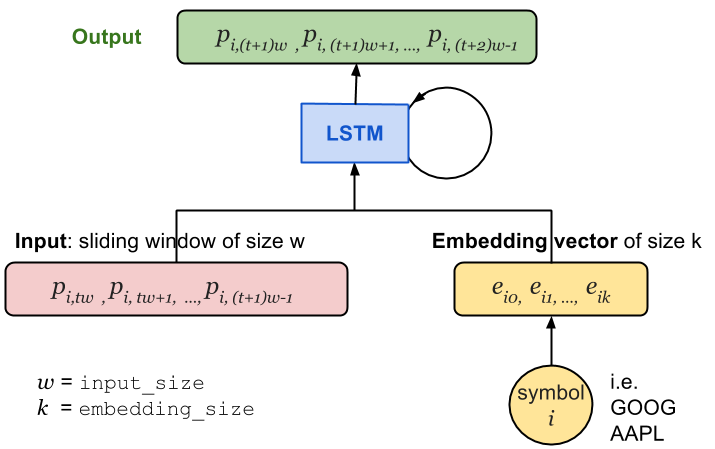

In [ ]:
from typing import List
class StockPriceDataset_MultipleStepsAndStocks(Dataset):
    def __init__(self, list_of_stocks: List=["GOOG"], start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, nb_steps: int=30, normalize: bool=False):

        self.nb_samples = nb_samples
        self.nb_steps = nb_steps
        self.normalize = normalize

        dataset = []
        for stock_name in list_of_stocks:
            dataset.append(yf.download(stock_name, start=start_date, end=end_date, interval=interval))

        start_date, end_date = data_intersection(dataset)
        print("\n Date intersection for all specified stocks is : {} -> {} \n".format(start_date, end_date))

        data = [stock.loc[start_date:end_date] for stock in dataset]
        self.data = data

        # split into items of size nb_samples
        seq = np.array([ stock["Close"].tolist() for stock in self.data ])
        # print("seq.shape = ", seq.shape)
        # print("seq = {}".format(seq))
        seq = [ seq[:, i*self.nb_samples:(i+1)*self.nb_samples] for i in range(seq.shape[1]//self.nb_samples) ]
        # print("seq after nb_samples sampling = {}".format(seq))
        print("seq.shape = ", np.array(seq).shape)

        if self.normalize:
            normalization_values = seq[0][:, 0] + [seq[i-1][:, -1] for i in range(1, len(seq[1:]))]
            print("seq[0] = ", seq[0])
            print("seq[0][:, 0] = ", seq[0][:, 0])
            seq = [ seq[0]/seq[0][:, 0].reshape(-1, 1)-1.0 ] + [ curr/seq[i][:, -1].reshape(-1, 1)-1.0 for i, curr in enumerate(seq[1:]) ]
            # seq = [seq[0] / seq[0][:, 0] ] + [curr / seq[i][:, -1] for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        samples = np.array([seq[i: i + self.nb_steps] for i in range(len(seq) - self.nb_steps)])
        labels = np.array([seq[i + self.nb_steps] for i in range(len(seq) - self.nb_steps)])

        self.samples = samples
        self.labels = labels
        self.normalization_values = normalization_values
        

    def __len__(self) -> int:
        return len(self.data[0]) - self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
         # Load one sample more than nb_samples for normalizing, transform
        sample = torch.tensor(self.samples[index])
        label = torch.tensor(self.labels[index])
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def data_intersection(dataset):
    date_amplitudes = [len(stock.index) for stock in dataset]
    date_start_to_end = np.array([ (stock.index[0], stock.index[-1]) for stock in dataset ])
    ind = np.argmin(date_amplitudes)
    return date_start_to_end[ind]

In [ ]:
class StockAI_with_embedding(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, dropout, proj_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=dropout, batch_first=True,  proj_size=proj_size)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]

In [ ]:
# Model configuration
config = StockAIConfig().config

# Adds configuration for embedding
config["embedding"] = {
    "list_of_stocks":["GOOG", '^GSPC', 'AAPL'], # A modifier si besoin de plus de/d'autres stocks
}
config["embedding"]["embed_size"] = len(config["embedding"]["list_of_stocks"])

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the Dataset_train
dataset_train = StockPriceDataset_MultipleStepsAndStocks(
    config["embedding"]["list_of_stocks"],
    config["dataset_train"]["start_date"], 
    config["dataset_train"]["end_date"],
    config["dataset_train"]["interval_date"], 
    config["dataset_train"]["nb_samples"],
    normalize=True)

# Init dataloader of the Dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

print("dataset_train samples shape =", dataset_train.samples.shape)
print("dataset_train labels shape =", dataset_train.labels.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 Date intersection for all specified stocks is : 2004-08-19 00:00:00 -> 2008-11-14 00:00:00 

seq.shape =  (71, 3, 15)
seq[0] =  [[4.99826546e+01 5.39527702e+01 5.44957352e+01 5.22391968e+01
  5.28020859e+01 5.37535172e+01 5.28768044e+01 5.08145332e+01
  5.09938622e+01 4.99378204e+01 5.05654678e+01 4.98182678e+01
  5.06003380e+01 5.09589920e+01 5.09639740e+01]
 [1.09122998e+03 1.09834998e+03 1.09568005e+03 1.09618994e+03
  1.10495996e+03 1.10508997e+03 1.10777002e+03 1.09915002e+03
  1.10423999e+03 1.10591003e+03 1.11831006e+03 1.11363000e+03
  1.12130005e+03 1.11627002e+03 1.11838000e+03]
 [5.48393011e-01 5.50000012e-01 5.55000007e-01 5.70536017e-01
  5.90179026e-01 6.18929029e-01 6.13393009e-01 6.09286010e-01
  6.15893006e-01 6.40357018e-01 6.36785984e-01 6.29106998e-01
  6.38571